#Load data

In [1]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import math

# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# Train/test split
df_full = df_raw.sample(frac = 0.8, random_state = 40)
df_test = df_raw.drop(df_full.index)

# Changing inc_angle from object to float64
df_full.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df_full['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df_full[df_full.inc_angle.isna()] # 133 NaN

# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['delta_b'+str(label)] = [(np.max(np.array(matx))-np.min(np.array(matx))) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]
  return data
  
df_full = add_features(df_full,1)
df_full = add_features(df_full,2)

df_full['delta_max'] = df_full[['delta_b1','delta_b2']].apply(np.max,axis=1)

# Creating the two weighted bands
df_full["band_2ab"] = (2*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(1*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))
df_full["band_a2b"] = (1*(np.array(df_full["band_1"])-np.array(df_full["min_b1"]))+(2*np.array(df_full["band_2"]-np.array(df_full["min_b2"]))))/(3*np.array(df_full["delta_max"]))

# Creating the final dataframe
df = pd.DataFrame()
df['band_1'] = df_full["band_2ab"]
df['band_2'] = df_full["band_a2b"]
df['is_iceberg'] = df_full['is_iceberg']
df['inc_angle'] = df_full['inc_angle']

Mounted at /content/drive


# Adding app

In [2]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

import cv2 as cv
from google.colab.patches import cv2_imshow



# Classifier models
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, cross_val_predict, GridSearchCV 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_curve

from scipy.optimize import fmin, minimize_scalar

def show_bands(row):
  print(f'Index : {row.name}')
  f, (img1, img2) = plt.subplots(1, 2, figsize = (10,10))
  img1.imshow(np.array(row.band_1).reshape(75,75))
  img1.set_title("band_1")
  img2.imshow(np.array(row.band_2).reshape(75,75))
  img2.set_title("band_2")
  img1.set_yticks([])
  img1.set_xticks([])
  img2.set_yticks([])
  img2.set_xticks([])
  plt.show()

class EvaluateAndReport:
  def __init__(self, df, X_train, X_test, y_train, y_test, scoring = 'f1', grid_cv = 5, cv_cv = 10, best_scores_t = {}):
    self.df = df
    self.X_train, self.y_train, self.X_test, self.y_test = X_train, y_train, X_test, y_test
    self.scoring = scoring
    self.grid_cv = grid_cv
    self.cv_cv = cv_cv
    #self.threshold = threshold
    self.best_scores_t = best_scores_t


  def grid_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      print('--- Grid Search Report ---')
      grid_search = GridSearchCV(classifier, param_grid, cv = self.grid_cv, scoring = self.scoring, return_train_score = True)
      grid_search.fit(self.X_train, self.y_train)

      print(f'Best parameters for {classifier} :\n {grid_search.best_params_} with {self.scoring} score {round(grid_search.best_score_,3)}')

      self.last_best = grid_search.best_estimator_
    else:
      print("cross_report should be used when there is no param_grid")


  def cross_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Cross Validation Report ---')
    scorings = ('accuracy', 'f1', 'precision', 'recall')
    scores = cross_validate(classifier, self.X_train, self.y_train, cv = self.cv_cv, scoring = scorings)
    self.best_scores_t = {scoring : round(np.mean(scores["test_"+scoring]),3) for scoring in scorings}
    [print(f'Mean {scoring} score {round(np.mean(scores["test_"+scoring]),3)} with std {round(np.std(scores["test_"+scoring]),3)}') for scoring in scorings]


  def test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Test Sample Report ---')
    classifier.fit(self.X_train, self.y_train)
    self.last_y_pred = classifier.predict(self.X_test)

    print(f'Scores for the test sample :')
    print(f' accuracy : {round(accuracy_score(self.y_test, self.last_y_pred),3)}')
    print(f' f1 : {round(f1_score(self.y_test, self.last_y_pred),3)}')
    print(f' precision : {round(precision_score(self.y_test, self.last_y_pred),3)}')
    print(f' recall : {round(recall_score(self.y_test, self.last_y_pred),3)}')

    print('Confusion matrix for the test sample :')
    cm = confusion_matrix(self.y_test, self.last_y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Boat','Iceberg']).plot(cmap="Blues", values_format='')


  def grid_cross_test_report(self, classifier = None, param_grid = None):
    if classifier is None:
      classifier = self.last_best
    if not(param_grid is None):
      self.grid_report(classifier, param_grid)
      self.cross_report(self.last_best)
      self.test_report(self.last_best)
    else:
      print('cross_test_report should be used when there is no param_grid')

  def cross_test_report(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    self.cross_report(classifier)
    self.test_report(classifier)

  def cross_proba_report(self, classifier = None, threshold = 0.5):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Cross Validation with {threshold} Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, threshold))

  def calc_proba_scores(self, y_train_scores, threshold):
    y_pred = (y_train_scores >= threshold)
    return (accuracy_score(self.y_train, y_pred), f1_score(self.y_train, y_pred, zero_division=0), precision_score(self.y_train, y_pred, zero_division=0), recall_score(self.y_train, y_pred, zero_division=0))

  def print_proba_scores(self, scores):
    print(f' accuracy : {round(scores[0],3)}')
    print(f' f1 : {round(scores[1],3)}')
    print(f' precision : {round(scores[2],3)}')
    print(f' recall : {round(scores[3],3)}')

  def full_cross_proba_report(self, classifier = None, res = 50):
    if classifier is None:
      classifier = self.last_best
    print(f'--- Threshold Report ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    probas = np.linspace(0.0,1.0,res)
    full_scores = np.array([self.calc_proba_scores(y_train_scores, threshold) for threshold in probas])

    plt.figure(figsize=(8,6))
    plt.plot(probas, full_scores[:,0], "b-", label="Accuracy", linewidth=2)
    plt.plot(probas, full_scores[:,1], "g-", label="F1", linewidth=2)
    plt.plot(probas, full_scores[:,2], "r-", label="Precision", linewidth=2)
    plt.plot(probas, full_scores[:,3], "c-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0.4, 1])
    plt.xlim([0, 1])
    plt.grid(b=True, linestyle='-')

    #Searching for optimals
    acc_opt = minimize_scalar(lambda x : -self.calc_proba_scores(y_train_scores, x)[0], bracket=(0.0,1.0))
    if acc_opt.x < 0: acc_opt.x = 0.0
    elif acc_opt.x > 1 : acc_opt.x = 1.0
    print(f'Optimal threshold for accuracy is {round(acc_opt.x,2)} with:')
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, acc_opt.x))

    acc_opt = minimize_scalar(lambda x : -self.calc_proba_scores(y_train_scores, x)[1], bracket=(0.0,1.0))
    if acc_opt.x < 0: acc_opt.x = 0.0
    elif acc_opt.x > 1 : acc_opt.x = 1.0
    print(f'Optimal threshold for f1 is {round(acc_opt.x,2)} with:')
    self.print_proba_scores(self.calc_proba_scores(y_train_scores, acc_opt.x))

  def plot_precision_recall(self, classifier = None):
    if classifier is None:
      classifier = self.last_best
    print('--- Precision Recall Curves ---')
    y_train_scores = cross_val_predict(self.last_best, self.X_train, self.y_train, cv=self.cv_cv, method='predict_proba')
    y_train_scores = np.array([y[1] for y in y_train_scores])
    precisions, recalls, probas = precision_recall_curve(self.y_train, y_train_scores)

    plt.figure(0)
    plt.plot(probas, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(probas, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Probablility threshold", fontsize=16)
    plt.ylabel("Score", fontsize=16)
    plt.legend(loc="best", fontsize=16)
    plt.ylim([0, 1])

    plt.figure(1)
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

  def plot_mistakes(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for wrongly predicted individuals
    #By default, false positives and false negatives are shown. If one is chosen in 'nature', the other ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boat_as_iceberg':
      print('--- Icebergs predicted as boats ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'iceberg_as_boat':
      print('--- Boats predicted as Icebergs ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)

  def plot_predicted(self, nb_samples = 1, nature = None, random_state = None):
    #Plots bands for correclty predicted individuals
    #By default, correctly predicted icebergs and boats are shown. If one is chosen in 'nature', the others ones won't be shown
    df_res = df.join(pd.DataFrame(data=self.last_y_pred, index=self.y_test.index, columns=['is_iceberg_pred']))
    
    if nature != 'boats':
      print('--- Icebergs predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 1) & df_res['is_iceberg'] == 1].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)
    if nature != 'icebergs':
      print('--- Boats predicted correctly ---')
      df_res[(df_res['is_iceberg_pred'] == 0) & df_res['is_iceberg'] == 0].sample(nb_samples, random_state = random_state).apply(show_bands, axis=1)


# Adding more features to the initial dataset
def add_features(data, label) :
  data['max_b'+str(label)] = [np.max(np.array(matx)) for matx in data['band_'+str(label)]]
  data['min_b'+str(label)] = [np.min(np.array(matx)) for matx in data['band_'+str(label)]]
  data['median_b'+str(label)] = [np.median(np.array(matx)) for matx in data['band_'+str(label)]]
  data['mean_b'+str(label)] = [np.mean(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmax_b'+str(label)] = [np.argmax(np.array(matx)) for matx in data['band_'+str(label)]]
  data['argmin_b'+str(label)] = [np.argmin(np.array(matx)) for matx in data['band_'+str(label)]]
  data['variance_b'+str(label)] = [np.var(np.array(matx)) for matx in data['band_'+str(label)]]



  #data['band_'+str(label)] = [np.array(matx).reshape(75,75) for matx in data['band_'+str(label)]]

  return data


# Adding sobel features to the initial dataset

def add_sobel_features(datasobel, label, data) :
  #Find the contour pixels by taking out the max 75 elements
  
  datasobel['contourpixel_b'+str(label)] = [np.array(matx)[np.argpartition(np.array(matx), -75)[-75:]] for matx in datasobel['band_'+str(label)]]

  data['max_of_contour_b'+str(label)] = [np.max(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['min_of_contour_b'+str(label)] = [np.min(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['median_of_contour_b'+str(label)] = [np.median(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['mean_of_contour_b'+str(label)] = [np.mean(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmax_of_contour_b'+str(label)] = [np.argmax(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['argmin_of_contour_b'+str(label)] = [np.argmin(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]
  data['variance_of_contour_b'+str(label)] = [np.var(np.array(matx)) for matx in datasobel['contourpixel_b'+str(label)]]

  return data

def contour(matx):

  image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(matx), sigma_spatial = 1), weight = 0.1)
  image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
  
  image_8bit = np.array(np.uint8(image * 255))

  threshold_level = 155 # Set as we need...
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)
  #binarized= cv.adaptiveThreshold(image_8bit,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cv.drawContours(image, contours,-1,(0,255,0), 1)
  plt.imshow(image)
  cnt = contours[0]
  if cnt.size<10:
    cnt=contours[len(contours)-1]


  #Surace area of the contour
  area = cv.contourArea(cnt)

  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  if cnt.size>=10:
    ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
    A = np.pi * MA * ma/4
    ellipse_ratio=area/A
  else: 
    ellipse_ratio = "not_available"

  # #Rectangle
  # #Get Rec
  # rect = cv.minAreaRect(cnt)
  # box = cv.boxPoints(rect)
  # box = np.int0(box)
  
  # #Calculate Rec area
  # a=math.sqrt((box[0][0]-box[1][0])**2+(box[0][1]-box[1][1])**2)
  # b=math.sqrt((box[1][0]-box[2][0])**2+(box[1][1]-box[2][1])**2)
  # Rec = a*b
  
  # #Calculate Rec Ratio
  # rec_ratio=area/Rec
  # rec_ratio

  return area, perimeter, AP_Ratio, ellipse_ratio #rec_ratio


def apply_and_concat(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

def MatrixtoArray(data, label) :
  data['band_'+str(label)] = [np.array(matx).ravel() for matx in data['band_'+str(label)]]

# Plotting the new feature in a histogram
def plot_features(data, name):
  plt.hist(data.loc[data.is_iceberg==1,name], bins=50, color='navy',alpha=0.5,label='Iceberg')
  plt.hist(data.loc[data.is_iceberg==0,name], bins=50,color='firebrick',alpha=0.5, label='Bateau')
  plt.legend()
  plt.xlabel(name)
  #plt.ylabel('Frequency')
  plt.show()

# Loading the dataset and importing libraries


In [3]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from numpy import fft
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

# Data treatment

In [4]:
#df.head()

In [5]:
#plt.imshow(df.iat[1,1])

## Image pretreatment example

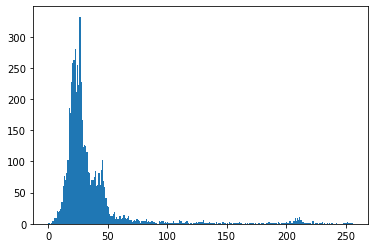

In [6]:
from functools import partial
import pywt
from skimage import feature
from skimage.filters import sobel
import skimage as sk
import skimage.filters as fl
import skimage.restoration as rs
  
image = rs.denoise_tv_chambolle(rs.denoise_bilateral(np.array(df.iat[888,1]), sigma_spatial = 1), weight = 0.1)
image = (image-np.amin(image))/(np.amax(image)-np.amin(image))
image_8bit = np.uint8(image * 255)
            
plt.hist(image_8bit.ravel(),bins = 256, range = [0, 256])
plt.show()

(170.5,
 75.35533833503723,
 2.2626134228465706,
 0.5963212652990765,
 [array([[[41, 23]],
  
         [[40, 24]],
  
         [[40, 25]],
  
         [[39, 26]],
  
         [[39, 27]],
  
         [[36, 30]],
  
         [[34, 30]],
  
         [[33, 31]],
  
         [[32, 31]],
  
         [[31, 32]],
  
         [[29, 32]],
  
         [[28, 33]],
  
         [[27, 33]],
  
         [[26, 34]],
  
         [[23, 34]],
  
         [[22, 35]],
  
         [[21, 35]],
  
         [[19, 37]],
  
         [[18, 37]],
  
         [[18, 39]],
  
         [[20, 41]],
  
         [[21, 40]],
  
         [[24, 40]],
  
         [[25, 39]],
  
         [[27, 39]],
  
         [[28, 38]],
  
         [[30, 38]],
  
         [[31, 37]],
  
         [[36, 37]],
  
         [[37, 38]],
  
         [[39, 38]],
  
         [[41, 36]],
  
         [[42, 36]],
  
         [[43, 35]],
  
         [[43, 31]],
  
         [[42, 30]],
  
         [[42, 25]],
  
         [[43, 24]],
  
         [[42, 23]

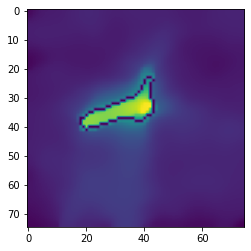

In [7]:
  threshold_level = 127 #np.amax(image_8bit)/2 # Set as we need...
  
  ret, binarized = cv.threshold(image_8bit, threshold_level, 255, cv.THRESH_BINARY)
  #binarized= cv.adaptiveThreshold(image_8bit,255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2)

  contours, _ = cv.findContours(binarized, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  cnt = contours[0]
  cv.drawContours(image, contours, -1, (0,255,0), 1)
  plt.imshow(image)
  cnt
  #threshold_level


  #Surace area of the contour
  area = cv.contourArea(cnt)
  
  #Perimeter of the contour
  perimeter = cv.arcLength(cnt,True)

  #A/P ratio
  AP_Ratio=area/perimeter

  #Ellipse
  ellipse = (x, y), (MA, ma), angle = cv.fitEllipse(cnt)
  A = np.pi * MA * ma/4
  ellipse_ratio=area/A

  area, perimeter, AP_Ratio, ellipse_ratio, contours

##Add OpenCV contours

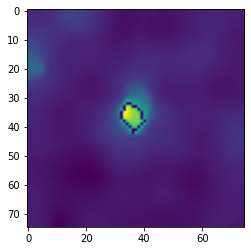

In [8]:
df=apply_and_concat(df, 'band_1', contour, ['area1', 'perimeter1', 'AP_Ratio1', 'ellipse_ratio1'])
df=apply_and_concat(df, 'band_2', contour, ['area2', 'perimeter2', 'AP_Ratio2', 'ellipse_ratio2'])

##Denoise images

In [9]:
#Denoise all images and draw the contour
def denoiseimg(x):
  y = np.array(x).reshape(75,75)
  y = (y - y.min())/(y.max()-y.min())
  y = rs.denoise_tv_chambolle(rs.denoise_bilateral(y.reshape(75,75), sigma_spatial = 1), weight = 0.1)
  y = y.ravel()
  return y

df["band_1"]=df["band_1"].apply(denoiseimg)
df["band_2"]=df["band_2"].apply(denoiseimg)

df.head()

band_1  ... ellipse_ratio2
486   [0.2859490966023374, 0.28461867993629886, 0.28...  ...       0.593261
760   [0.2150496407224249, 0.21592598109175914, 0.21...  ...       0.738801
1502  [0.3223078770878962, 0.3208062688624039, 0.318...  ...       0.889706
682   [0.16522957250934434, 0.16741781237244205, 0.1...  ...       0.735465
1324  [0.3851571495575763, 0.38596087985417465, 0.38...  ...       0.764474

[5 rows x 12 columns]

## Add general features

In [10]:
# Adding all possible features 
df = add_features(df,1)
df = add_features(df,2)
df.head()

band_1  ... variance_b2
486   [0.2859490966023374, 0.28461867993629886, 0.28...  ...    0.002476
760   [0.2150496407224249, 0.21592598109175914, 0.21...  ...    0.002865
1502  [0.3223078770878962, 0.3208062688624039, 0.318...  ...    0.002393
682   [0.16522957250934434, 0.16741781237244205, 0.1...  ...    0.001368
1324  [0.3851571495575763, 0.38596087985417465, 0.38...  ...    0.001178

[5 rows x 26 columns]

##Add Sobel Contour Features

In [11]:
# Adding sobel contour features 
df_sobel = pd.DataFrame(columns=['band_1','band_2'])

def sobelimg(x):
  y = np.array(x).reshape(75,75)
  y = sobel(y)
  y = y.ravel()
  return y

df_sobel["band_1"]=df["band_1"].apply(sobelimg)
df_sobel["band_2"]=df["band_2"].apply(sobelimg)


df = add_sobel_features(df_sobel,1,df)
df = add_sobel_features(df_sobel,2,df)
df.head()



band_1  ... variance_of_contour_b2
486   [0.2859490966023374, 0.28461867993629886, 0.28...  ...               0.001737
760   [0.2150496407224249, 0.21592598109175914, 0.21...  ...               0.002795
1502  [0.3223078770878962, 0.3208062688624039, 0.318...  ...               0.000197
682   [0.16522957250934434, 0.16741781237244205, 0.1...  ...               0.002120
1324  [0.3851571495575763, 0.38596087985417465, 0.38...  ...               0.002296

[5 rows x 40 columns]

##Split all the pixels into a table called X

In [12]:
naive_base_pretreated = X = pd.DataFrame(df.band_1.to_list(), index=df.index, columns=[f"band_1_{i}" for i in range(75*75)]).join(pd.DataFrame(df.band_2.to_list(), index=df.index, columns=[f"band_2_{i}" for i in range(75*75)]))

In [13]:
X

band_1_0  band_1_1  band_1_2  ...  band_2_5622  band_2_5623  band_2_5624
486   0.285949  0.284619  0.281471  ...     0.247499     0.248710     0.249314
760   0.215050  0.215926  0.217425  ...     0.207614     0.207606     0.207631
1502  0.322308  0.320806  0.318666  ...     0.459428     0.461731     0.464367
682   0.165230  0.167418  0.171763  ...     0.239992     0.239261     0.239018
1324  0.385157  0.385961  0.385967  ...     0.378805     0.383922     0.386901
...        ...       ...       ...  ...          ...          ...          ...
23    0.322935  0.324103  0.329167  ...     0.370093     0.380235     0.384944
539   0.149148  0.154031  0.161499  ...     0.112693     0.108876     0.107106
142   0.458120  0.464155  0.468025  ...     0.420055     0.417115     0.415229
5     0.172523  0.176434  0.181270  ...     0.175657     0.172953     0.171770
791   0.274684  0.274683  0.274600  ...     0.247251     0.262950     0.264107

[1283 rows x 11250 columns]

##Join the split pixels with images and features

In [14]:
# splitting the bands into single elements
df = df.join(naive_base_pretreated)

In [15]:
df.head()

band_1  ... band_2_5624
486   [0.2859490966023374, 0.28461867993629886, 0.28...  ...    0.249314
760   [0.2150496407224249, 0.21592598109175914, 0.21...  ...    0.207631
1502  [0.3223078770878962, 0.3208062688624039, 0.318...  ...    0.464367
682   [0.16522957250934434, 0.16741781237244205, 0.1...  ...    0.239018
1324  [0.3851571495575763, 0.38596087985417465, 0.38...  ...    0.386901

[5 rows x 11290 columns]

In [16]:
df["band_1"][824]

array([0.17829118, 0.18025075, 0.18564069, ..., 0.11682832, 0.11151332,
       0.10953672])

## Histograms of features

In [17]:
#There are 13 images where there are fewer than 4 points on the contour therefore not possible to draw an ellipse

df[(df["ellipse_ratio1"]=='not_available') | (df["ellipse_ratio2"]=='not_available')]

band_1  ... band_2_5624
1270  [0.48897593983187443, 0.4879313850500822, 0.48...  ...    0.327376
1445  [0.3453374220731933, 0.34840025700790384, 0.35...  ...    0.489590
1183  [0.3845483506524973, 0.3852749147763668, 0.385...  ...    0.363567
9     [0.22695672259230573, 0.2286278938537659, 0.23...  ...    0.283061
632   [0.2473522347560512, 0.2475476835290627, 0.247...  ...    0.292837
209   [0.39785937468717003, 0.39733212263173867, 0.3...  ...    0.442727
432   [0.34345186847339165, 0.3427928894754159, 0.34...  ...    0.431821
268   [0.31371038201549206, 0.31349792492737294, 0.3...  ...    0.369119
1224  [0.3005422345129656, 0.29850819806292167, 0.29...  ...    0.151290
1120  [0.3995079177267202, 0.40052184664106405, 0.40...  ...    0.372560
280   [0.29156648522948664, 0.3097524250177768, 0.31...  ...    0.397702
107   [0.2508747713674029, 0.25145483895646886, 0.25...  ...    0.267232
1564  [0.32720948594685556, 0.32668089759442076, 0.3...  ...    0.276326

[13 rows x 11290 columns]

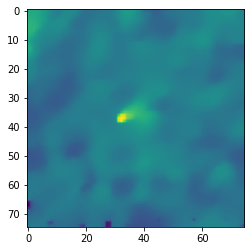

In [18]:
example=np.array(df.loc[[1270],'band_2'])
plt.imshow(example[0].reshape(75,75))

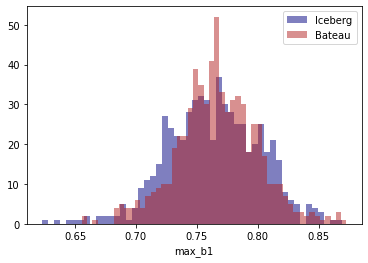

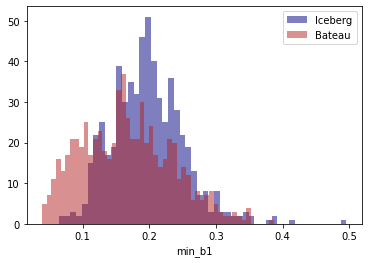

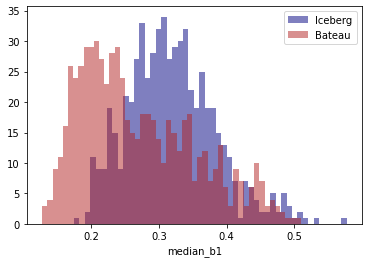

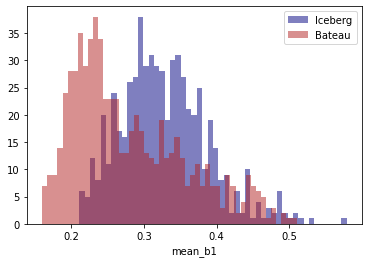

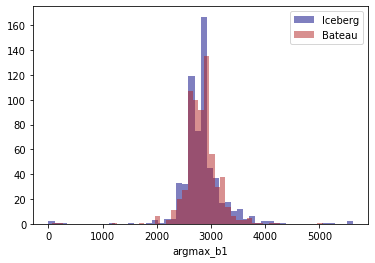

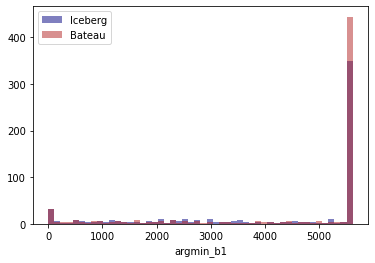

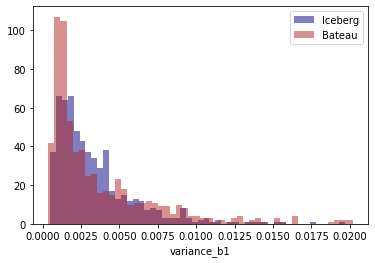

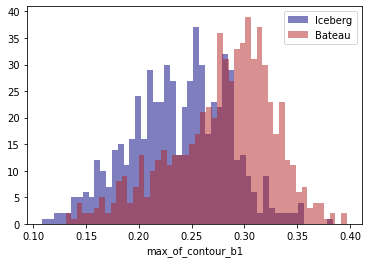

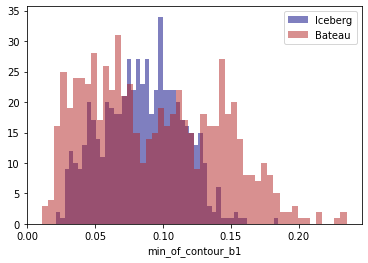

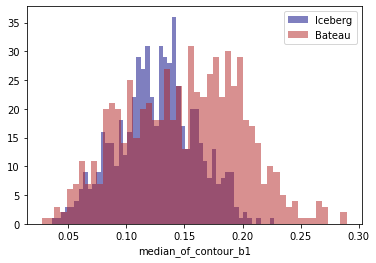

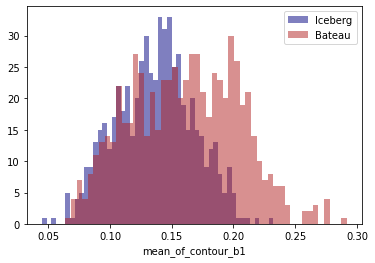

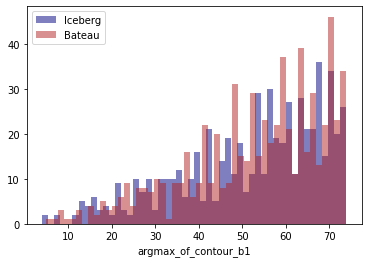

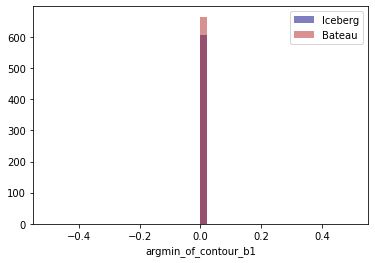

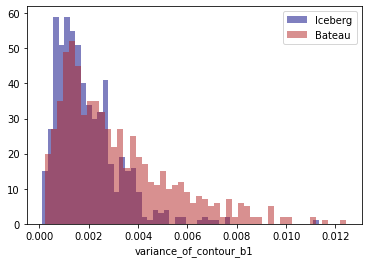

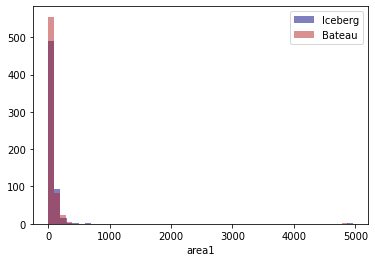

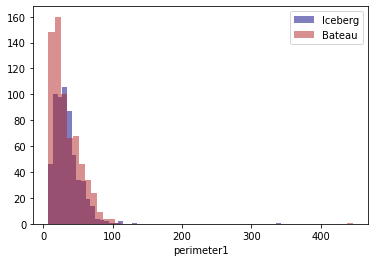

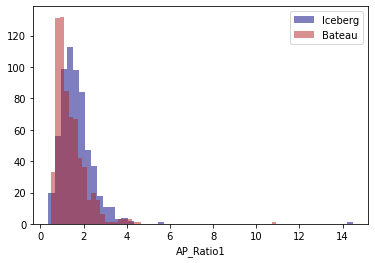

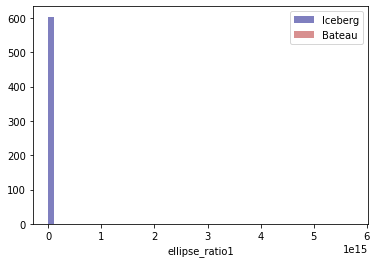

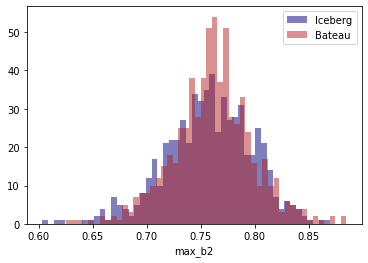

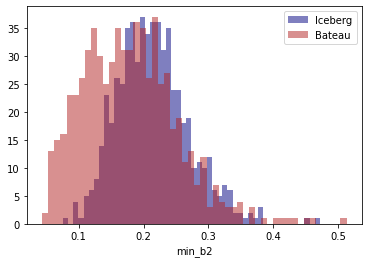

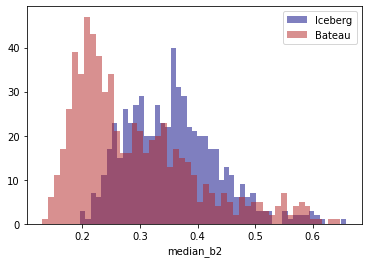

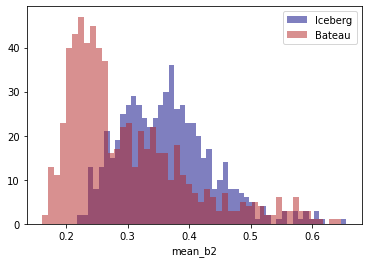

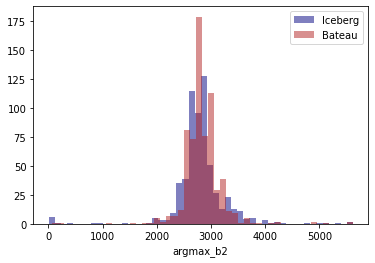

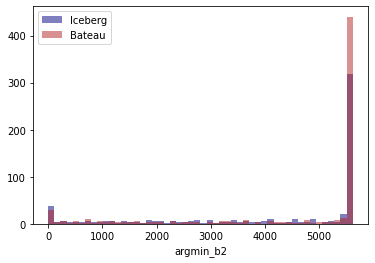

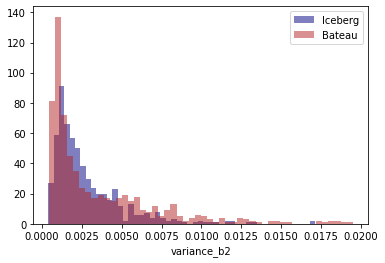

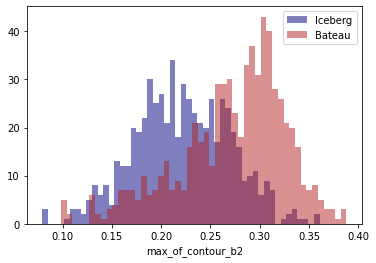

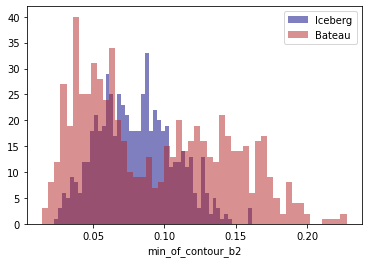

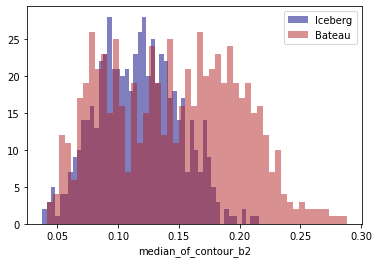

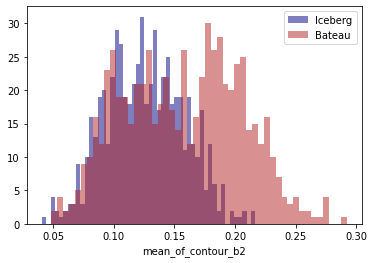

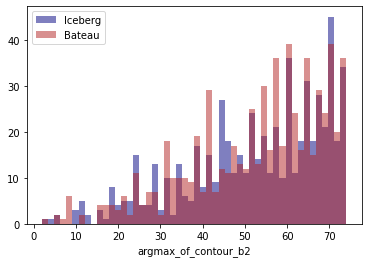

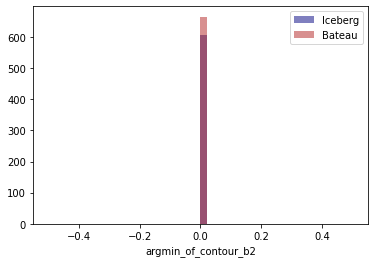

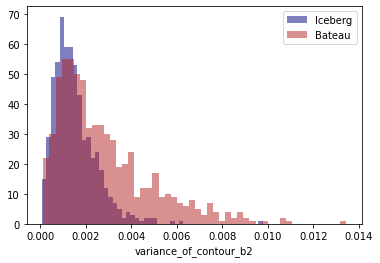

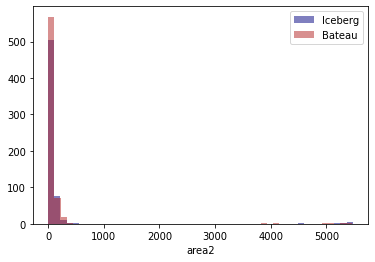

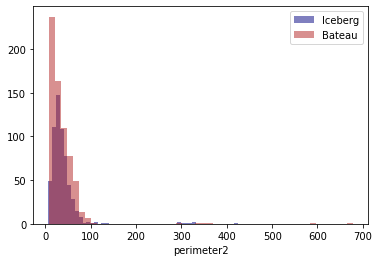

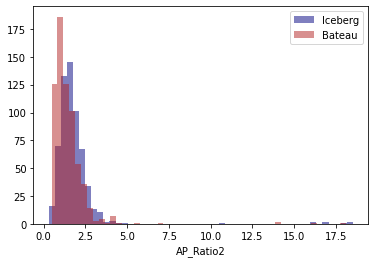

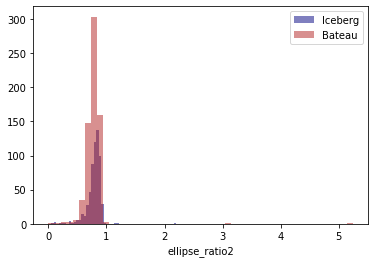

In [19]:
# plotting the variables
for i in [1,2] :
  
  for col in ['max_b'+str(i),'min_b'+str(i),'median_b'+str(i),'mean_b'+str(i),'argmax_b'+str(i),'argmin_b'+str(i),'variance_b'+str(i),
              
              'max_of_contour_b'+str(i),'min_of_contour_b'+str(i),'median_of_contour_b'+str(i),'mean_of_contour_b'+str(i),

              'argmax_of_contour_b'+str(i),'argmin_of_contour_b'+str(i),'variance_of_contour_b'+str(i),

              'area'+str(i),'perimeter'+str(i),'AP_Ratio'+str(i),'ellipse_ratio'+str(i)]:  

    plot_features(df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')],col)

## Matrice de corrélation

In [20]:
df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].head()

band_1  ... band_2_5624
486   [0.2859490966023374, 0.28461867993629886, 0.28...  ...    0.249314
760   [0.2150496407224249, 0.21592598109175914, 0.21...  ...    0.207631
1502  [0.3223078770878962, 0.3208062688624039, 0.318...  ...    0.464367
682   [0.16522957250934434, 0.16741781237244205, 0.1...  ...    0.239018
1324  [0.3851571495575763, 0.38596087985417465, 0.38...  ...    0.386901

[5 rows x 11290 columns]

In [21]:
df["ellipse_ratio1"]=pd.to_numeric(df["ellipse_ratio1"],errors = 'coerce')
df["ellipse_ratio2"]=pd.to_numeric(df["ellipse_ratio2"],errors = 'coerce')

In [22]:
df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 486 to 791
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   band_1                  1283 non-null   object 
 1   band_2                  1283 non-null   object 
 2   is_iceberg              1283 non-null   int64  
 3   inc_angle               1189 non-null   float64
 4   area1                   1283 non-null   float64
 5   perimeter1              1283 non-null   float64
 6   AP_Ratio1               1283 non-null   float64
 7   ellipse_ratio1          1278 non-null   float64
 8   area2                   1283 non-null   float64
 9   perimeter2              1283 non-null   float64
 10  AP_Ratio2               1283 non-null   float64
 11  ellipse_ratio2          1274 non-null   float64
 12  max_b1                  1283 non-null   float64
 13  min_b1                  1283 non-null   float64
 14  median_b1               1283 non-null  

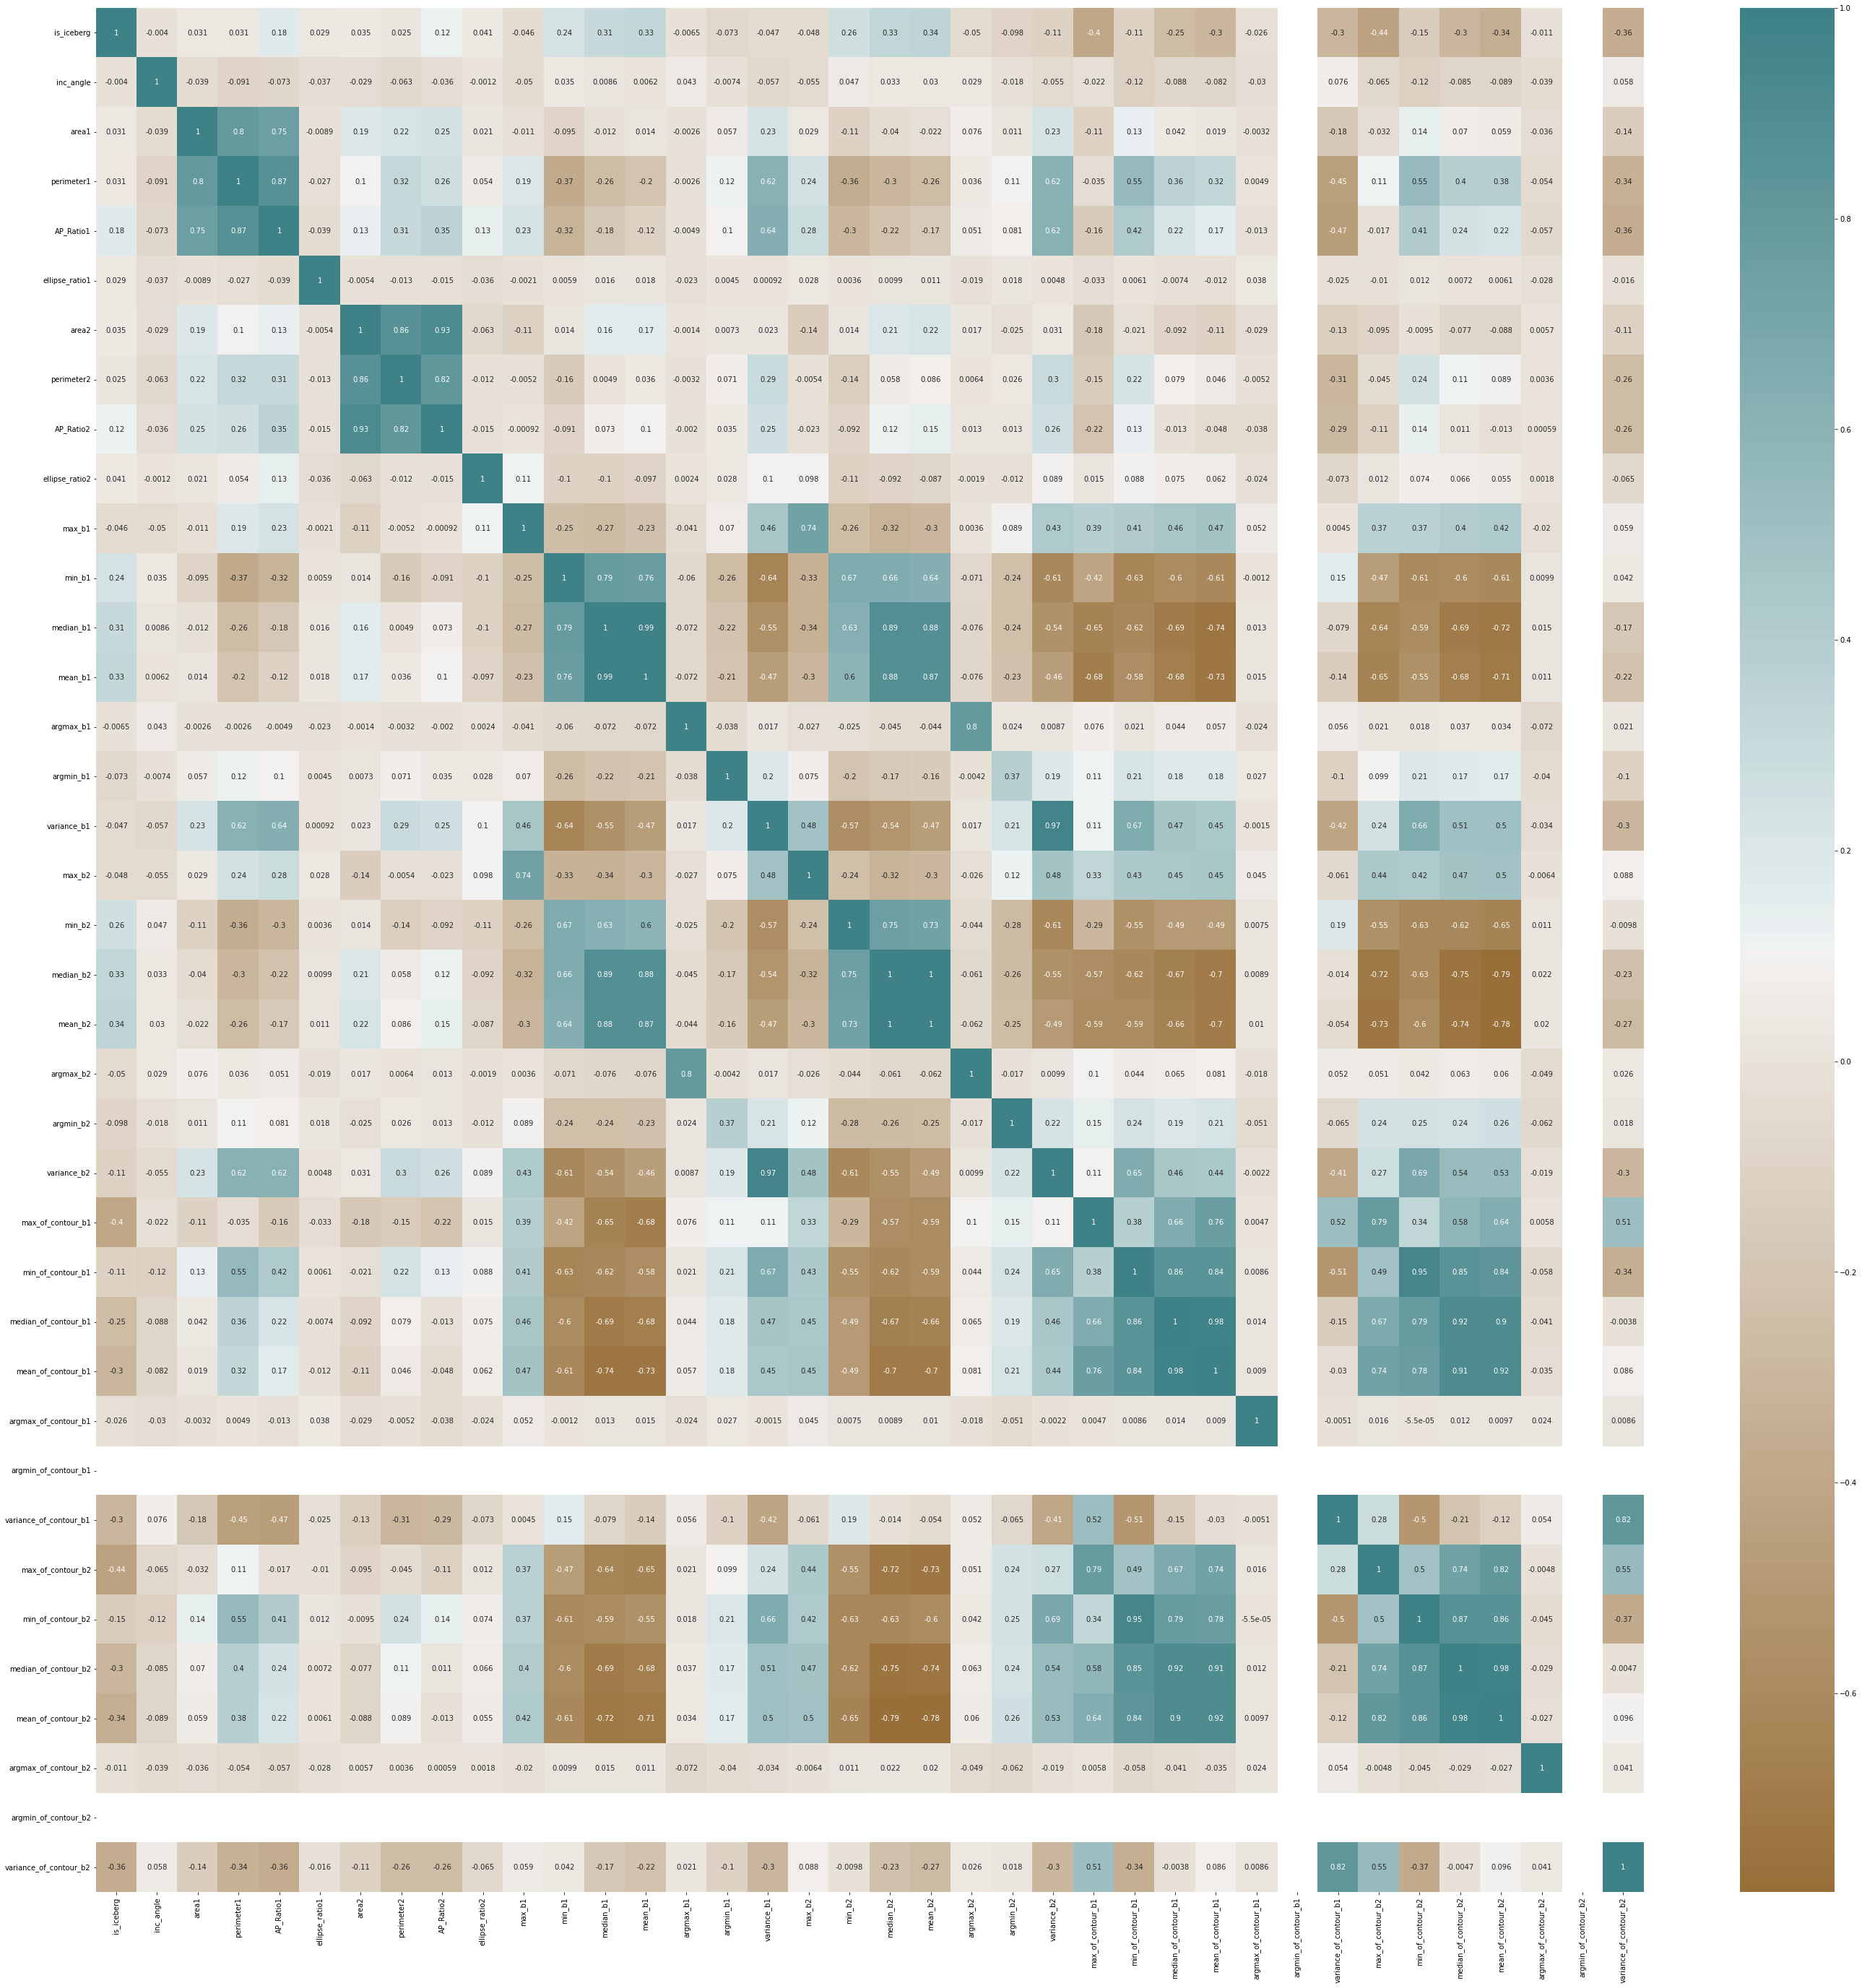

In [23]:
stats_corr = df[(df["ellipse_ratio1"]!='not_available') & (df["ellipse_ratio2"]!='not_available')].drop([f"band_1_{i}" for i in range(75*75)]+[f"band_2_{i}" for i in range(75*75)],axis=1).corr()
plt.figure(figsize = (48,48))
ax = sns.heatmap(stats_corr, annot = True, cmap = sns.diverging_palette(50, 200, n=200))

# Results

## On statistics only

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error

# selecting the prediction target and the model features
dfnew = df.dropna()
y = dfnew["is_iceberg"]
X_stats = dfnew.loc[:,['max_b1','min_b1','median_b1','mean_b1','variance_b1','max_b2','min_b2','median_b2','mean_b2','variance_b2',
           'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
           'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
           'area1','perimeter1','AP_Ratio1','ellipse_ratio1',
           'area2','perimeter2','AP_Ratio2','ellipse_ratio2']]

# split data into training and validation data, for both features and target
# The split is based on a random number generator. 
# Supplying a numeric value to the random_state argument guarantees we get the same 
# split every time we run this script.
X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)

### DecisionTreeClassifier

In [25]:
X_stats

max_b1    min_b1  median_b1  ...  perimeter2  AP_Ratio2  ellipse_ratio2
486   0.763520  0.119434   0.262176  ...   38.627416   1.035534        0.593261
760   0.809186  0.187993   0.249596  ...   30.142135   1.526103        0.738801
1502  0.803208  0.226509   0.366340  ...   47.213203   2.446350        0.889706
682   0.738047  0.141814   0.205832  ...   19.656854   1.068330        0.735465
1324  0.780720  0.236529   0.366813  ...   23.899495   0.774075        0.764474
...        ...       ...        ...  ...         ...        ...             ...
584   0.768739  0.171580   0.298149  ...   27.071068   1.385243        0.778593
23    0.775070  0.230737   0.358947  ...   45.798990   2.336296        0.804830
539   0.768208  0.077706   0.191469  ...   71.455844   3.428691        0.914600
5     0.812462  0.133948   0.227463  ...   37.213203   2.378188        0.954217
791   0.741703  0.242929   0.278103  ...   27.798990   1.654736        0.821645

[1177 rows x 28 columns]

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.802
--- Cross Validation Report ---
Mean accuracy score 0.789 with std 0.022
Mean f1 score 0.788 with std 0.031
Mean precision score 0.825 with std 0.022
Mean recall score 0.758 with std 0.067
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.82
 f1 : 0.822
 precision : 0.808
 recall : 0.836
Confusion matrix for the test sample :


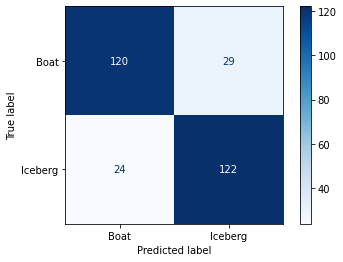

In [26]:
df_stats = dfnew.loc[:,['is_iceberg',
            'max_b1','min_b1','median_b1','mean_b1','variance_b1','max_b2','min_b2','median_b2','mean_b2','variance_b2',
            'max_of_contour_b1','min_of_contour_b1','median_of_contour_b1','mean_of_contour_b1','variance_of_contour_b1',
            'max_of_contour_b2','min_of_contour_b2','median_of_contour_b2','mean_of_contour_b2','variance_of_contour_b2',
            'area1','perimeter1','AP_Ratio1','ellipse_ratio1',
            'area2','perimeter2','AP_Ratio2','ellipse_ratio2']]
er = EvaluateAndReport(df_stats, X_train, X_test, y_train, y_test)

          
param_grid = [{
    'min_samples_leaf': [10],
    'max_features': [None]
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)

In [27]:
er.cross_proba_report()

--- Cross Validation with 0.5 Threshold Report ---
 accuracy : 0.791
 f1 : 0.8
 precision : 0.8
 recall : 0.8


--- Precision Recall Curves ---


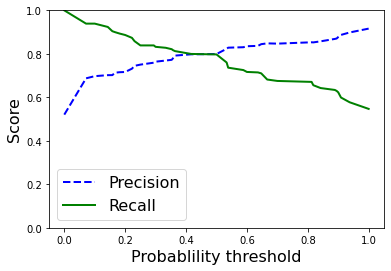

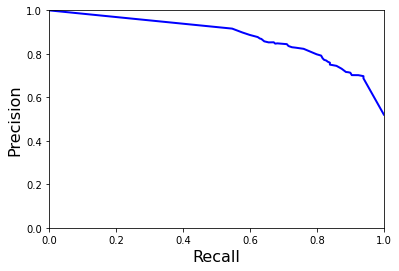

In [28]:
er.plot_precision_recall()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.614
--- Cross Validation Report ---
Mean accuracy score 0.627 with std 0.037
Mean f1 score 0.63 with std 0.032
Mean precision score 0.653 with std 0.044
Mean recall score 0.61 with std 0.025
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.675
 f1 : 0.662
 precision : 0.681
 recall : 0.644
Confusion matrix for the test sample :


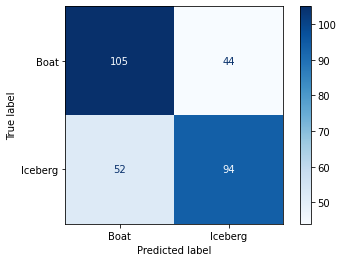

In [29]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train
er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)

###C-support Vector

--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10000.0} with f1 score 0.684
--- Cross Validation Report ---
Mean accuracy score 0.576 with std 0.079
Mean f1 score 0.687 with std 0.004
Mean precision score 0.583 with std 0.088
Mean recall score 0.893 with std 0.151
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :


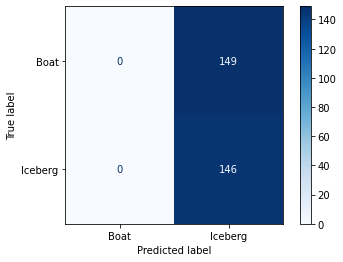

In [30]:
from sklearn.svm import SVC


param_grid = [{
    'C': np.logspace(0, 4, 5)
}]


er.cv_cv = 3
er.X_train = X_train
er.y_train = y_train

er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)



In [31]:
#er.grid_cross_test_report(SVC(kernel='linear'), param_grid)

--- Grid Search Report ---
Best parameters for SVC(kernel='sigmoid') :
 {'C': 1.0} with f1 score 0.679
--- Cross Validation Report ---
Mean accuracy score 0.519 with std 0.002
Mean f1 score 0.682 with std 0.003
Mean precision score 0.52 with std 0.001
Mean recall score 0.991 with std 0.012
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :


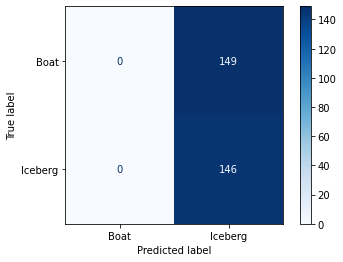

In [32]:
er.grid_cross_test_report(SVC(kernel='sigmoid', gamma='scale'), param_grid)

###Gaussian Process

--- Cross Validation Report ---
Mean accuracy score 0.667 with std 0.022
Mean f1 score 0.669 with std 0.014
Mean precision score 0.695 with std 0.034
Mean recall score 0.645 with std 0.006
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.725
 f1 : 0.725
 precision : 0.718
 recall : 0.733
Confusion matrix for the test sample :


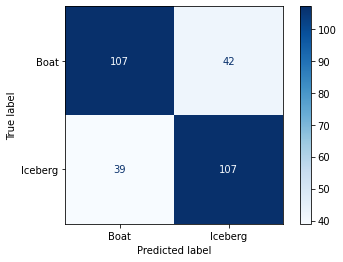

In [33]:
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))

### Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 100} with f1 score 0.865
--- Cross Validation Report ---
Mean accuracy score 0.847 with std 0.017
Mean f1 score 0.855 with std 0.019
Mean precision score 0.843 with std 0.005
Mean recall score 0.867 with std 0.039
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.868
 f1 : 0.87
 precision : 0.845
 recall : 0.897
Confusion matrix for the test sample :


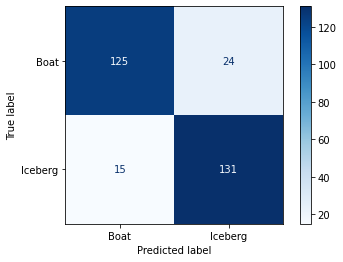

In [34]:
from sklearn.ensemble import RandomForestClassifier

param_grid = [{
    'min_samples_leaf': range(2,15,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]
er.grid_cross_test_report(RandomForestClassifier(), param_grid)

--- Icebergs predicted as boats ---
Index : 257


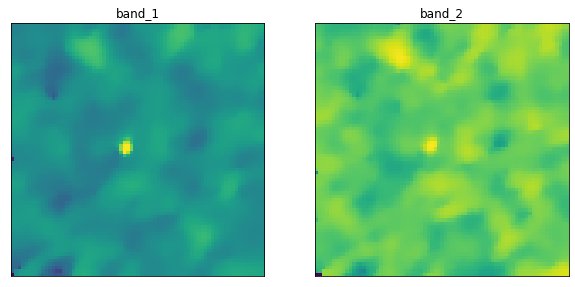

Index : 1160


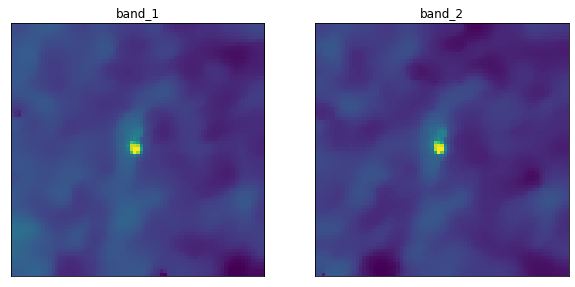

Index : 455


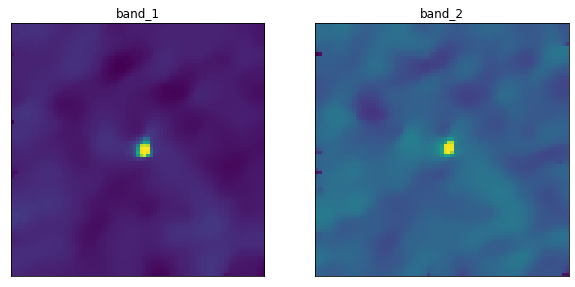

Index : 956


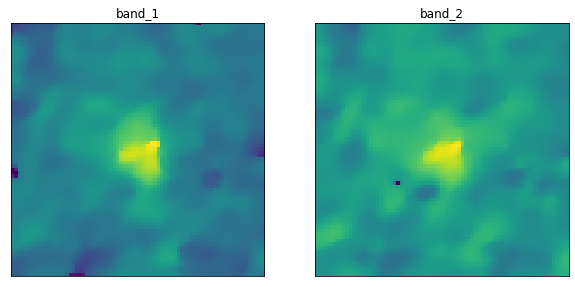

Index : 448


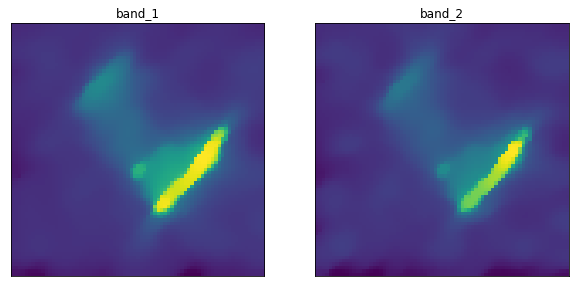

Index : 962


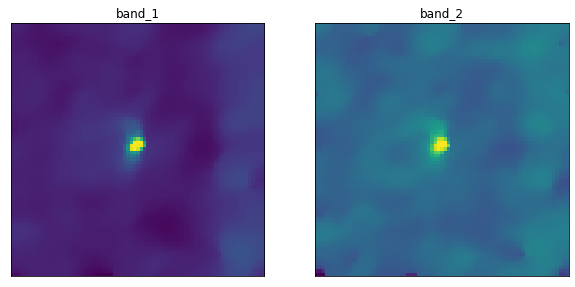

Index : 140


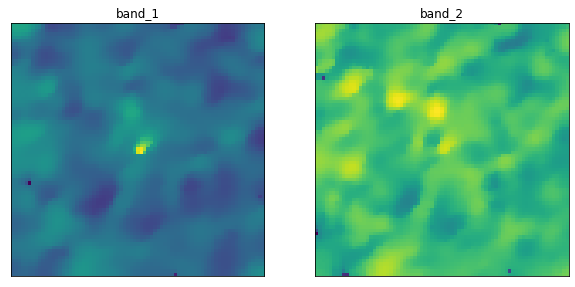

Index : 498


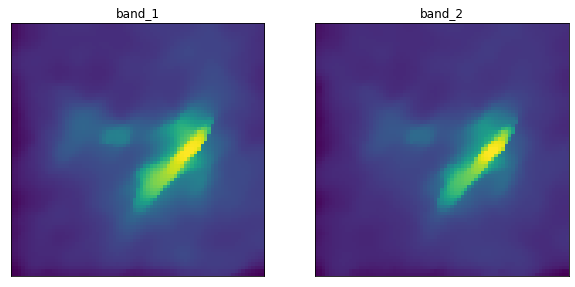

Index : 1033


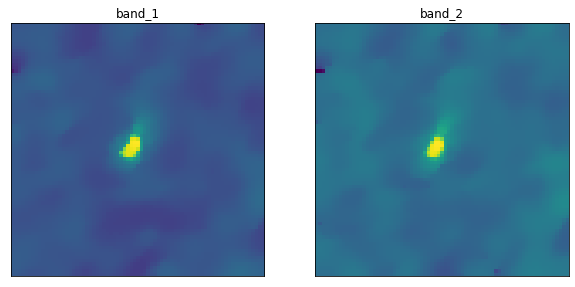

Index : 530


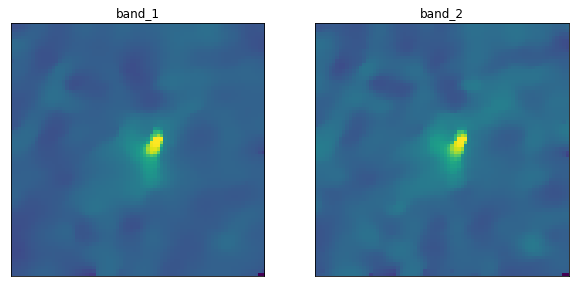

--- Boats predicted as Icebergs ---
Index : 1163


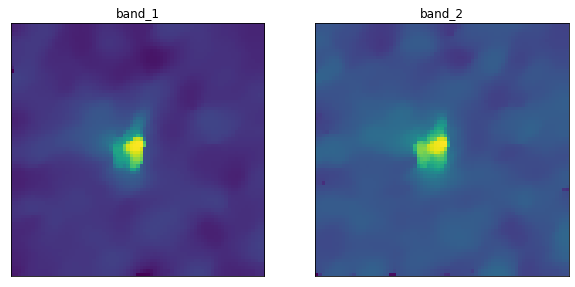

Index : 452


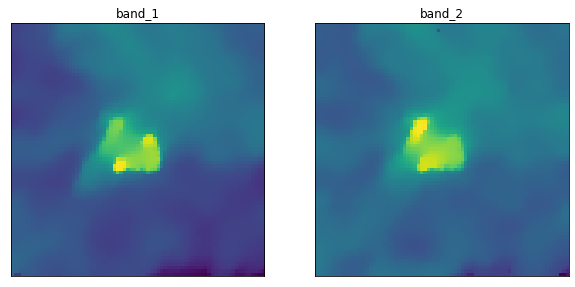

Index : 1229


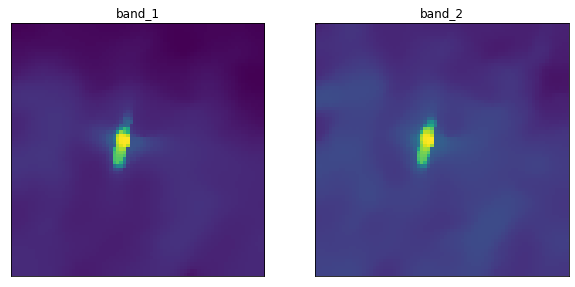

Index : 1191


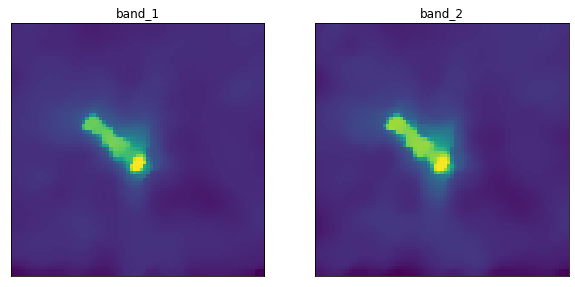

Index : 447


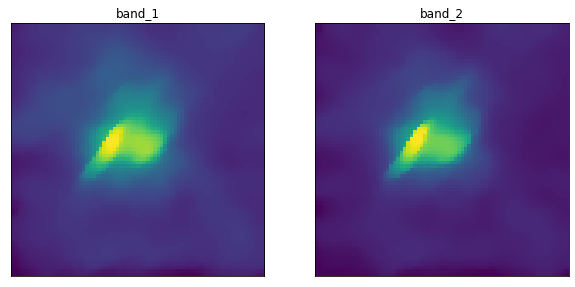

Index : 1281


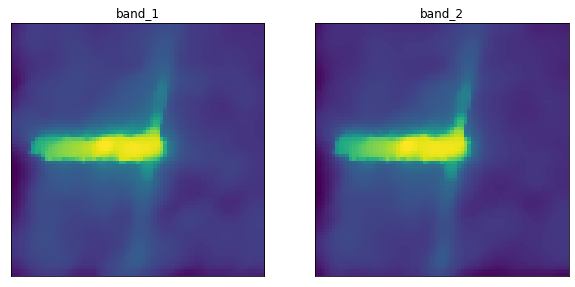

Index : 1299


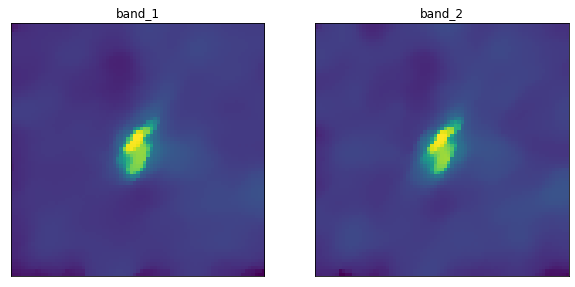

Index : 1519


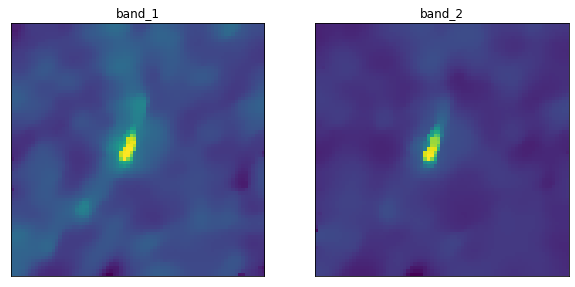

Index : 519


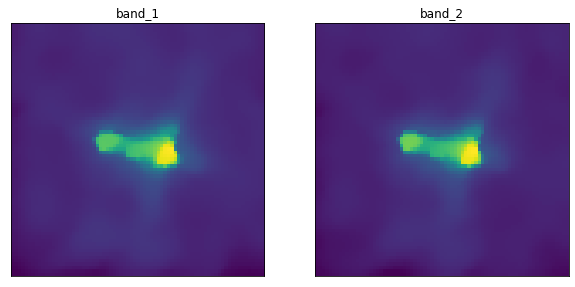

Index : 1406


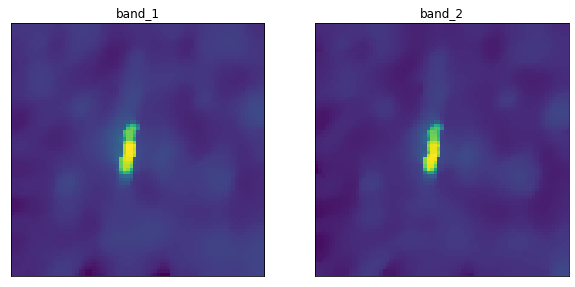

In [35]:
er.plot_mistakes(nb_samples = 10)

###Neural net

--- Grid Search Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overflow encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

invalid value encountered in matmul

/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (700) reached and the optimization hasn't converged yet.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:153: RuntimeWarning:

overfl

Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50, 30), 'learning_rate': 'constant', 'max_iter': 700, 'solver': 'adam'} with f1 score 0.79
--- Cross Validation Report ---
Mean accuracy score 0.757 with std 0.033
Mean f1 score 0.751 with std 0.057
Mean precision score 0.799 with std 0.033
Mean recall score 0.721 with std 0.116
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.729
 f1 : 0.762
 precision : 0.674
 recall : 0.877
Confusion matrix for the test sample :


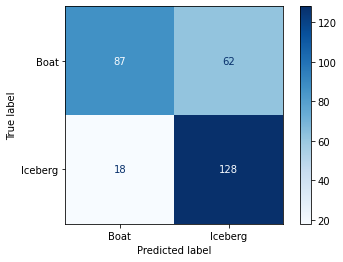

In [36]:
from sklearn.neural_network import MLPClassifier

param_grid = [{'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [700],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']
}]
er.grid_cross_test_report(MLPClassifier(), param_grid)

### Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.836 with std 0.012
Mean f1 score 0.844 with std 0.01
Mean precision score 0.834 with std 0.015
Mean recall score 0.854 with std 0.006
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.834
 f1 : 0.835
 precision : 0.821
 recall : 0.849
Confusion matrix for the test sample :


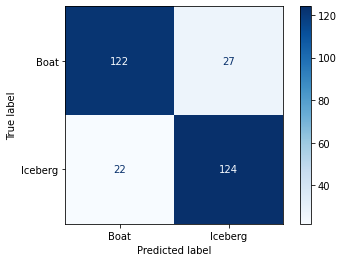

In [37]:
from sklearn.ensemble import AdaBoostClassifier

er.cross_test_report(AdaBoostClassifier())

--- Icebergs predicted as boats ---
Index : 538


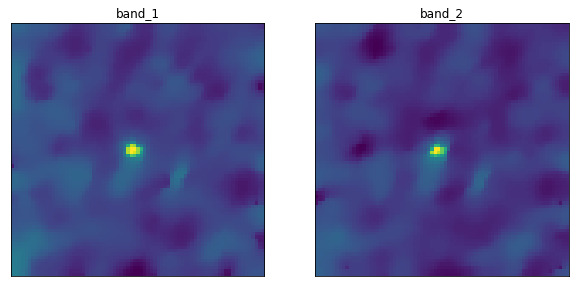

Index : 448


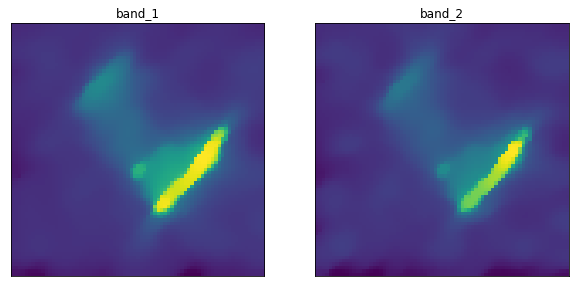

Index : 991


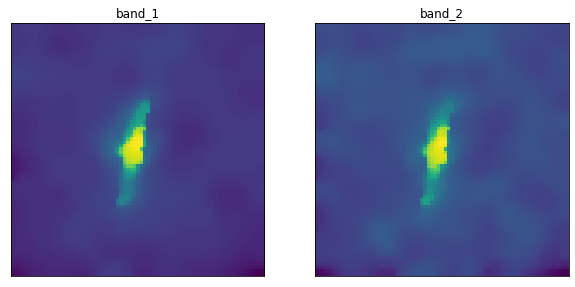

Index : 705


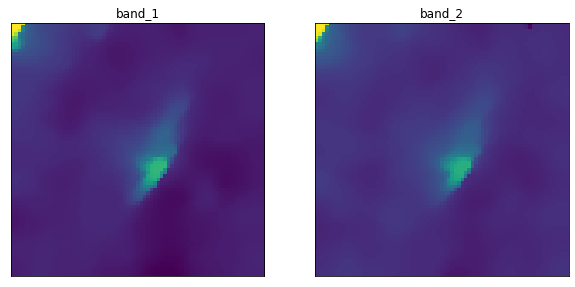

Index : 325


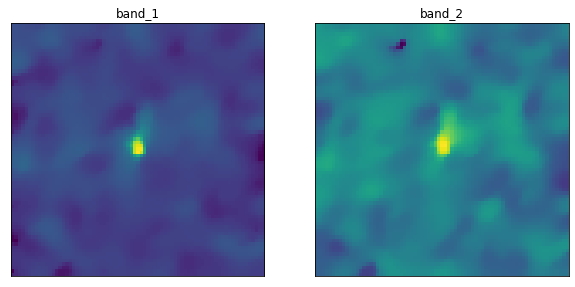

Index : 140


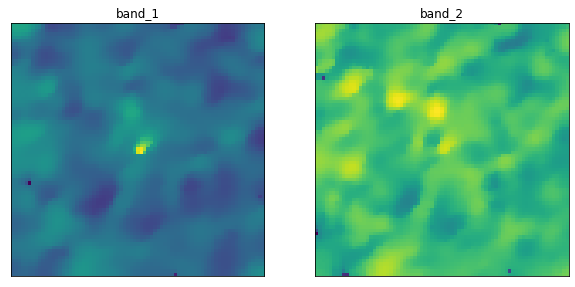

Index : 248


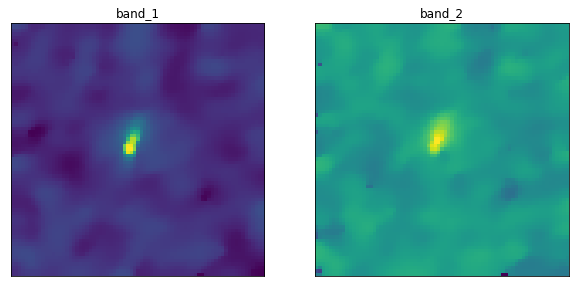

Index : 625


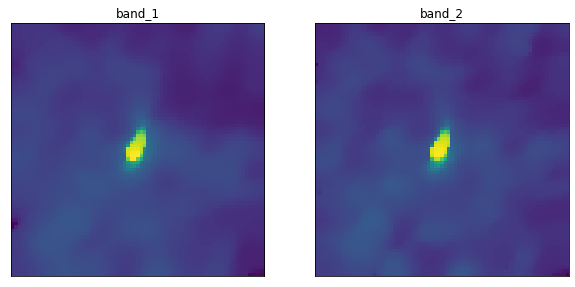

Index : 274


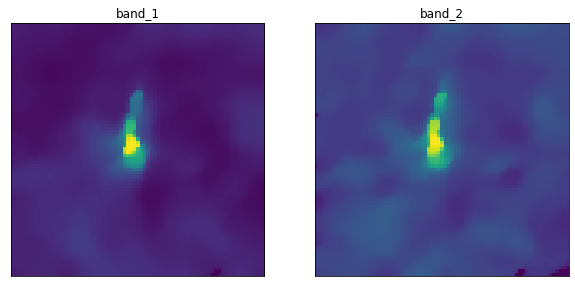

Index : 522


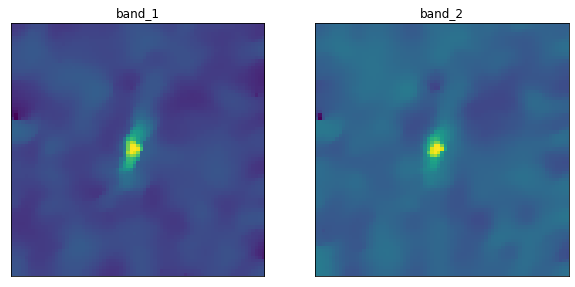

--- Boats predicted as Icebergs ---
Index : 936


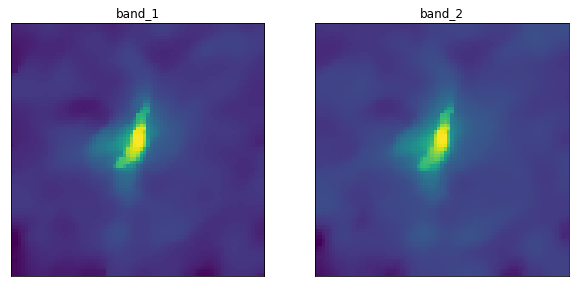

Index : 1148


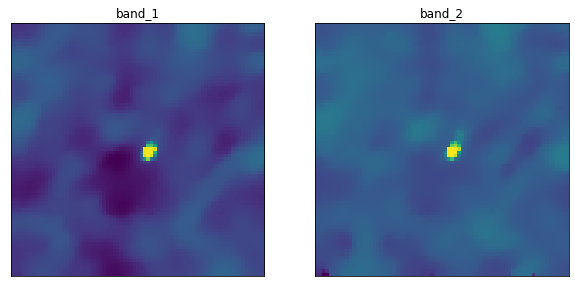

Index : 1043


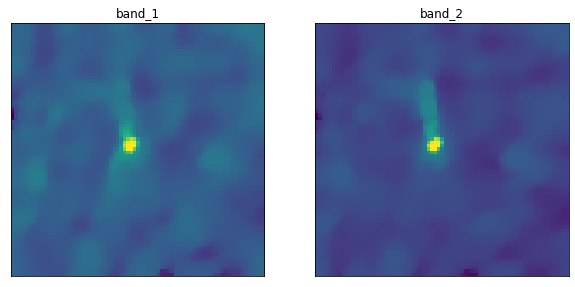

Index : 1082


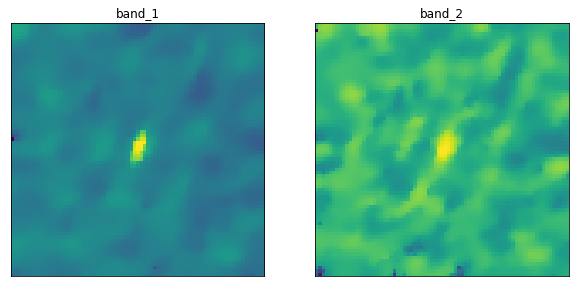

Index : 1384


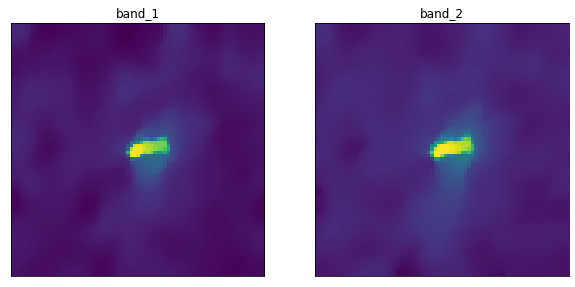

Index : 808


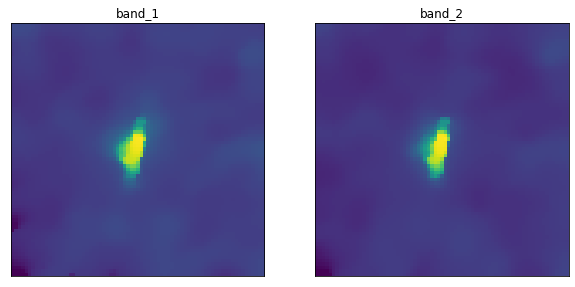

Index : 505


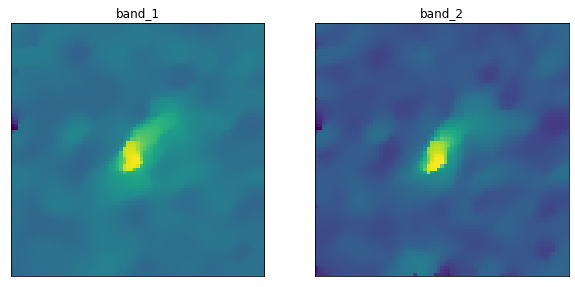

Index : 1013


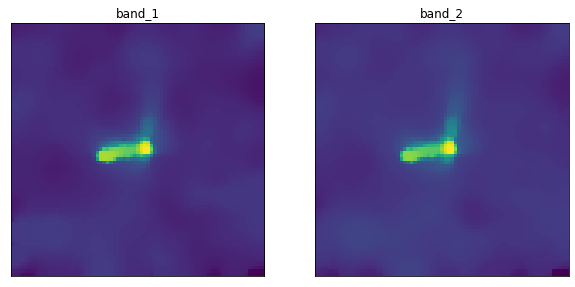

Index : 97


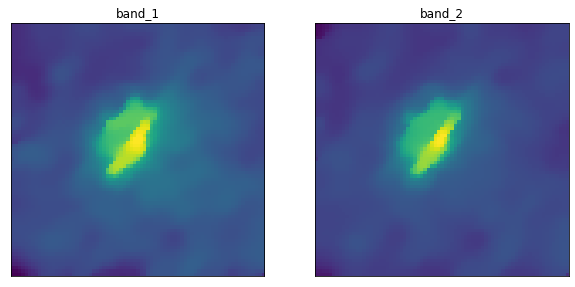

Index : 1214


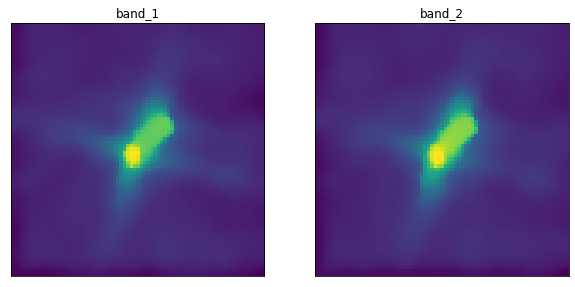

In [38]:
er.plot_mistakes(nb_samples = 10)

## On PCA data only

In [39]:
# Applying a PCA and saving for differents PCs

# I could have used a pipeline...
def get_pca_df(df, X, pcs):
  X_std = StandardScaler().fit_transform(X)
  pca = PCA(pcs).fit(X_std)
  res = pd.DataFrame(pca.transform(X_std),columns=['PC%s' % _ for _ in range(pcs)], index=df.index)
  res = res.join(df['is_iceberg'])
  res = res.dropna()
  return res

In [40]:
pca_5 = get_pca_df(df, naive_base_pretreated, 5)
pca_10 = get_pca_df(df, naive_base_pretreated, 10)
pca_20 = get_pca_df(df, naive_base_pretreated, 20)
pca_50 = get_pca_df(df, naive_base_pretreated, 50)
pca_100 = get_pca_df(df, naive_base_pretreated, 100)
pca_200 = get_pca_df(df, naive_base_pretreated, 200)
pca_500 = get_pca_df(df, naive_base_pretreated, 500)

In [41]:
pca_5

PC0        PC1        PC2        PC3        PC4  is_iceberg
486   -58.560469 -18.687751  -4.375629 -18.261208  -7.505827           0
760   -75.509121 -15.812607  -4.872814  -5.673984  -2.222319           1
1502  114.173050  19.607882  28.220128  -0.327816  -1.113465           1
682   -85.967157  28.026436 -12.495365 -14.401733   2.698880           1
1324   74.345651 -13.916493  -8.358526  -8.646224   4.090629           1
...          ...        ...        ...        ...        ...         ...
23     76.974630  -2.173236   1.965174  18.696266  -4.272570           1
539  -105.755674   2.609222  48.636862   6.221361 -29.190497           0
142   149.820572 -34.906577   2.240313  -8.553021   0.633777           0
5     -64.921276  13.788227  24.818318  -9.945644  -5.236987           1
791   -28.567637  -7.537303 -10.432106  -9.540679  -2.345999           0

[1283 rows x 6 columns]

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.703
--- Cross Validation Report ---
Mean accuracy score 0.719 with std 0.061
Mean f1 score 0.694 with std 0.07
Mean precision score 0.716 with std 0.076
Mean recall score 0.678 with std 0.089
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.748
 f1 : 0.718
 precision : 0.798
 recall : 0.652
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 4} with f1 score 0.718
--- Cross Validation Report ---
Mean accuracy score 0.751 with std 0.056
Mean f1 score 0.73 with std 0.065
Mean precision score 0.742 with std 0.053
Mean recall score 0.72 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.745
 f1 : 0.723
 precision : 0.775
 recall : 0.677
Confusion matrix for the test sample :
--- Grid Search Report 

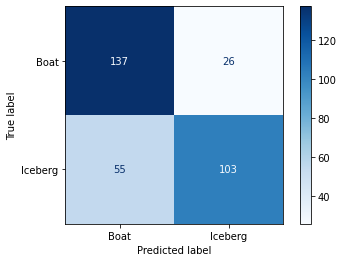

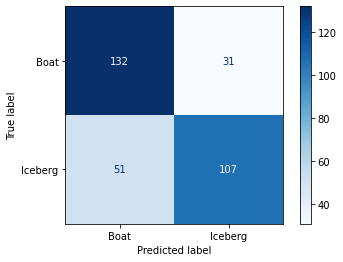

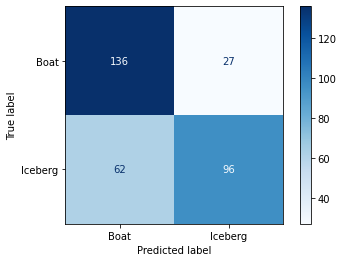

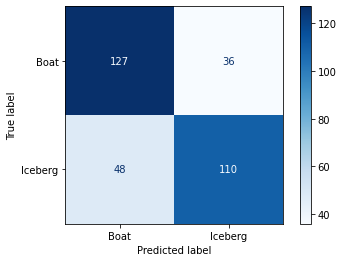

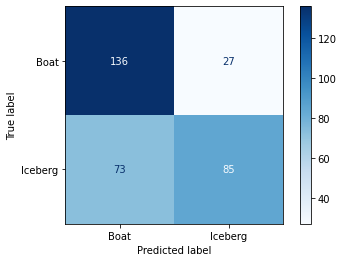

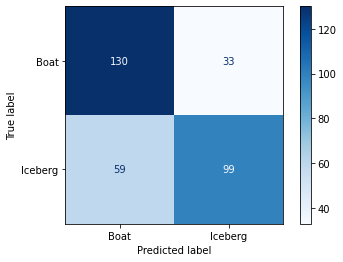

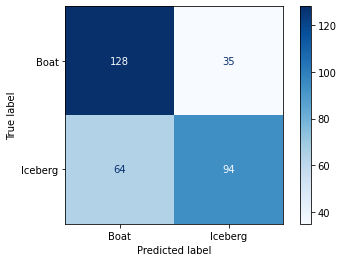

In [42]:
param_grid = [{
    'min_samples_leaf': [4],
    'max_features': [None]
}]
er.cv_cv = 3

train_scores = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores.append(er.best_scores_t)

In [43]:
train_scores

[{'accuracy': 0.719, 'f1': 0.694, 'precision': 0.716, 'recall': 0.678},
 {'accuracy': 0.751, 'f1': 0.73, 'precision': 0.742, 'recall': 0.72},
 {'accuracy': 0.751, 'f1': 0.734, 'precision': 0.738, 'recall': 0.738},
 {'accuracy': 0.736, 'f1': 0.718, 'precision': 0.724, 'recall': 0.718},
 {'accuracy': 0.738, 'f1': 0.714, 'precision': 0.739, 'recall': 0.693},
 {'accuracy': 0.718, 'f1': 0.688, 'precision': 0.713, 'recall': 0.669},
 {'accuracy': 0.685, 'f1': 0.658, 'precision': 0.672, 'recall': 0.647}]

In [44]:
x_plot = [5, 10, 20, 50, 100, 200, 500]
y_plot1 = [a.get('accuracy') for a in train_scores]
y_plot2 = [a.get('f1') for a in train_scores]
y_plot3 = [a.get('precision') for a in train_scores]
y_plot4 = [a.get('recall') for a in train_scores]

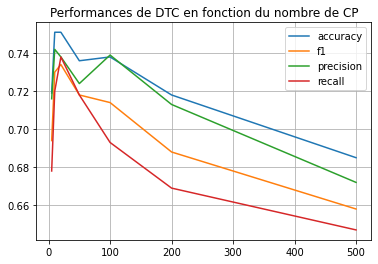

In [45]:
plt.plot(x_plot, y_plot1, label='accuracy')
plt.plot(x_plot, y_plot2, label='f1')
plt.plot(x_plot, y_plot3, label='precision')
plt.plot(x_plot, y_plot4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.745
--- Cross Validation Report ---
Mean accuracy score 0.773 with std 0.046
Mean f1 score 0.748 with std 0.058
Mean precision score 0.782 with std 0.052
Mean recall score 0.721 with std 0.085
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.773
 precision : 0.817
 recall : 0.734
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.752
--- Cross Validation Report ---
Mean accuracy score 0.784 with std 0.049
Mean f1 score 0.753 with std 0.062
Mean precision score 0.809 with std 0.049
Mean recall score 0.706 with std 0.083
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.791
 f1 : 0.767
 precision : 0.853
 recall : 0.696
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n

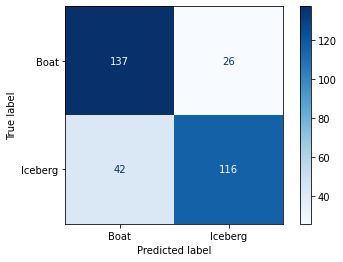

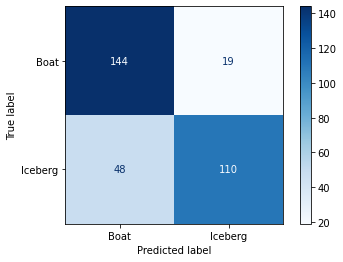

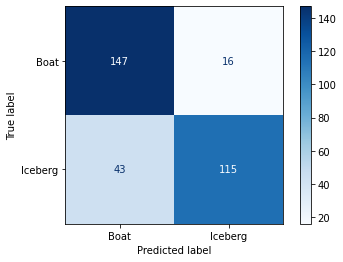

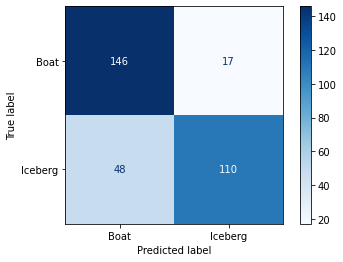

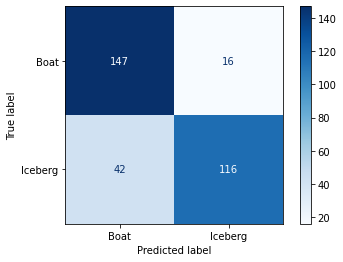

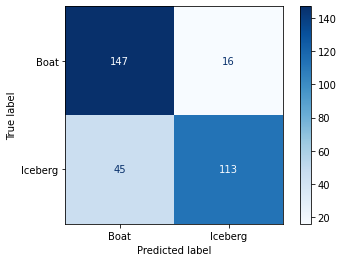

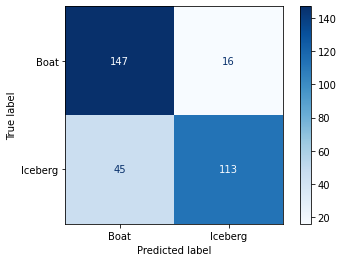

In [46]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [47]:
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

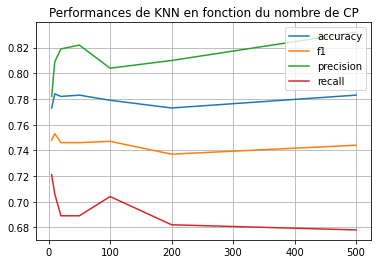

In [48]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

###C-support Vector


--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.786
--- Cross Validation Report ---
Mean accuracy score 0.789 with std 0.029
Mean f1 score 0.786 with std 0.032
Mean precision score 0.754 with std 0.034
Mean recall score 0.823 with std 0.061
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.81
 f1 : 0.805
 precision : 0.813
 recall : 0.797
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.804
--- Cross Validation Report ---
Mean accuracy score 0.803 with std 0.049
Mean f1 score 0.795 with std 0.054
Mean precision score 0.779 with std 0.055
Mean recall score 0.815 with std 0.076
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.816
 f1 : 0.807
 precision : 0.837
 recall : 0.778
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 1.0} with f1 score 0.809
--- Cross Validation Report ---
Mean acc

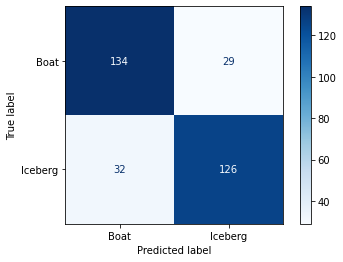

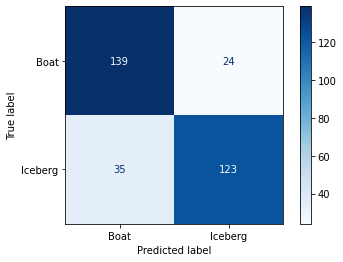

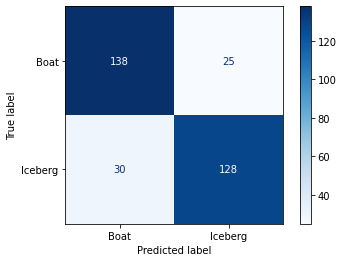

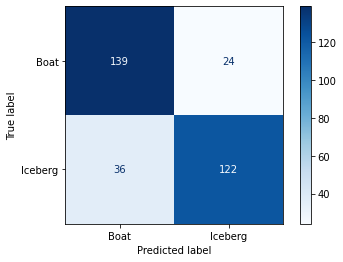

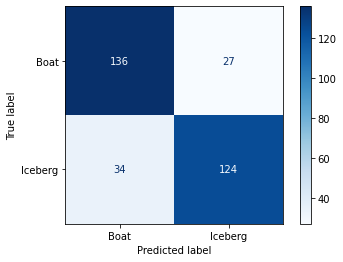

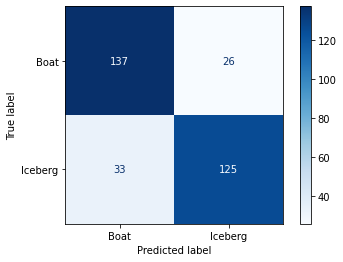

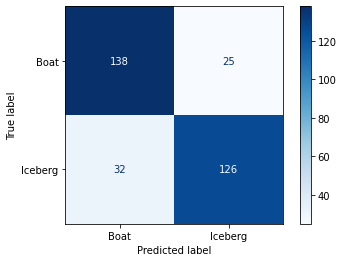

In [49]:
param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]


er.cv_cv = 3
train_scores_svc= []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)
  train_scores_svc.append(er.best_scores_t)

In [50]:
y_p1 = [a.get('accuracy') for a in train_scores_svc]
y_p2 = [a.get('f1') for a in train_scores_svc]
y_p3 = [a.get('precision') for a in train_scores_svc]
y_p4 = [a.get('recall') for a in train_scores_svc]

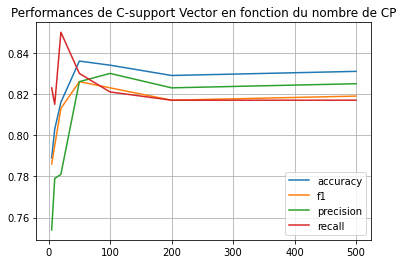

In [51]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de C-support Vector en fonction du nombre de CP')
plt.grid(True)
plt.show()

--- Icebergs predicted as boats ---
Index : 971


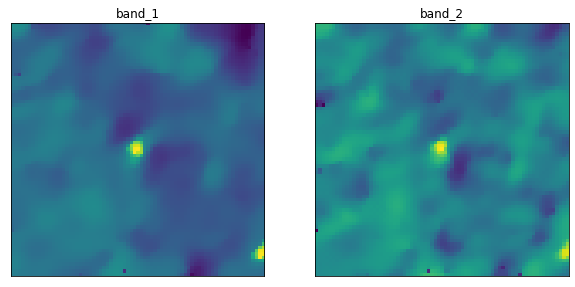

Index : 1073


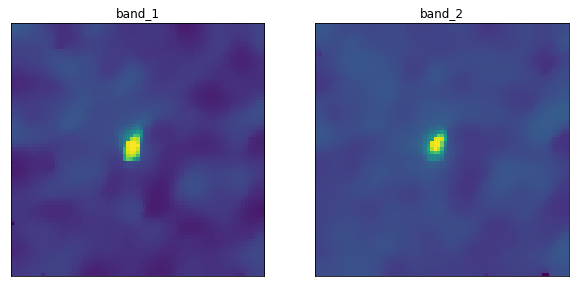

Index : 1378


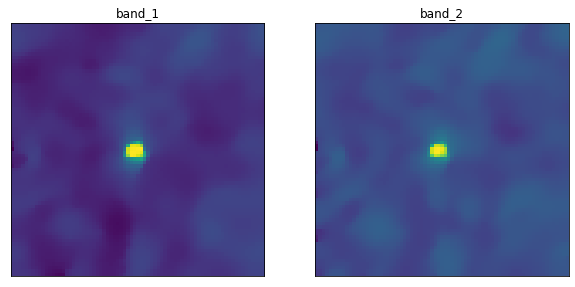

Index : 962


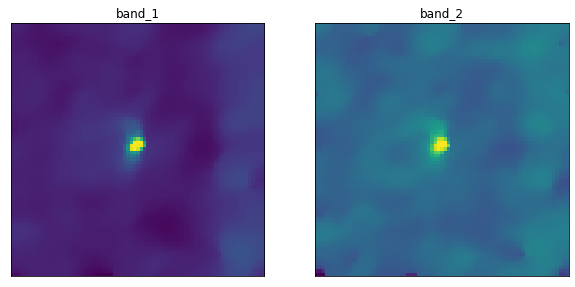

Index : 259


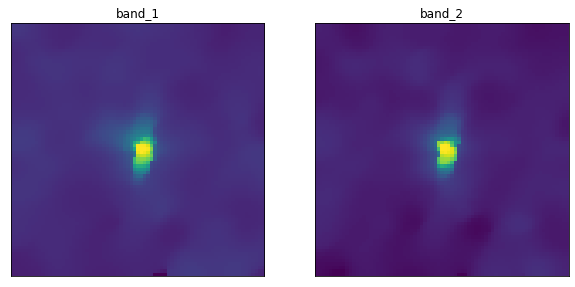

Index : 1077


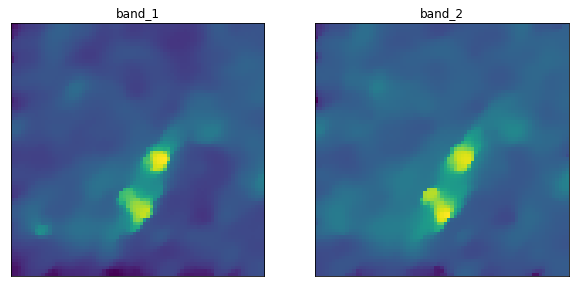

Index : 722


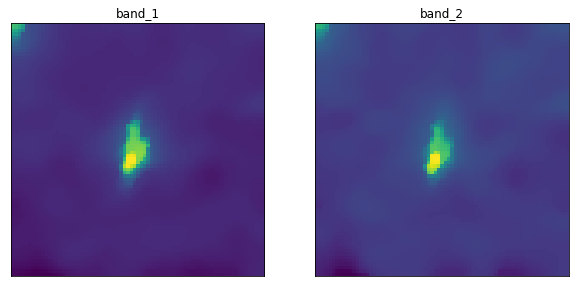

Index : 628


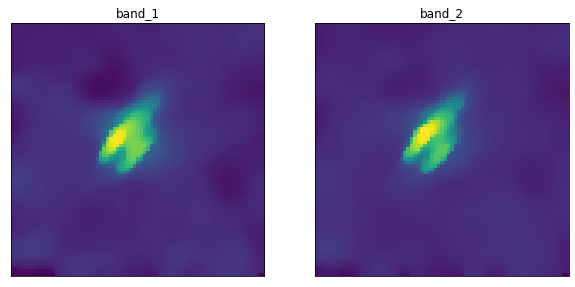

Index : 547


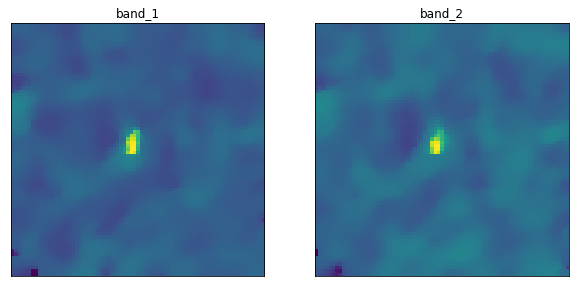

Index : 38


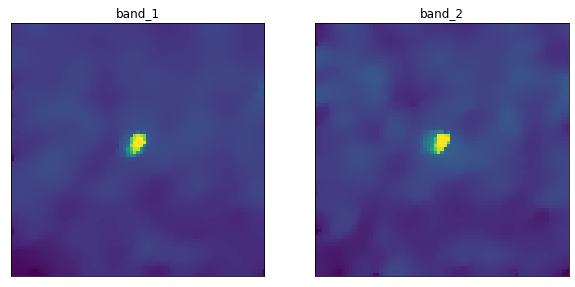

--- Boats predicted as Icebergs ---
Index : 903


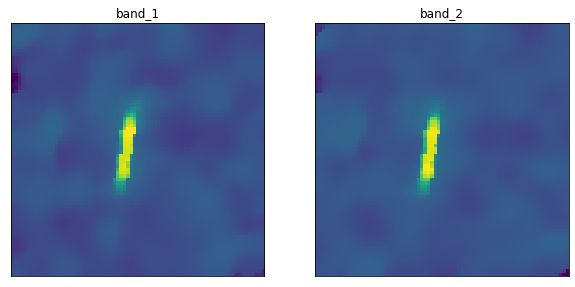

Index : 1214


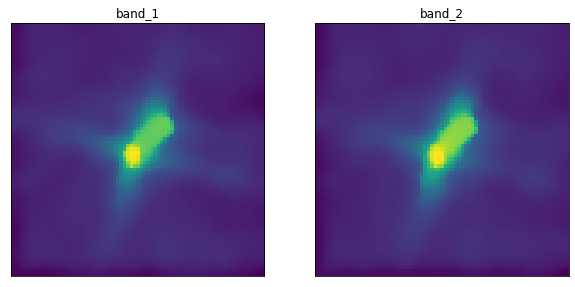

Index : 204


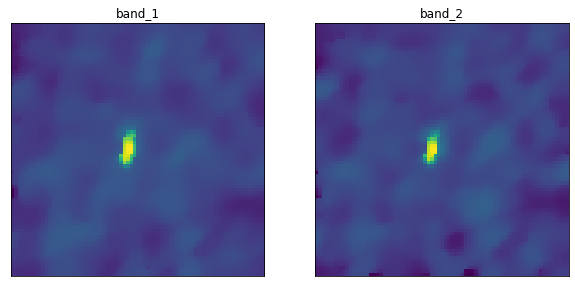

Index : 1034


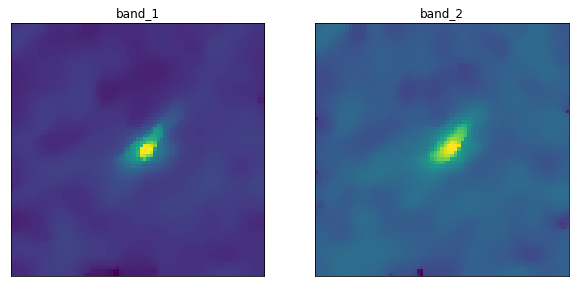

Index : 133


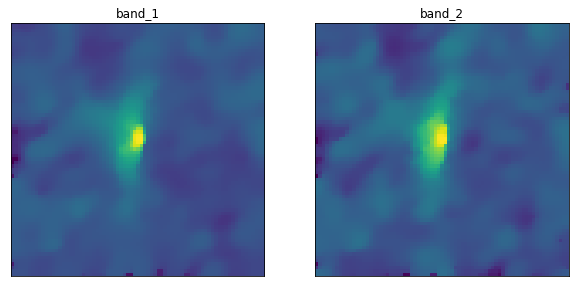

Index : 1434


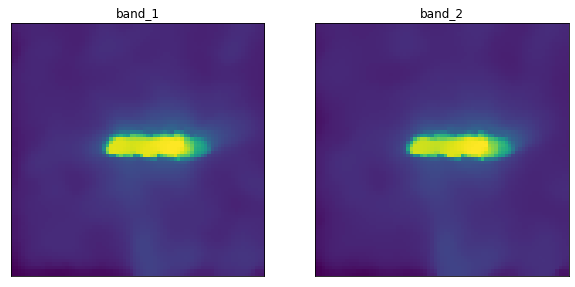

Index : 1246


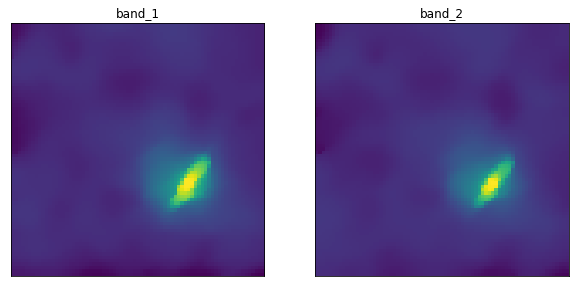

Index : 1043


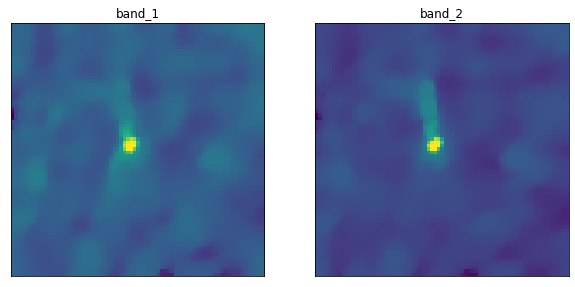

Index : 1228


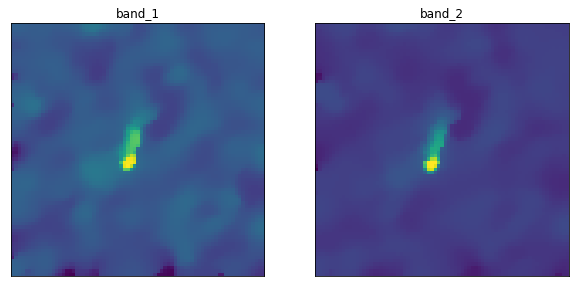

Index : 655


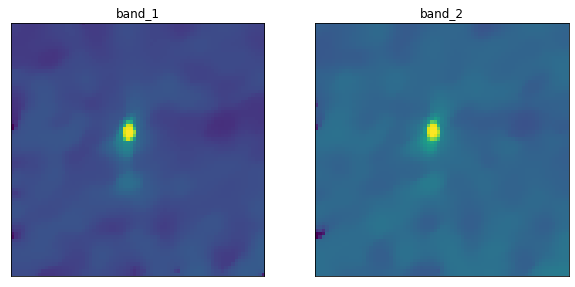

In [52]:
er.plot_mistakes(nb_samples = 10)

###Gaussian Process

--- Cross Validation Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Mean accuracy score 0.736 with std 0.11
Mean f1 score 0.624 with std 0.314
Mean precision score 0.612 with std 0.309
Mean recall score 0.639 with std 0.321
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.807
 f1 : 0.797
 precision : 0.824
 recall : 0.772
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.797 with std 0.048
Mean f1 score 0.786 with std 0.056
Mean precision score 0.781 with std 0.056
Mean recall score 0.797 with std 0.089
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.813
 f1 : 0.803
 precision : 0.836
 recall : 0.772
Confusion matrix for the test sample :
--- Cross Validation Report ---


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metri

Mean accuracy score 0.581 with std 0.106
Mean f1 score 0.153 with std 0.306
Mean precision score 0.164 with std 0.33
Mean recall score 0.144 with std 0.289
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.798
 f1 : 0.784
 precision : 0.825
 recall : 0.747
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.751 with std 0.041
Mean f1 score 0.728 with std 0.052
Mean precision score 0.746 with std 0.049
Mean recall score 0.717 with std 0.087
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.788
 f1 : 0.775
 precision : 0.812
 recall : 0.741
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.738 with std 0.051
Mean f1 score 0.712 with std 0.06
Mean precision score 0.738 with std 0.065
Mean recall score 0.695 with std 0.091
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.782
 f1 : 0.768
 precision : 0.806
 recall : 0.734
Confusion matrix for the t

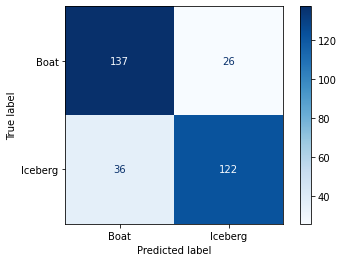

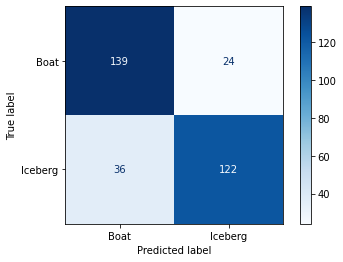

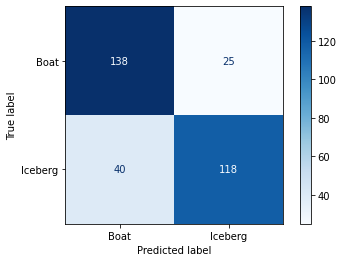

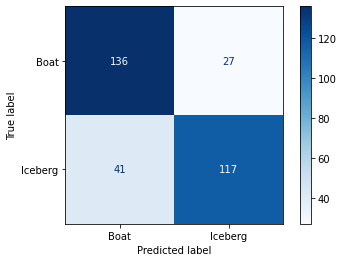

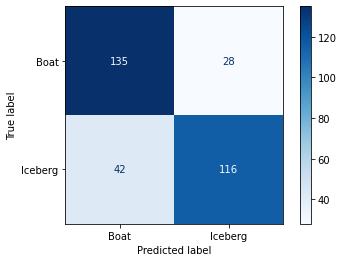

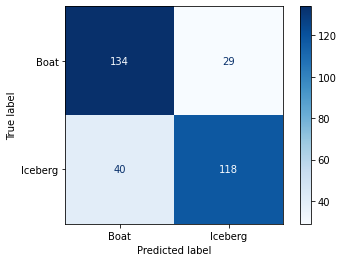

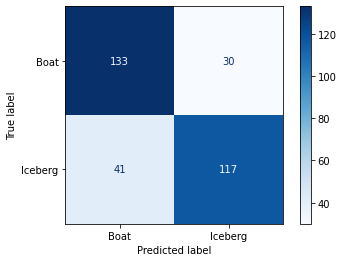

In [53]:
train_scores_GP = []
for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))
  train_scores_GP.append(er.best_scores_t)

In [54]:
y_p1 = [a.get('accuracy') for a in train_scores_GP]
y_p2 = [a.get('f1') for a in train_scores_GP]
y_p3 = [a.get('precision') for a in train_scores_GP]
y_p4 = [a.get('recall') for a in train_scores_GP]

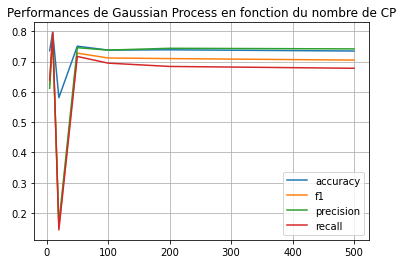

In [55]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Gaussian Process en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 8, 'n_estimators': 100} with f1 score 0.784
--- Cross Validation Report ---
Mean accuracy score 0.791 with std 0.04
Mean f1 score 0.783 with std 0.039
Mean precision score 0.771 with std 0.057
Mean recall score 0.799 with std 0.047
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.779
 f1 : 0.766
 precision : 0.8
 recall : 0.734
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 100} with f1 score 0.799
--- Cross Validation Report ---
Mean accuracy score 0.806 with std 0.049
Mean f1 score 0.796 with std 0.054
Mean precision score 0.785 with std 0.053
Mean recall score 0.813 with std 0.081
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.816
 f1 : 0.804
 precision : 0.846
 recall : 0.766
Confusion matrix

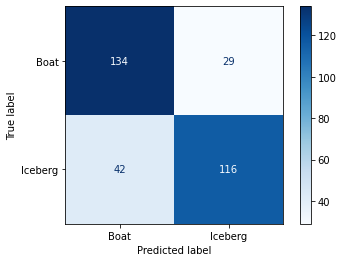

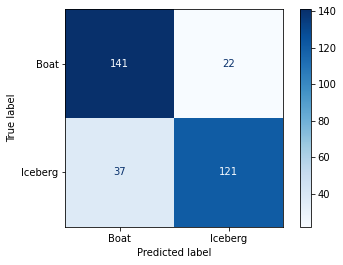

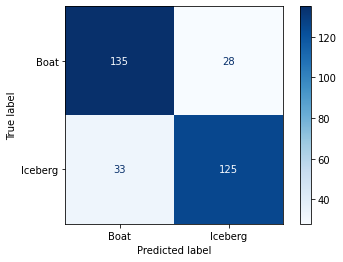

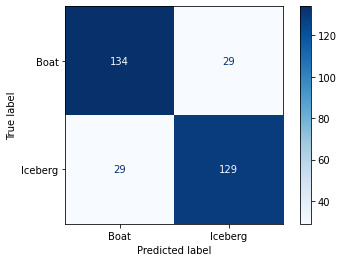

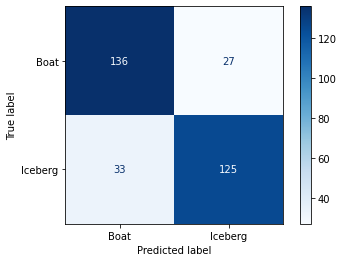

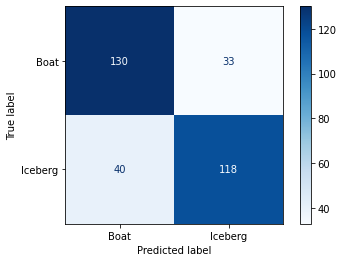

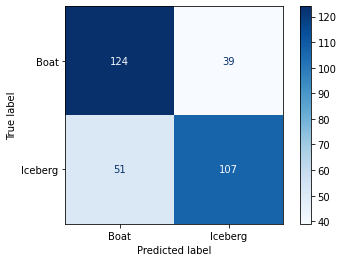

In [56]:
param_grid = [{
    'min_samples_leaf': range(2,12,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]

er.cv_cv = 3
train_scores_RF= []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(RandomForestClassifier(), param_grid)
  train_scores_RF.append(er.best_scores_t)

In [57]:
y_p1 = [a.get('accuracy') for a in train_scores_RF]
y_p2 = [a.get('f1') for a in train_scores_RF]
y_p3 = [a.get('precision') for a in train_scores_RF]
y_p4 = [a.get('recall') for a in train_scores_RF]

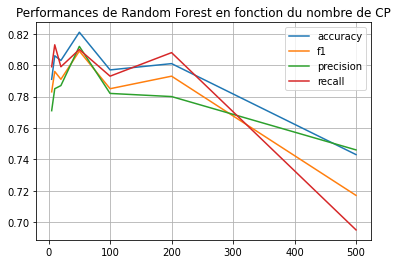

In [58]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Random Forest en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Neural Test

--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.005, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.695
--- Cross Validation Report ---
Mean accuracy score 0.713 with std 0.019
Mean f1 score 0.696 with std 0.023
Mean precision score 0.696 with std 0.031
Mean recall score 0.7 with std 0.054
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.769
 f1 : 0.755
 precision : 0.792
 recall : 0.722
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.729
--- Cross Validation Report ---
Mean accuracy score 0.732 with std 0.059
Mean f1 score 0.712 with std 0.059
Mean precision score 0.728 with std 0.08
Mean recall score 0.7 with std 0.06
--- Test Samp

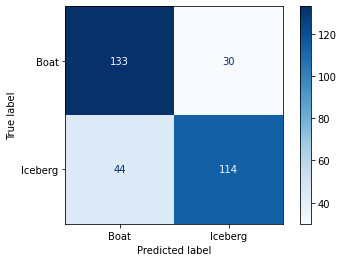

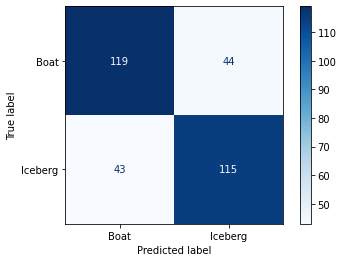

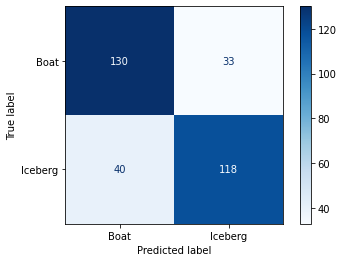

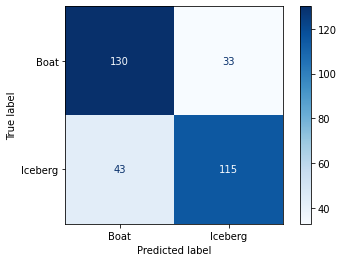

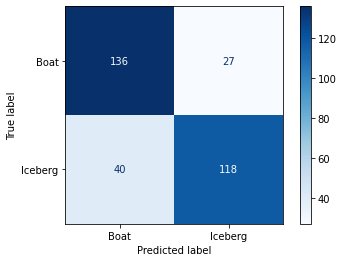

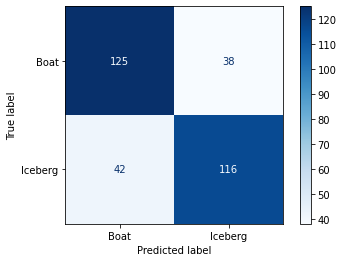

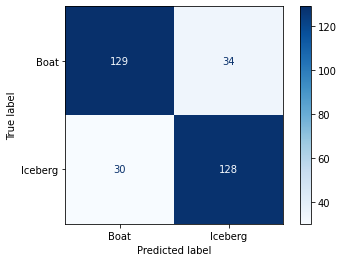

In [59]:
param_grid = [{'activation': ['tanh'],
               'alpha': [0.0001,0.005],
               'hidden_layer_sizes': [(150, 100, 50)],
               'learning_rate': ['adaptive'],
               'max_iter': [400],
               'solver': ['adam']}]

er.cv_cv = 3
train_scores_NeuralTest= []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(MLPClassifier(), param_grid)
  train_scores_NeuralTest.append(er.best_scores_t)

In [60]:
y_p1 = [a.get('accuracy') for a in train_scores_NeuralTest]
y_p2 = [a.get('f1') for a in train_scores_NeuralTest]
y_p3 = [a.get('precision') for a in train_scores_NeuralTest]
y_p4 = [a.get('recall') for a in train_scores_NeuralTest]

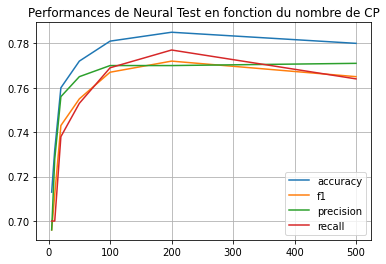

In [61]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Neural Test en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.751 with std 0.06
Mean f1 score 0.744 with std 0.058
Mean precision score 0.726 with std 0.072
Mean recall score 0.766 with std 0.061
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.766
 f1 : 0.751
 precision : 0.79
 recall : 0.715
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.771 with std 0.043
Mean f1 score 0.757 with std 0.049
Mean precision score 0.757 with std 0.048
Mean recall score 0.759 with std 0.07
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.785
 f1 : 0.768
 precision : 0.82
 recall : 0.722
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.763 with std 0.037
Mean f1 score 0.746 with std 0.036
Mean precision score 0.759 with std 0.059
Mean recall score 0.74 with std 0.059
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.81
 f1 : 0.797
 precision : 0.839
 recall : 0.75

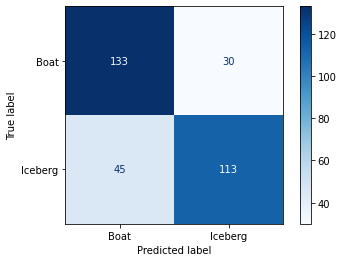

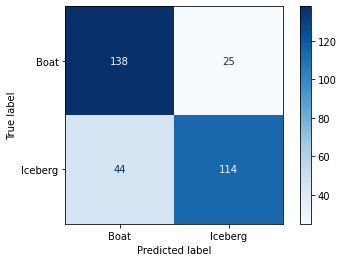

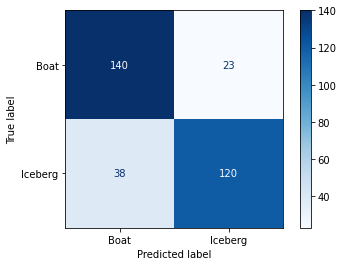

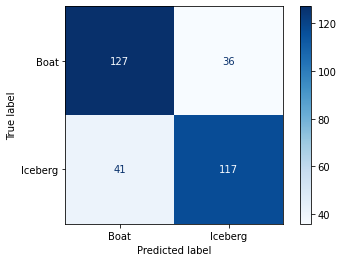

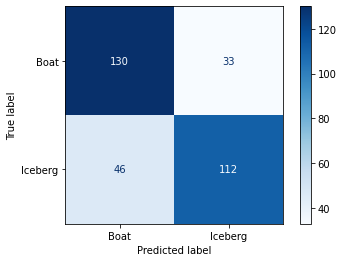

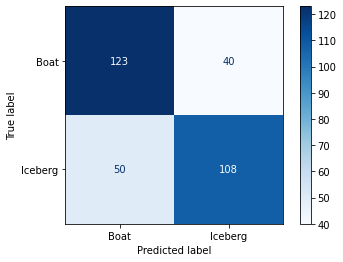

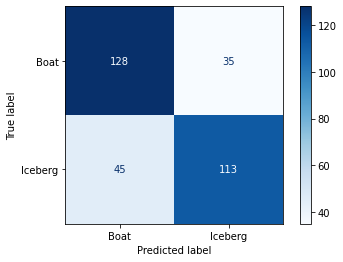

In [62]:
er.cv_cv = 3

train_scores_Adaboost = []

for dtset in [pca_5, pca_10, pca_20, pca_50, pca_100, pca_200, pca_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(AdaBoostClassifier())
  train_scores_Adaboost.append(er.best_scores_t)

In [63]:
y_p1 = [a.get('accuracy') for a in train_scores_Adaboost]
y_p2 = [a.get('f1') for a in train_scores_Adaboost]
y_p3 = [a.get('precision') for a in train_scores_Adaboost]
y_p4 = [a.get('recall') for a in train_scores_Adaboost]

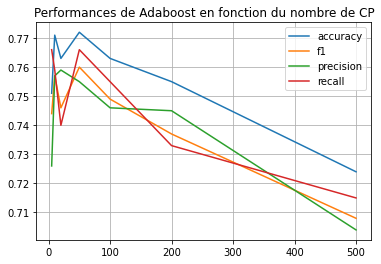

In [64]:
plt.plot(x_plot, y_p1, label='accuracy')
plt.plot(x_plot, y_p2, label='f1')
plt.plot(x_plot, y_p3, label='precision')
plt.plot(x_plot, y_p4, label='recall')
plt.legend()
plt.title('Performances de Adaboost en fonction du nombre de CP')
plt.grid(True)
plt.show()

## On PCA and statistics

In [65]:
df_stats = df_stats.loc[:,~df_stats.columns.duplicated()]
df_5 = df_stats.join(pca_5.drop('is_iceberg',axis=1)).dropna()
df_20 = df_stats.join(pca_20.drop('is_iceberg',axis=1)).dropna()
df_50 = df_stats.join(pca_50.drop('is_iceberg',axis=1)).dropna()
df_100 = df_stats.join(pca_100.drop('is_iceberg',axis=1)).dropna()

### DecisionTreeClassifier

--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.813
--- Cross Validation Report ---
Mean accuracy score 0.815 with std 0.05
Mean f1 score 0.816 with std 0.057
Mean precision score 0.836 with std 0.034
Mean recall score 0.802 with std 0.092
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.807
 f1 : 0.804
 precision : 0.807
 recall : 0.801
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for DecisionTreeClassifier() :
 {'max_features': None, 'min_samples_leaf': 10} with f1 score 0.787
--- Cross Validation Report ---
Mean accuracy score 0.803 with std 0.032
Mean f1 score 0.808 with std 0.038
Mean precision score 0.816 with std 0.03
Mean recall score 0.804 with std 0.071
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.793
 f1 : 0.797
 precision : 0.774
 recall : 0.822
Confusion matrix for the test sample :
--- Grid Search Repo

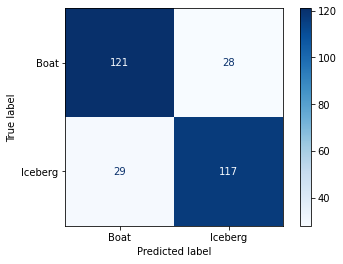

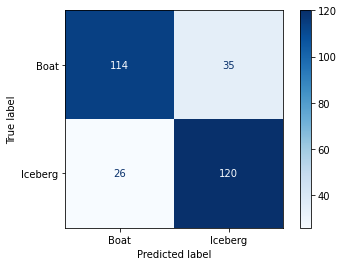

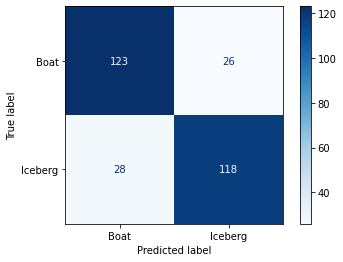

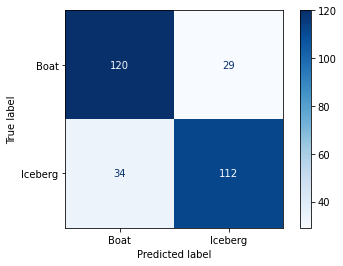

In [66]:
train_scores_mix = []

param_grid = [{
    'min_samples_leaf': [10],
    'max_features': [None]
}]

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop(['is_iceberg'],axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(DecisionTreeClassifier(), param_grid)
  train_scores_mix.append(er.best_scores_t)

In [67]:
x_p = [5, 20, 50, 100]
y1 = [a.get('accuracy') for a in train_scores_mix]
y2 = [a.get('f1') for a in train_scores_mix]
y3 = [a.get('precision') for a in train_scores_mix]
y4 = [a.get('recall') for a in train_scores_mix]

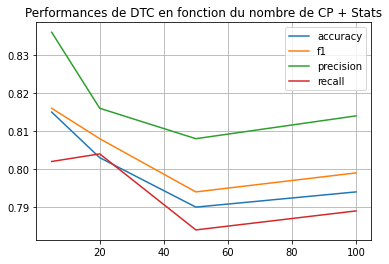

In [68]:
plt.plot(x_p, y1, label='accuracy')
plt.plot(x_p, y2, label='f1')
plt.plot(x_p, y3, label='precision')
plt.plot(x_p, y4, label='recall')
plt.legend()
plt.title('Performances de DTC en fonction du nombre de CP + Stats')
plt.grid(True)
plt.show()

###KNN

--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 16} with f1 score 0.811
--- Cross Validation Report ---
Mean accuracy score 0.803 with std 0.028
Mean f1 score 0.809 with std 0.031
Mean precision score 0.812 with std 0.023
Mean recall score 0.808 with std 0.049
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.797
 f1 : 0.801
 precision : 0.776
 recall : 0.829
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_neighbors': 12} with f1 score 0.821
--- Cross Validation Report ---
Mean accuracy score 0.814 with std 0.02
Mean f1 score 0.82 with std 0.021
Mean precision score 0.825 with std 0.02
Mean recall score 0.817 with std 0.037
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.783
 f1 : 0.785
 precision : 0.77
 recall : 0.801
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for KNeighborsClassifier() :
 {'n_nei

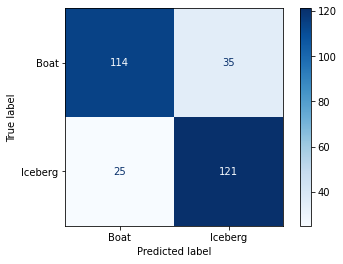

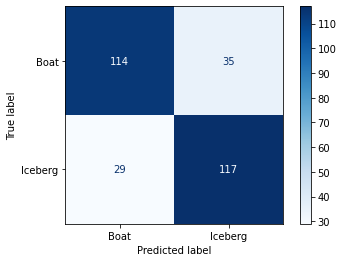

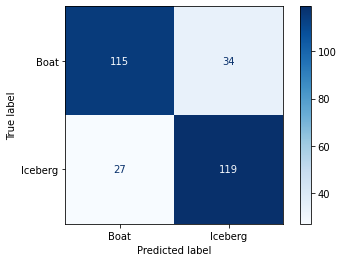

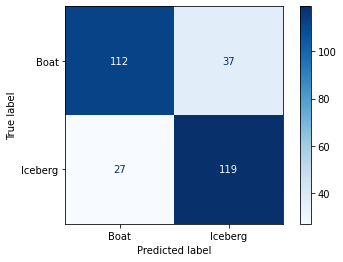

In [69]:
param_grid_knn = [{
    'n_neighbors': range(4,20,4)
}]
er.cv_cv = 3

train_scores_knn = []
for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(KNeighborsClassifier(), param_grid_knn)
  train_scores_knn.append(er.best_scores_t)

In [70]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_knn]
y_p2 = [a.get('f1') for a in train_scores_knn]
y_p3 = [a.get('precision') for a in train_scores_knn]
y_p4 = [a.get('recall') for a in train_scores_knn]

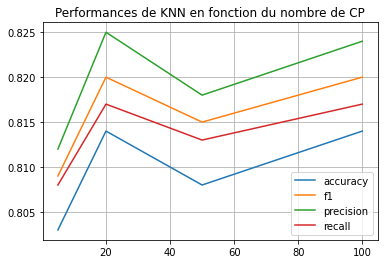

In [71]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de KNN en fonction du nombre de CP')
plt.grid(True)
plt.show()

###C-support Vector


--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.707
--- Cross Validation Report ---
Mean accuracy score 0.547 with std 0.075
Mean f1 score 0.695 with std 0.029
Mean precision score 0.546 with std 0.073
Mean recall score 0.98 with std 0.06
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.713
--- Cross Validation Report ---
Mean accuracy score 0.551 with std 0.089
Mean f1 score 0.7 with std 0.042
Mean precision score 0.55 with std 0.086
Mean recall score 0.984 with std 0.047
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.495
 f1 : 0.662
 precision : 0.495
 recall : 1.0
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for SVC() :
 {'C': 10.0} with f1 score 0.715
--- Cross Validation Report ---
Mean accuracy s

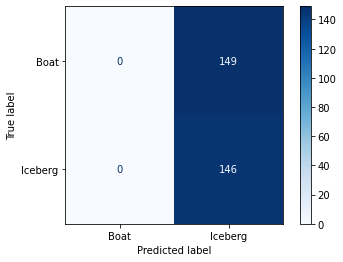

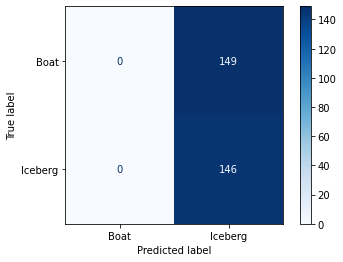

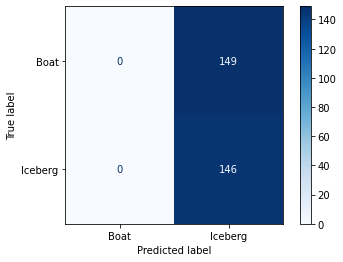

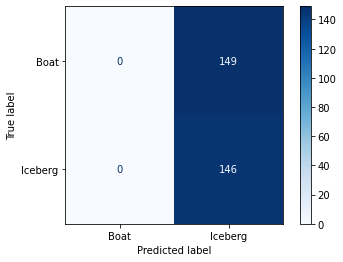

In [72]:
from sklearn.svm import SVC


param_grid = [{
    'C': np.logspace(-3, 1, 5)
}]

er.cv_cv = 3

train_scores_SVC = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(SVC(kernel='rbf', gamma='scale'), param_grid)
  train_scores_SVC.append(er.best_scores_t)

In [73]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_SVC]
y_p2 = [a.get('f1') for a in train_scores_SVC]
y_p3 = [a.get('precision') for a in train_scores_SVC]
y_p4 = [a.get('recall') for a in train_scores_SVC]

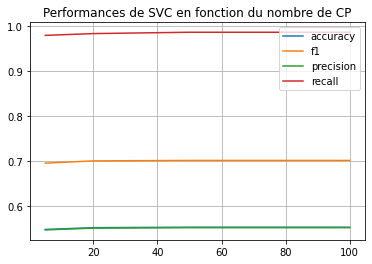

In [74]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de SVC en fonction du nombre de CP')
plt.grid(True)
plt.show()

### Gaussian Process

--- Cross Validation Report ---
Mean accuracy score 0.774 with std 0.029
Mean f1 score 0.793 with std 0.032
Mean precision score 0.758 with std 0.027
Mean recall score 0.834 with std 0.069
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.739
 f1 : 0.746
 precision : 0.72
 recall : 0.774
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.779 with std 0.039
Mean f1 score 0.787 with std 0.038
Mean precision score 0.789 with std 0.039
Mean recall score 0.787 with std 0.057
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.773
 f1 : 0.768
 precision : 0.776
 recall : 0.76
Confusion matrix for the test sample :
--- Cross Validation Report ---
Mean accuracy score 0.77 with std 0.037
Mean f1 score 0.774 with std 0.039
Mean precision score 0.791 with std 0.039
Mean recall score 0.76 with std 0.063
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.766
 f1 : 0.76
 precision : 0.773
 recall : 0.7

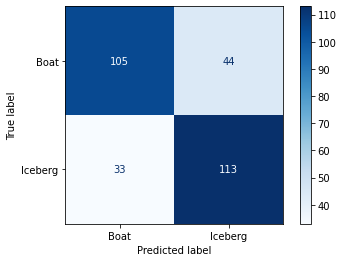

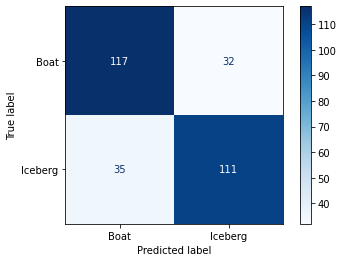

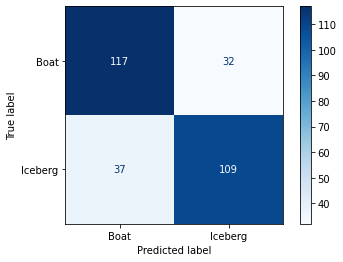

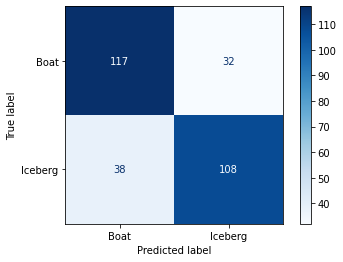

In [75]:
er.cv_cv = 3

train_scores_GP = []

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(GaussianProcessClassifier(1.0 * RBF(2.0)))
  train_scores_GP.append(er.best_scores_t)


In [76]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_GP]
y_p2 = [a.get('f1') for a in train_scores_GP]
y_p3 = [a.get('precision') for a in train_scores_GP]
y_p4 = [a.get('recall') for a in train_scores_GP]

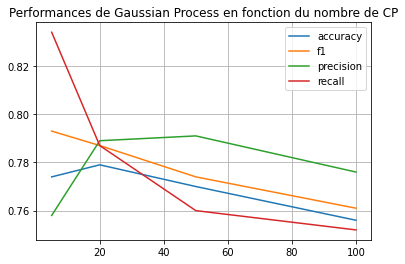

In [77]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Gaussian Process en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Random Forest

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 3, 'n_estimators': 100} with f1 score 0.858
--- Cross Validation Report ---
Mean accuracy score 0.853 with std 0.028
Mean f1 score 0.862 with std 0.028
Mean precision score 0.841 with std 0.028
Mean recall score 0.887 with std 0.055
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.858
 f1 : 0.86
 precision : 0.838
 recall : 0.884
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 1033


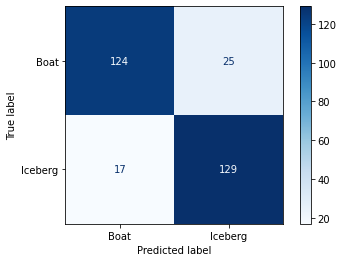

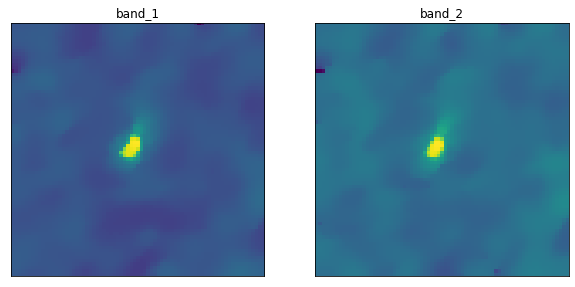

Index : 530


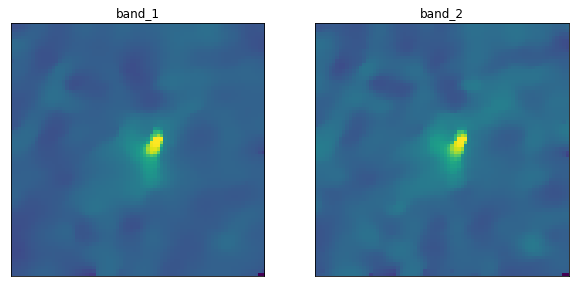

Index : 705


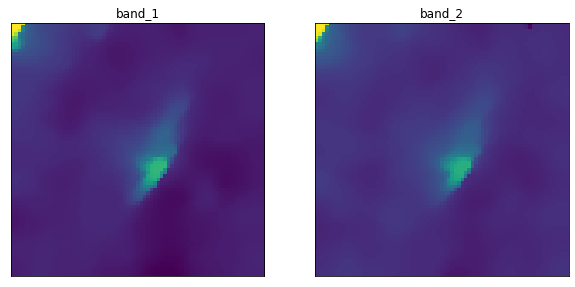

Index : 1336


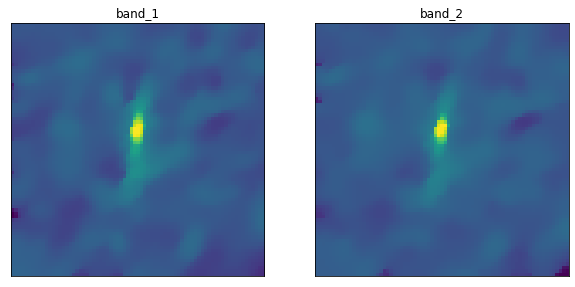

Index : 330


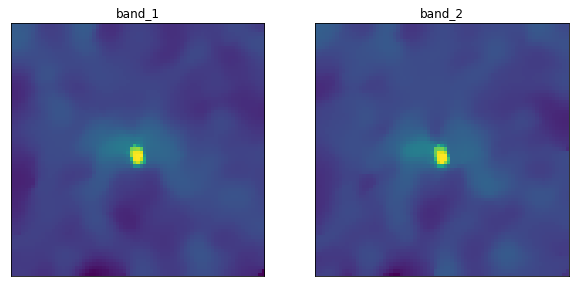

Index : 502


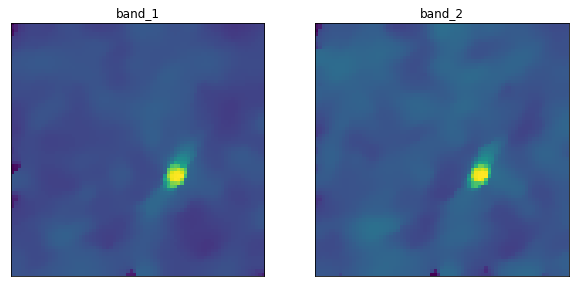

Index : 140


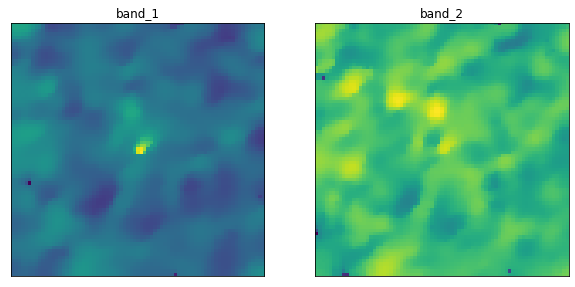

Index : 1160


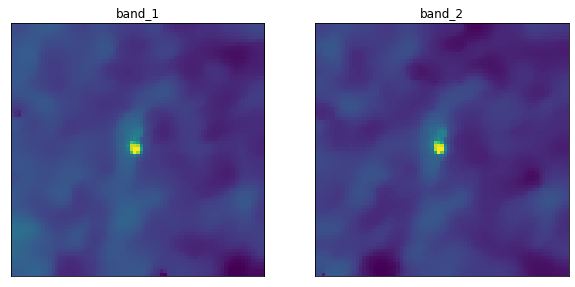

Index : 962


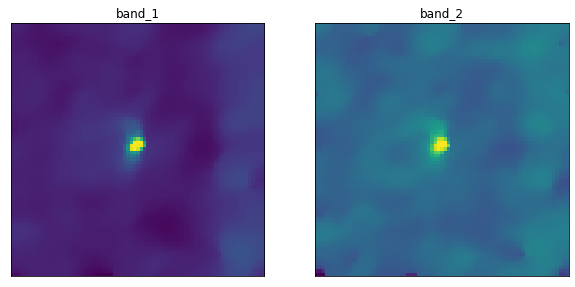

Index : 889


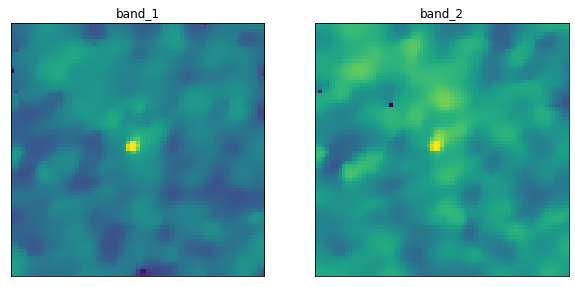

--- Boats predicted as Icebergs ---
Index : 1307


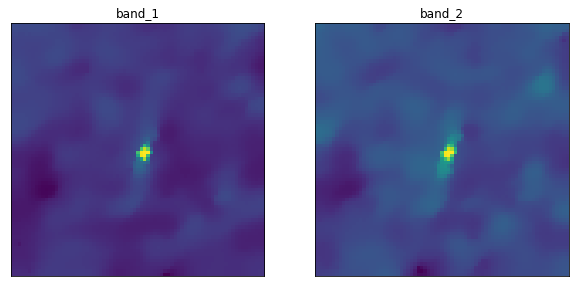

Index : 309


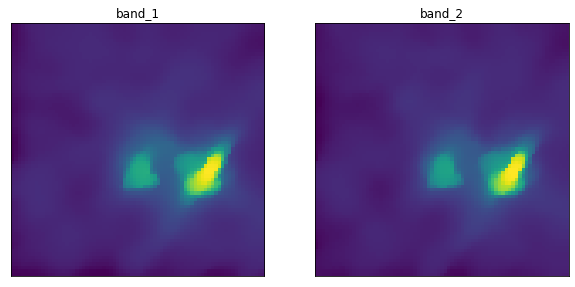

Index : 1051


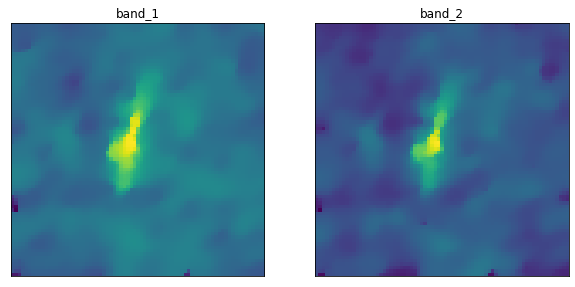

Index : 458


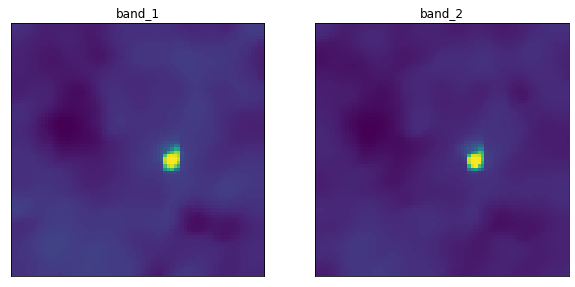

Index : 1573


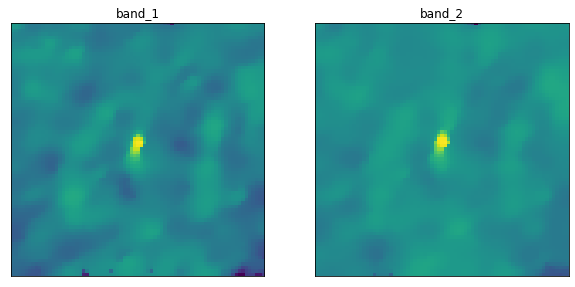

Index : 442


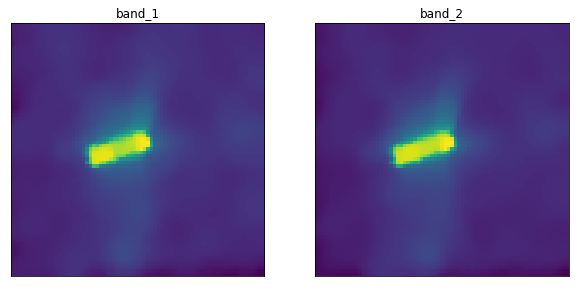

Index : 351


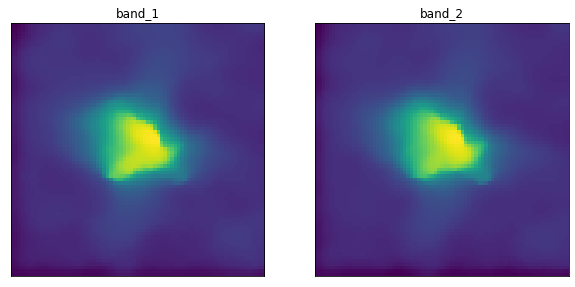

Index : 1543


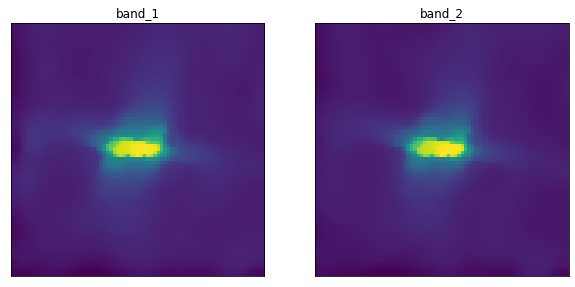

Index : 238


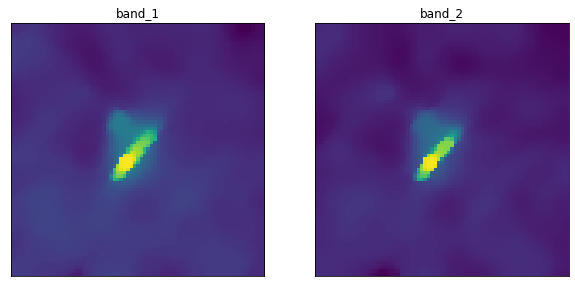

Index : 472


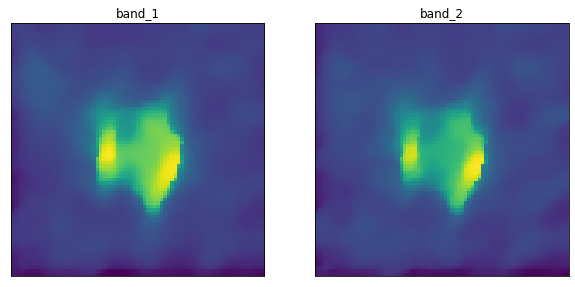

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100} with f1 score 0.868
--- Cross Validation Report ---
Mean accuracy score 0.857 with std 0.021
Mean f1 score 0.865 with std 0.022
Mean precision score 0.851 with std 0.027
Mean recall score 0.882 with std 0.051
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.834
 f1 : 0.839
 precision : 0.805
 recall : 0.877
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 502


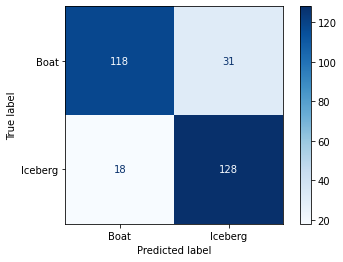

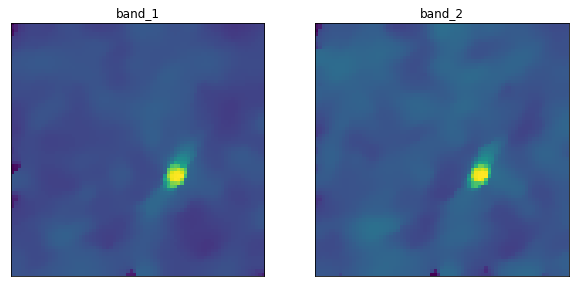

Index : 498


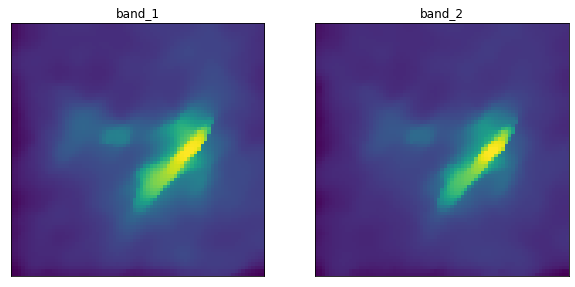

Index : 705


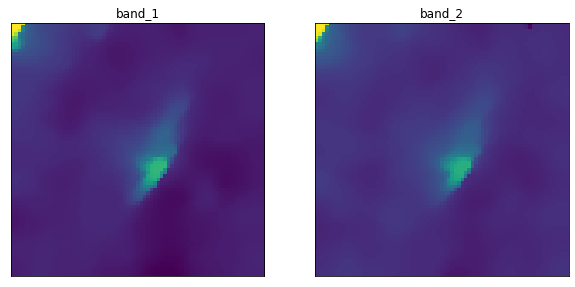

Index : 257


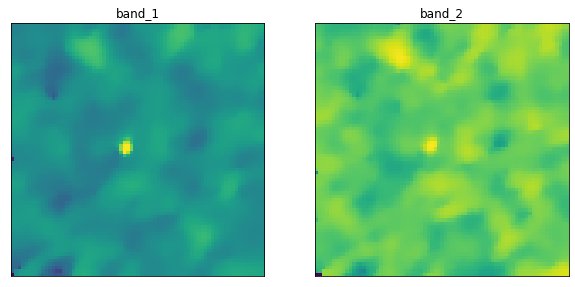

Index : 1160


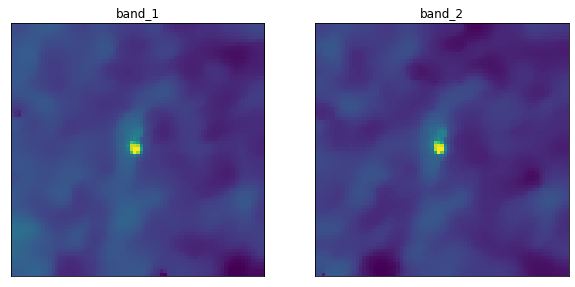

Index : 991


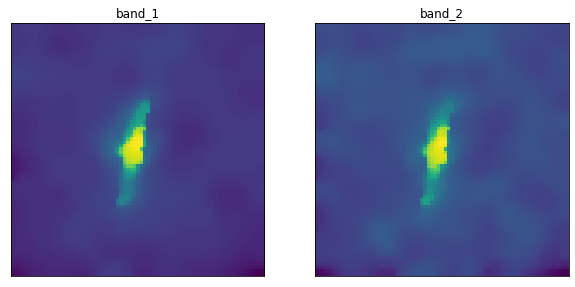

Index : 956


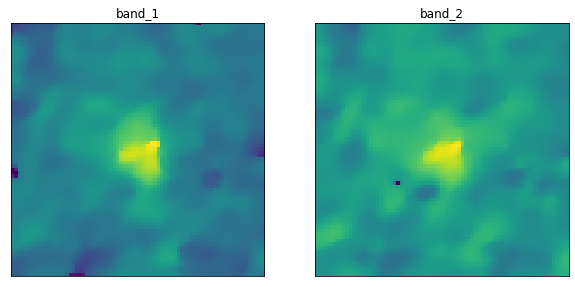

Index : 889


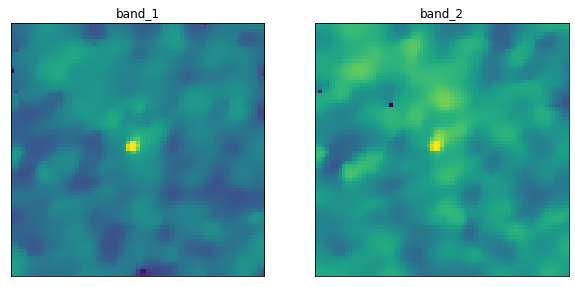

Index : 962


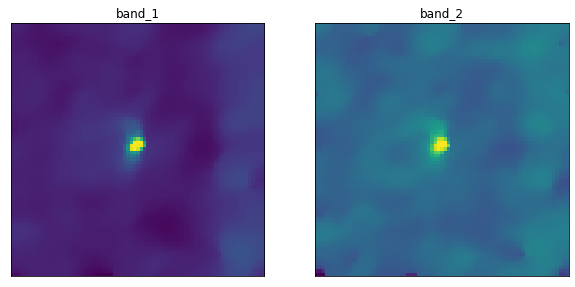

Index : 523


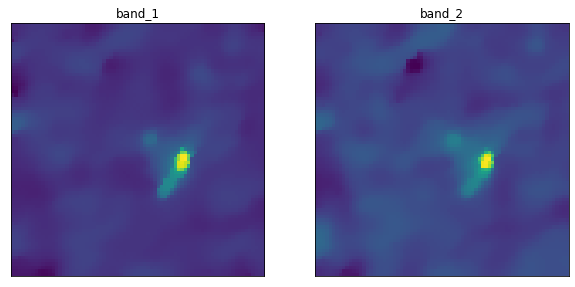

--- Boats predicted as Icebergs ---
Index : 1521


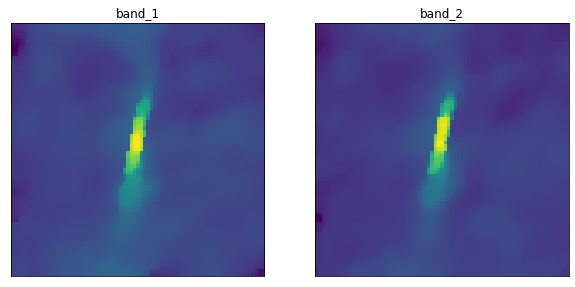

Index : 1097


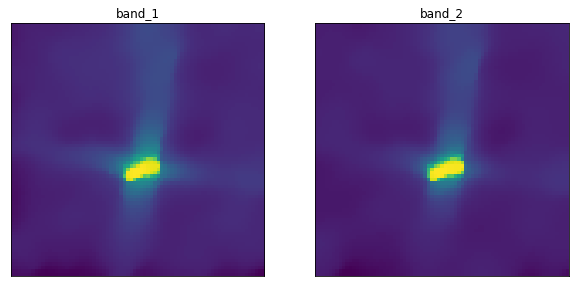

Index : 637


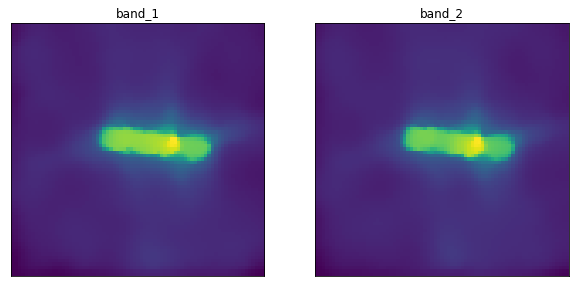

Index : 49


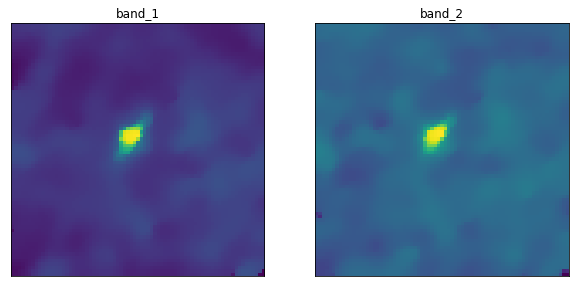

Index : 116


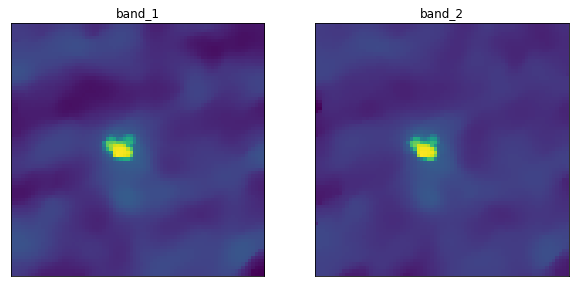

Index : 101


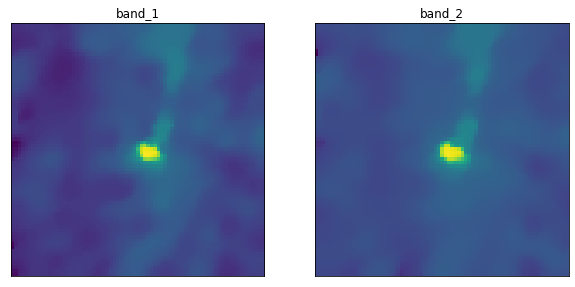

Index : 212


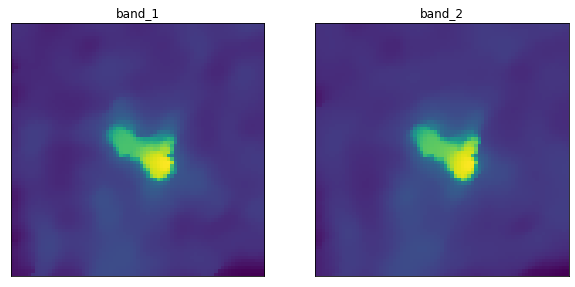

Index : 889


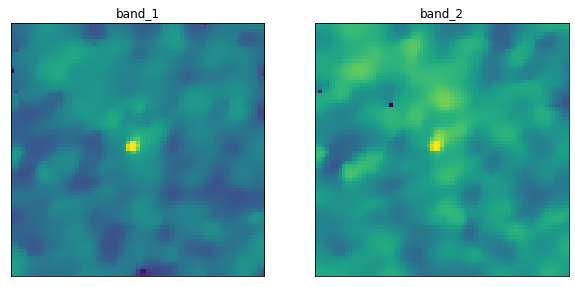

Index : 239


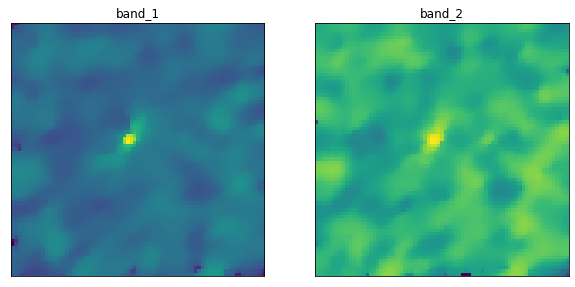

Index : 1530


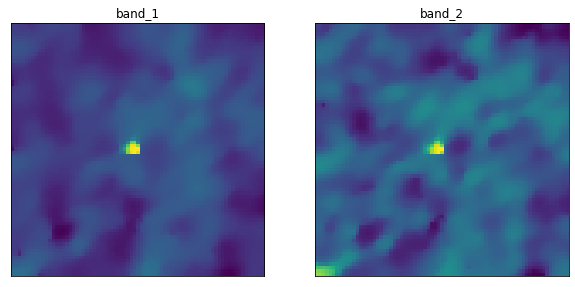

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100} with f1 score 0.865
--- Cross Validation Report ---
Mean accuracy score 0.858 with std 0.029
Mean f1 score 0.867 with std 0.029
Mean precision score 0.844 with std 0.025
Mean recall score 0.893 with std 0.053
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.841
 f1 : 0.847
 precision : 0.807
 recall : 0.89
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 962


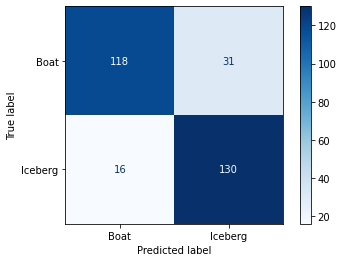

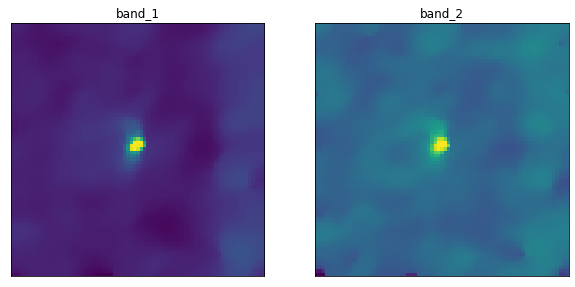

Index : 330


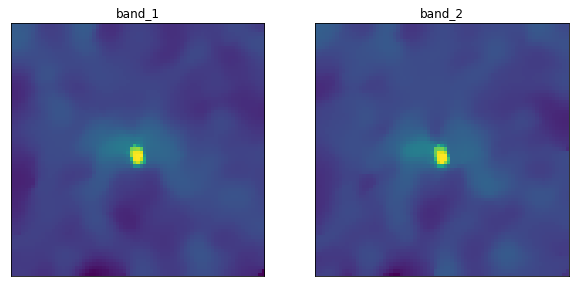

Index : 829


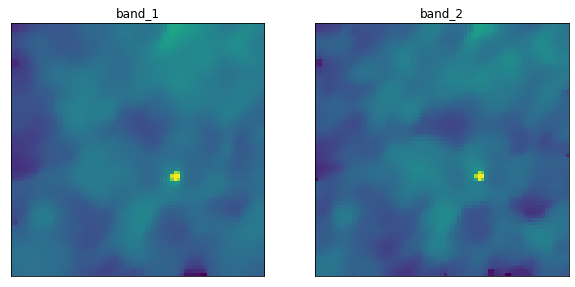

Index : 625


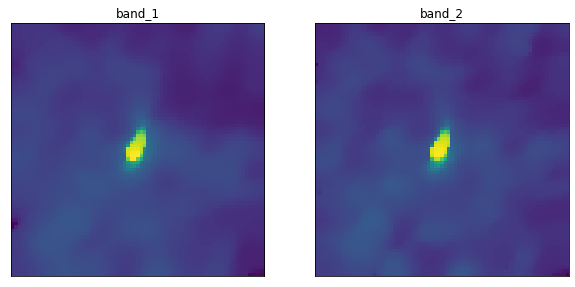

Index : 530


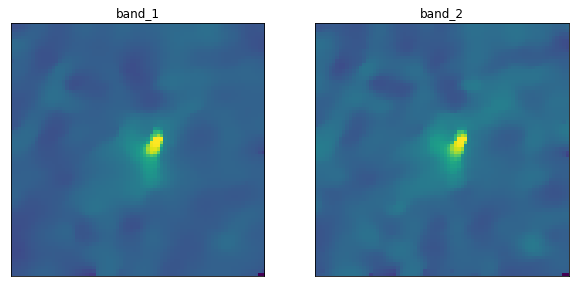

Index : 353


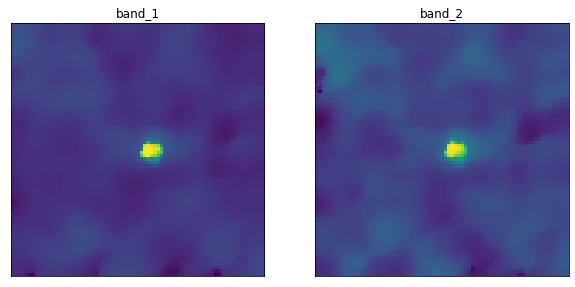

Index : 899


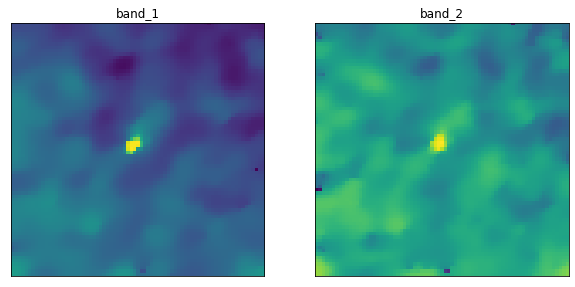

Index : 991


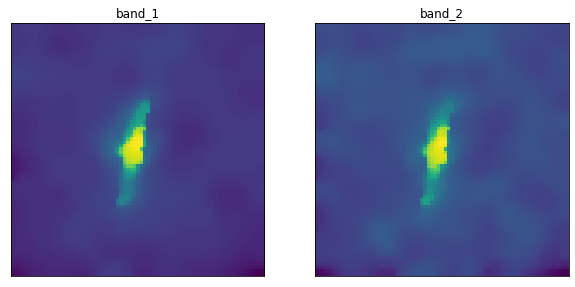

Index : 1160


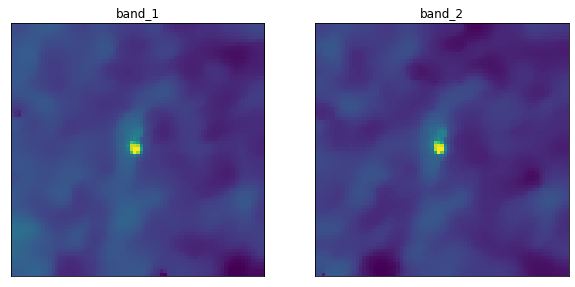

Index : 502


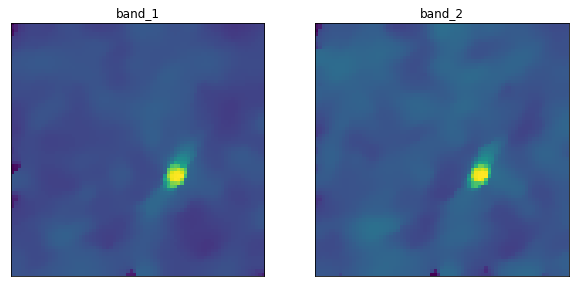

--- Boats predicted as Icebergs ---
Index : 435


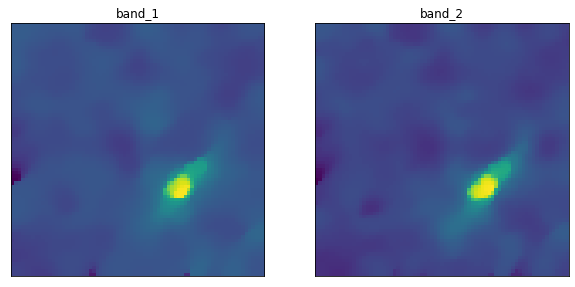

Index : 585


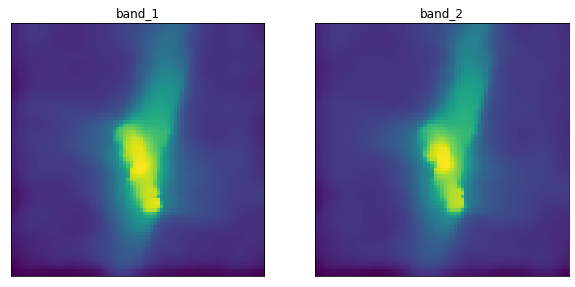

Index : 265


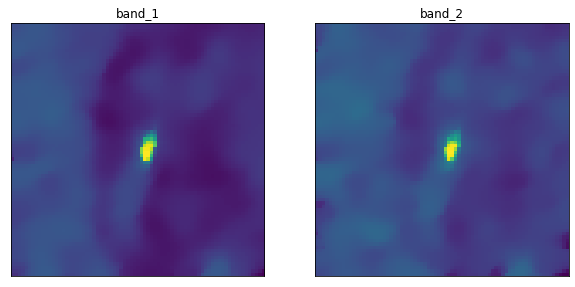

Index : 19


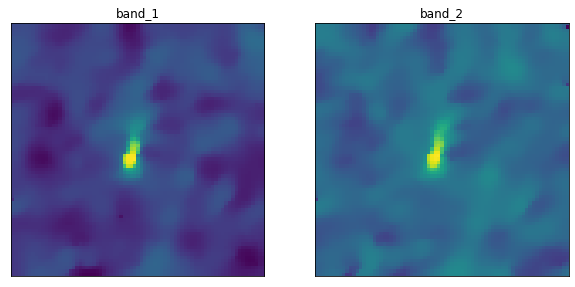

Index : 1175


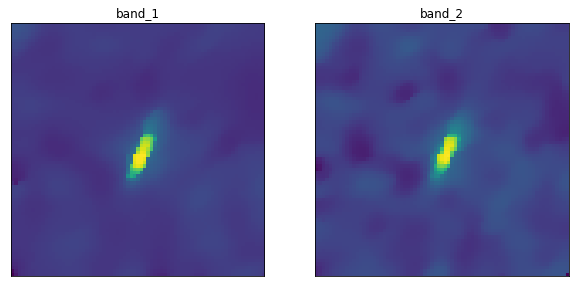

Index : 768


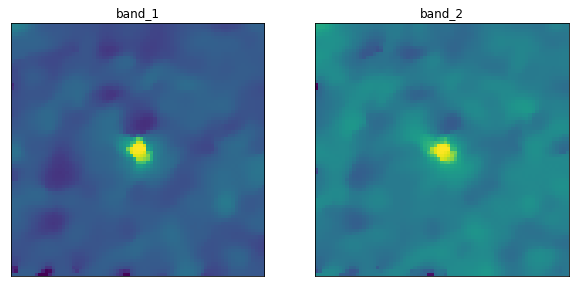

Index : 1431


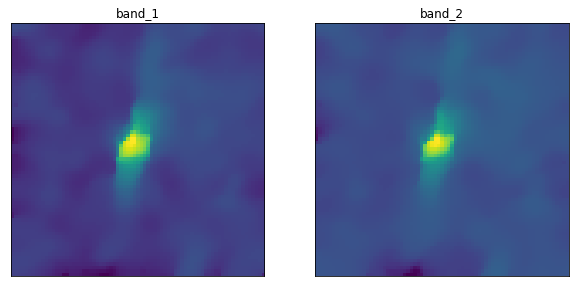

Index : 15


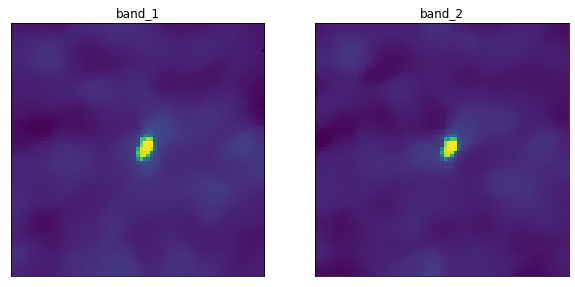

Index : 845


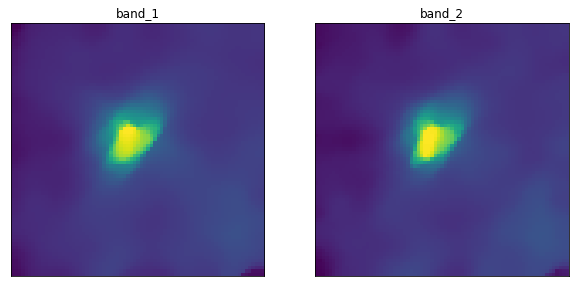

Index : 1038


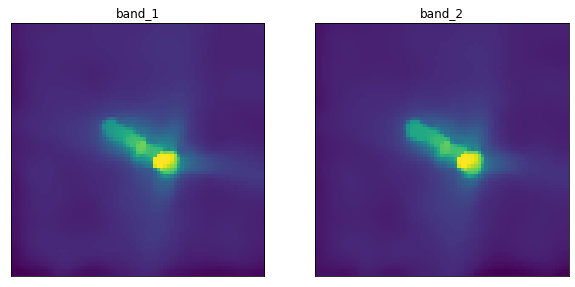

--- Grid Search Report ---
Best parameters for RandomForestClassifier() :
 {'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 100} with f1 score 0.867
--- Cross Validation Report ---
Mean accuracy score 0.855 with std 0.03
Mean f1 score 0.865 with std 0.031
Mean precision score 0.837 with std 0.025
Mean recall score 0.897 with std 0.059
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.847
 f1 : 0.854
 precision : 0.81
 recall : 0.904
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 705


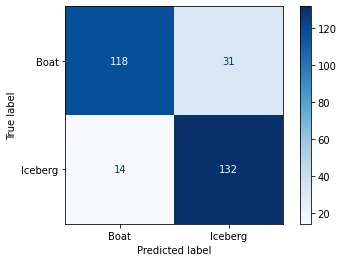

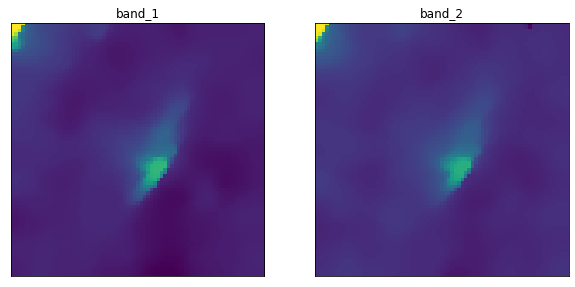

Index : 330


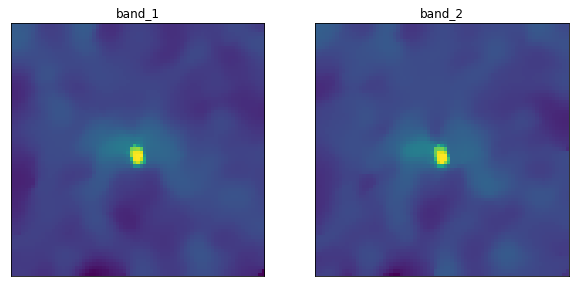

Index : 502


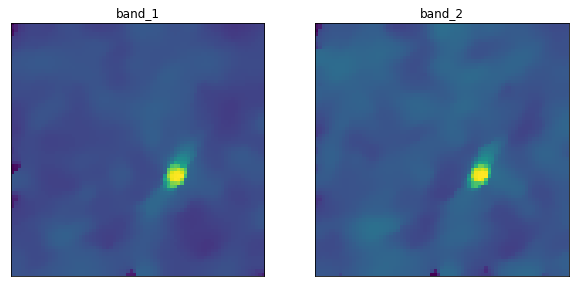

Index : 353


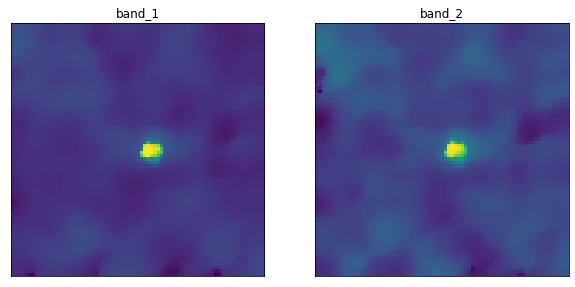

Index : 625


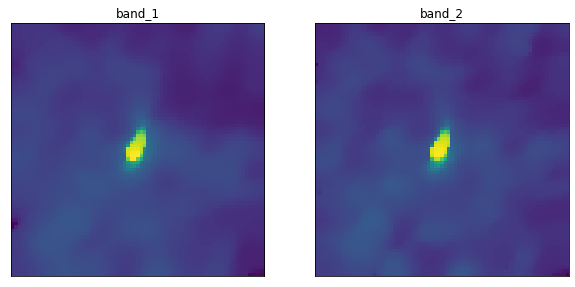

Index : 455


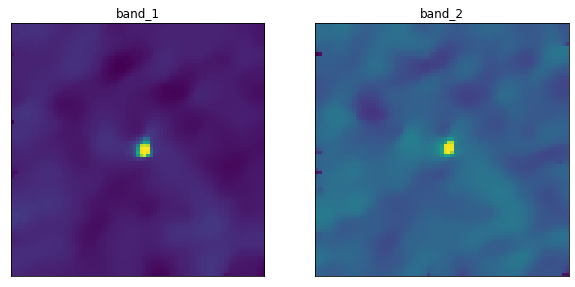

Index : 1160


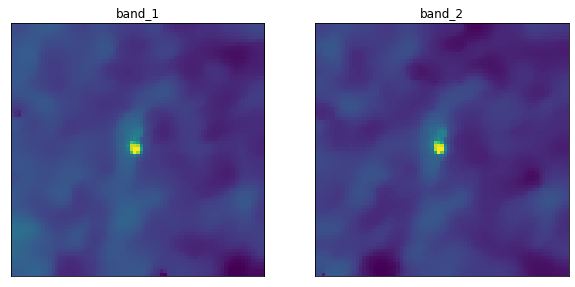

Index : 962


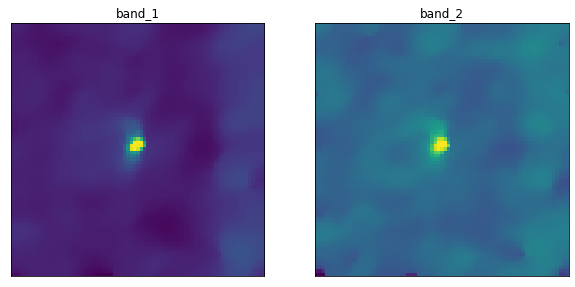

Index : 530


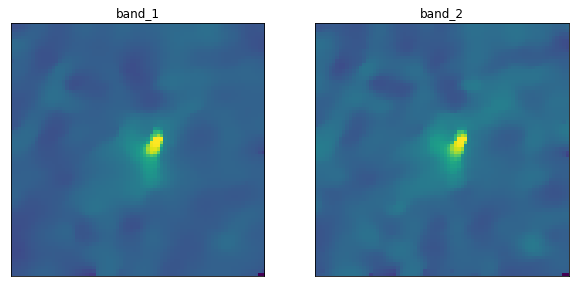

Index : 498


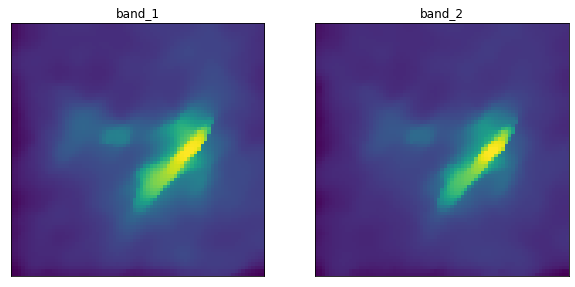

--- Boats predicted as Icebergs ---
Index : 238


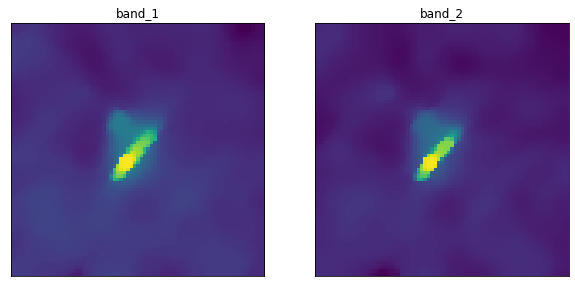

Index : 677


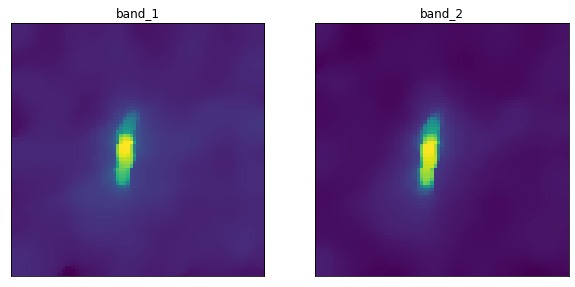

Index : 70


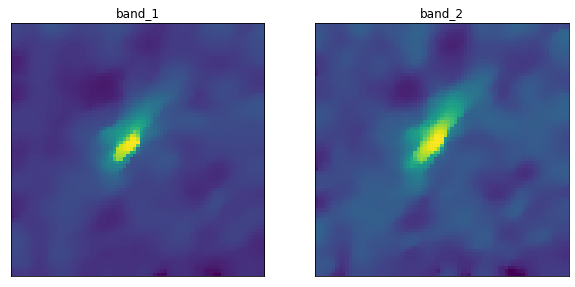

Index : 1063


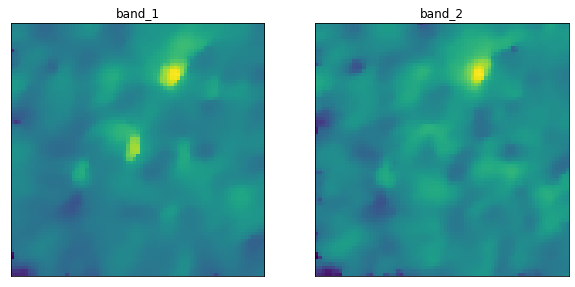

Index : 385


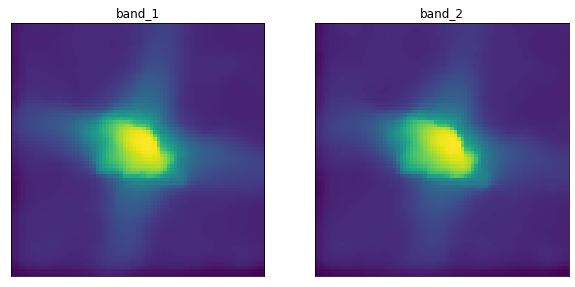

Index : 460


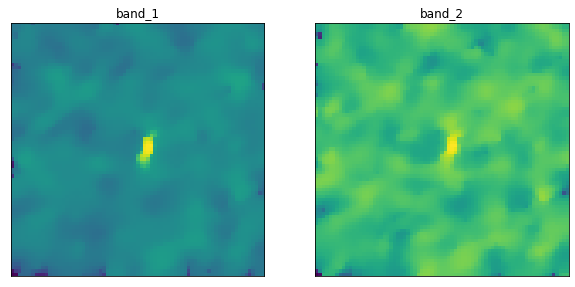

Index : 687


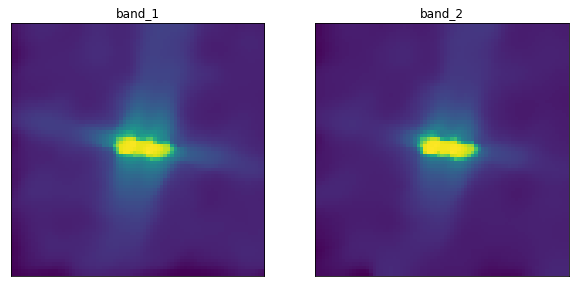

Index : 1540


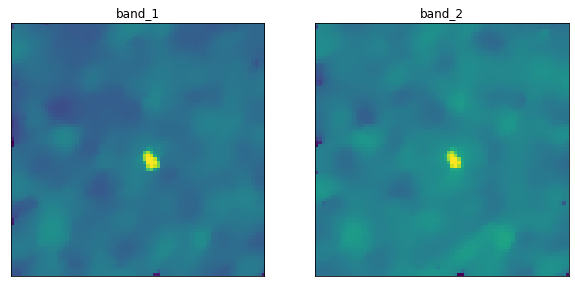

Index : 1205


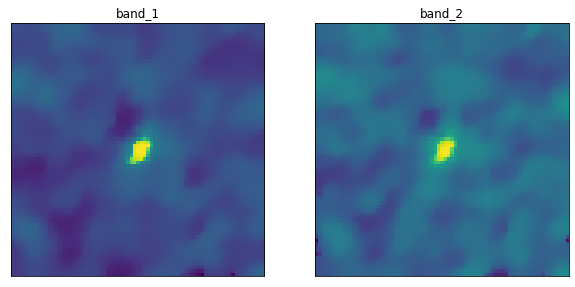

Index : 610


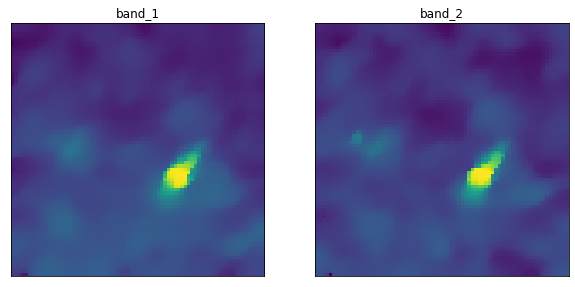

In [78]:
param_grid = [{
    'min_samples_leaf': range(2,4,1),
    'max_features': ['auto'],
    'n_estimators': [100]
}]


er.cv_cv = 3

train_scores_RF = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(RandomForestClassifier(), param_grid)
  train_scores_RF.append(er.best_scores_t)
  er.plot_mistakes(nb_samples = 10)

In [79]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_RF]
y_p2 = [a.get('f1') for a in train_scores_RF]
y_p3 = [a.get('precision') for a in train_scores_RF]
y_p4 = [a.get('recall') for a in train_scores_RF]

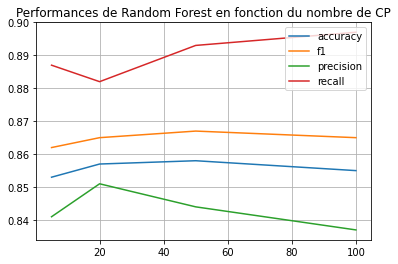

In [80]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Random Forest en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Neural Net

In [81]:
from sklearn.neural_network import MLPClassifier

--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.8
--- Cross Validation Report ---
Mean accuracy score 0.777 with std 0.028
Mean f1 score 0.788 with std 0.028
Mean precision score 0.779 with std 0.029
Mean recall score 0.8 with std 0.051
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.756
 f1 : 0.762
 precision : 0.737
 recall : 0.788
Confusion matrix for the test sample :
--- Grid Search Report ---
Best parameters for MLPClassifier() :
 {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 400, 'solver': 'adam'} with f1 score 0.829
--- Cross Validation Report ---
Mean accuracy score 0.809 with std 0.06
Mean f1 score 0.819 with std 0.057
Mean precision score 0.805 with std 0.055
Mean recall score 0.835 with std 0.065
--- Test Sa

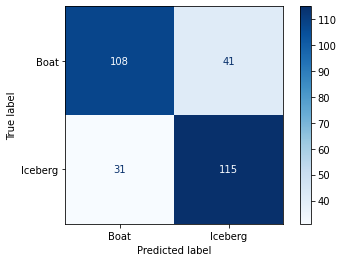

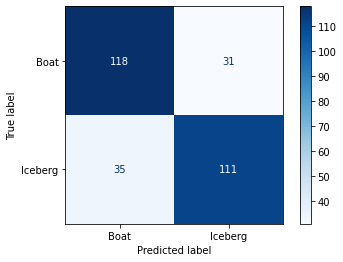

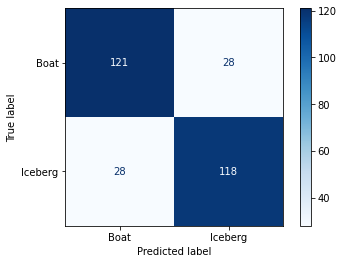

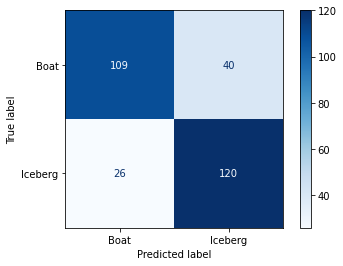

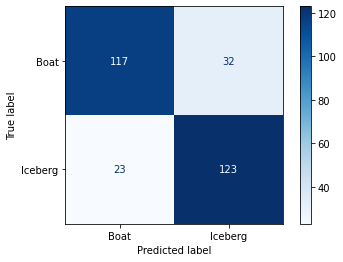

In [82]:
param_grid = [{'activation': ['tanh'],
               'alpha': [0.0001,0.005],
               'hidden_layer_sizes': [(150, 100, 50)],
               'learning_rate': ['adaptive'],
               'max_iter': [400],
               'solver': ['adam']}]



er.cv_cv = 3

train_scores_MLPC = []

er.grid_cross_test_report

df_500=df_stats.join(pca_100.drop('is_iceberg',axis=1)).dropna()

for dtset in [df_5, df_20, df_50, df_100, df_500] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.grid_cross_test_report(MLPClassifier(), param_grid)
  train_scores_MLPC.append(er.best_scores_t)

In [83]:
x_p = [5, 20, 50, 100, 500]
y_p1 = [a.get('accuracy') for a in train_scores_MLPC]
y_p2 = [a.get('f1') for a in train_scores_MLPC]
y_p3 = [a.get('precision') for a in train_scores_MLPC]
y_p4 = [a.get('recall') for a in train_scores_MLPC]

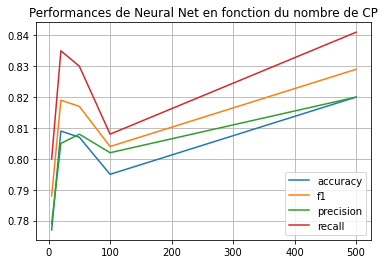

In [84]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Neural Net en fonction du nombre de CP')
plt.grid(True)
plt.show()

###Adaboost

--- Cross Validation Report ---
Mean accuracy score 0.839 with std 0.033
Mean f1 score 0.845 with std 0.033
Mean precision score 0.845 with std 0.027
Mean recall score 0.845 with std 0.048
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.824
 f1 : 0.827
 precision : 0.805
 recall : 0.849
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 991


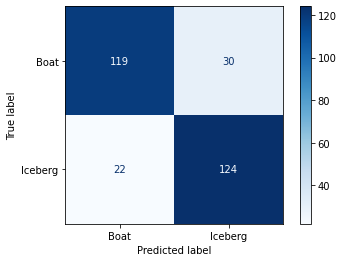

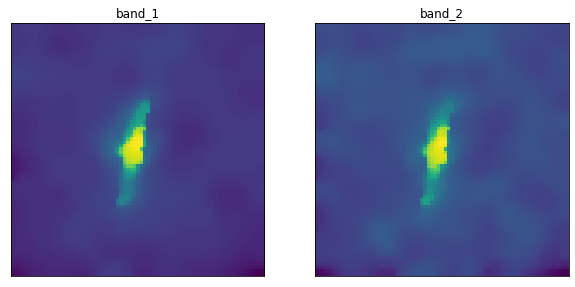

Index : 34


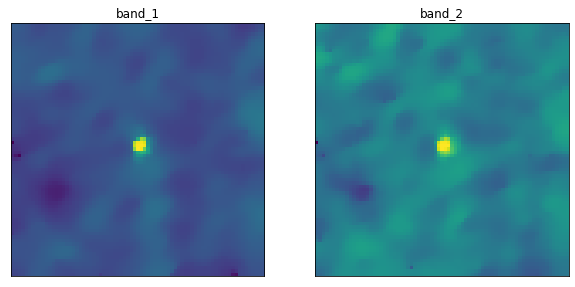

Index : 530


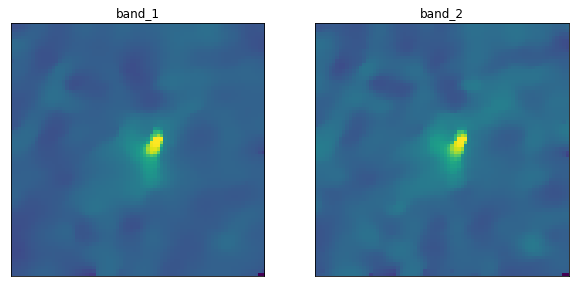

Index : 625


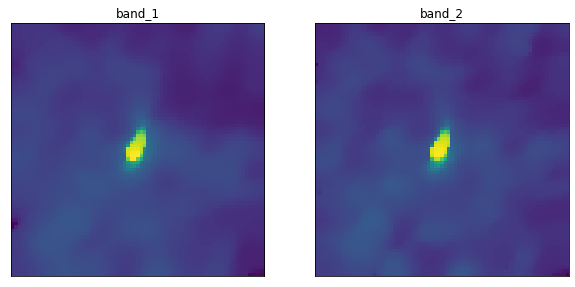

Index : 274


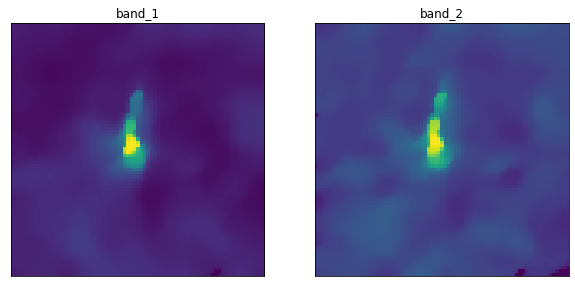

Index : 522


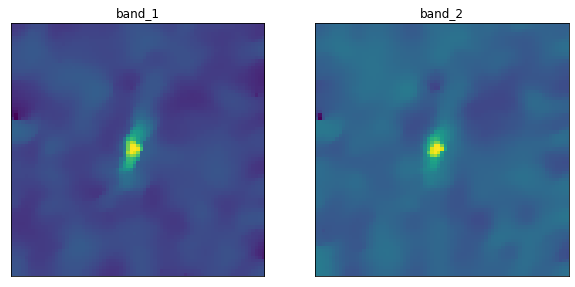

Index : 1160


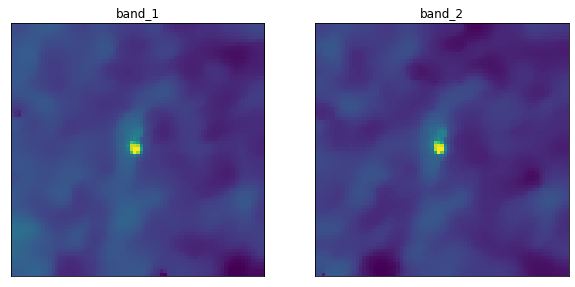

Index : 1033


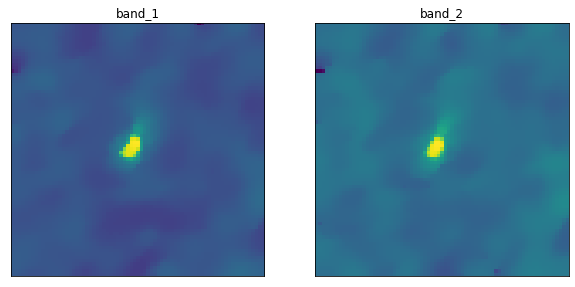

Index : 325


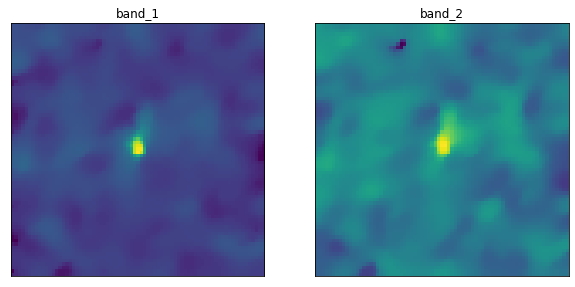

Index : 1336


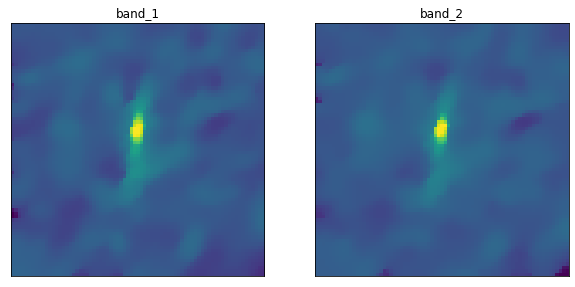

--- Boats predicted as Icebergs ---
Index : 1211


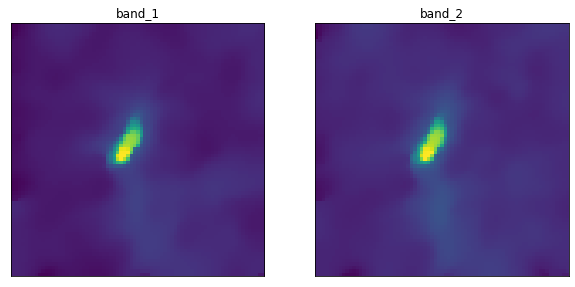

Index : 1005


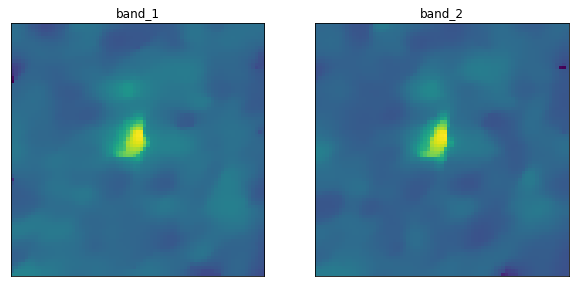

Index : 916


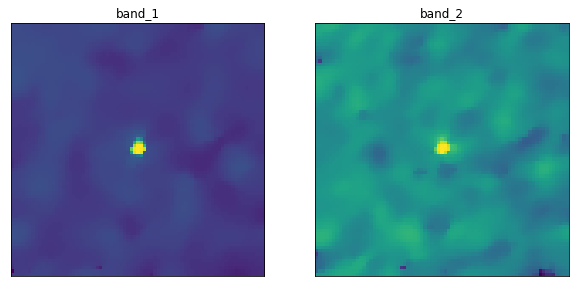

Index : 97


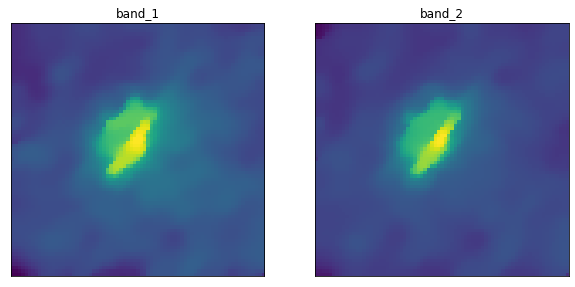

Index : 897


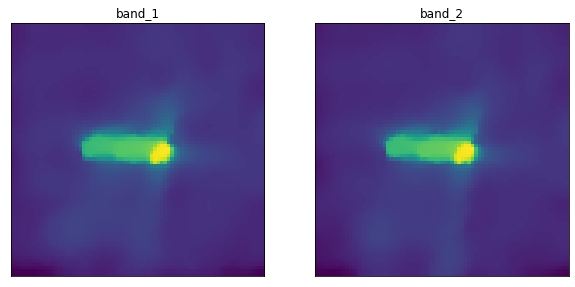

Index : 199


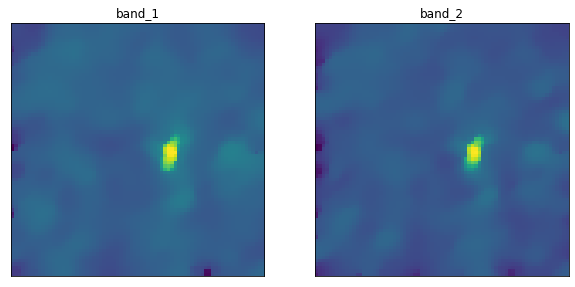

Index : 784


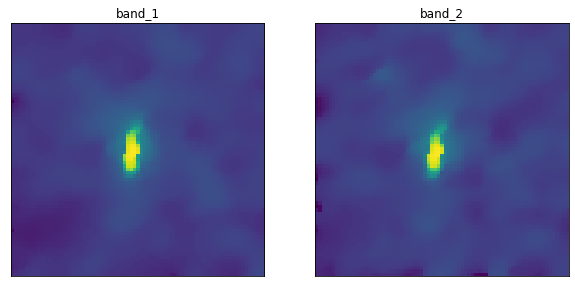

Index : 1557


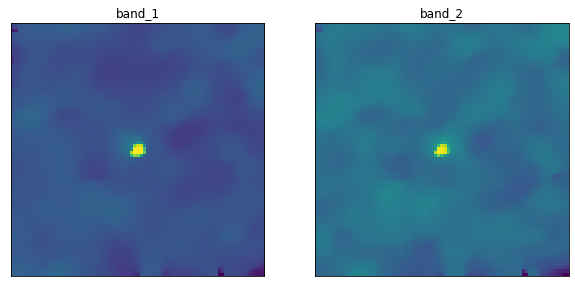

Index : 36


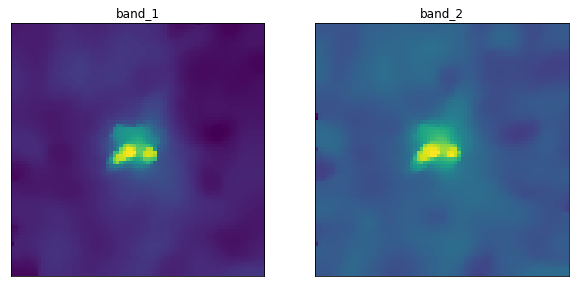

Index : 430


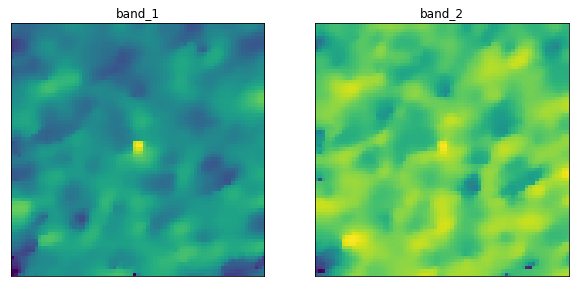

--- Cross Validation Report ---
Mean accuracy score 0.844 with std 0.018
Mean f1 score 0.852 with std 0.017
Mean precision score 0.843 with std 0.032
Mean recall score 0.863 with std 0.039
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.814
 f1 : 0.815
 precision : 0.801
 recall : 0.829
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 140


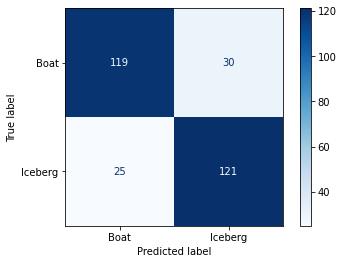

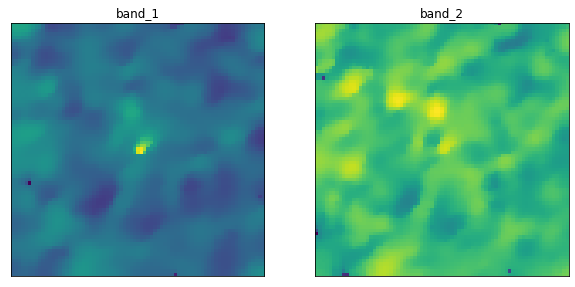

Index : 1336


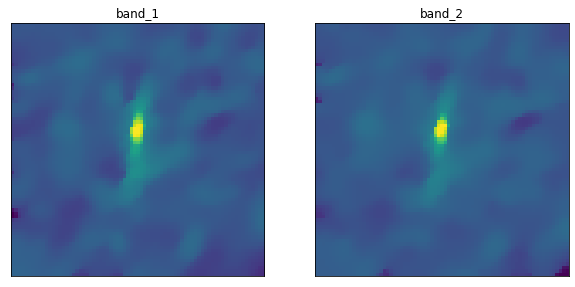

Index : 594


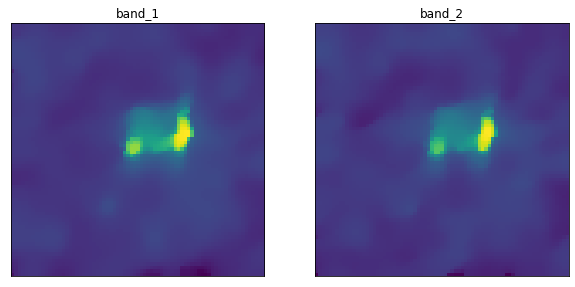

Index : 274


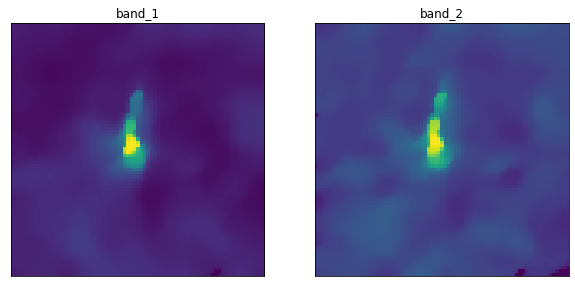

Index : 854


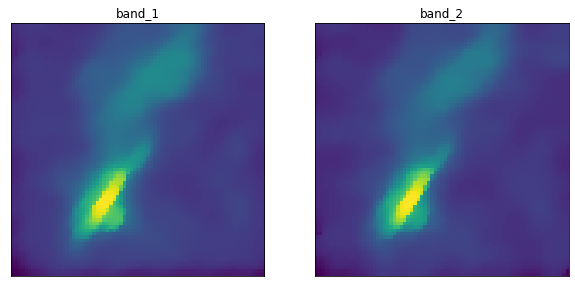

Index : 248


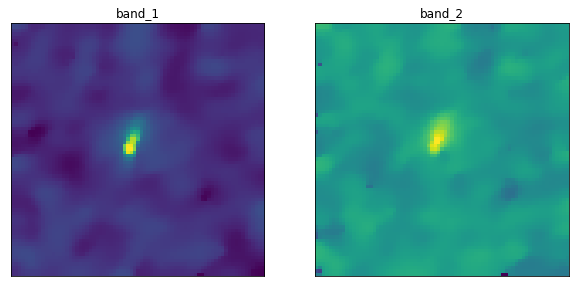

Index : 889


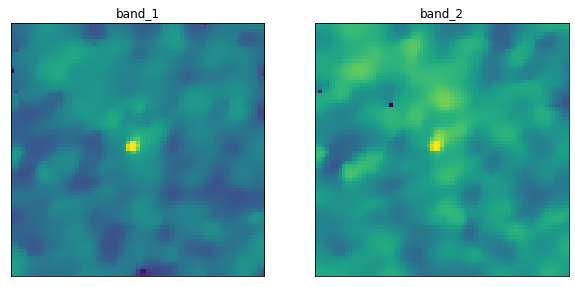

Index : 455


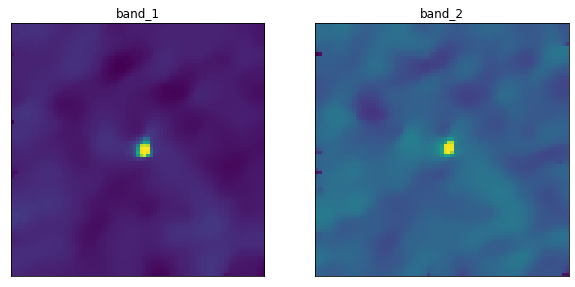

Index : 530


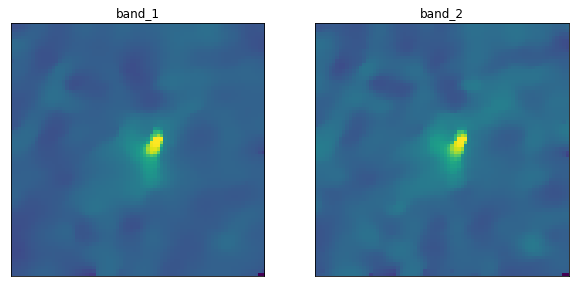

Index : 1206


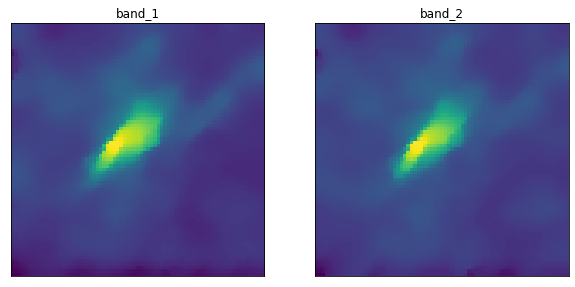

--- Boats predicted as Icebergs ---
Index : 271


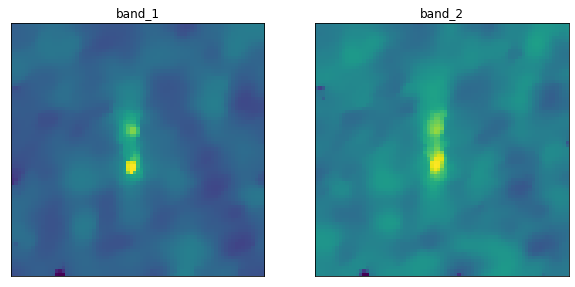

Index : 1496


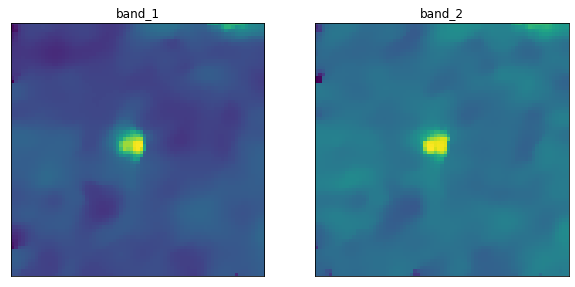

Index : 608


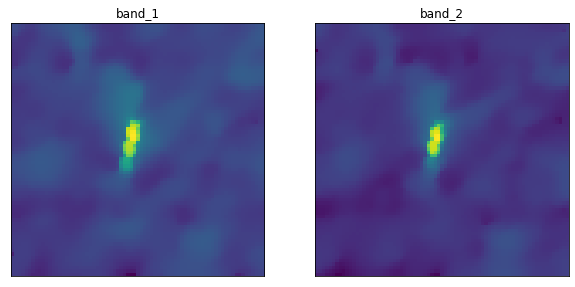

Index : 81


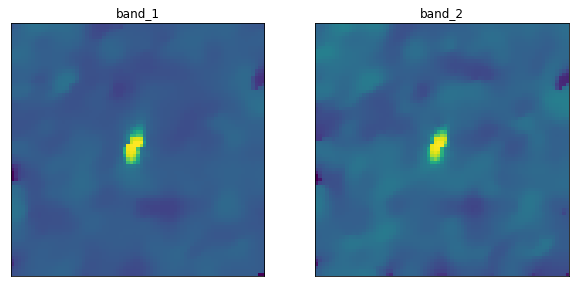

Index : 619


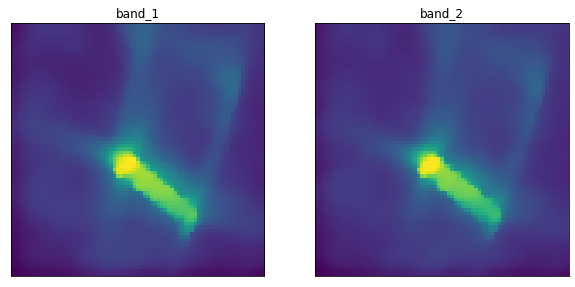

Index : 606


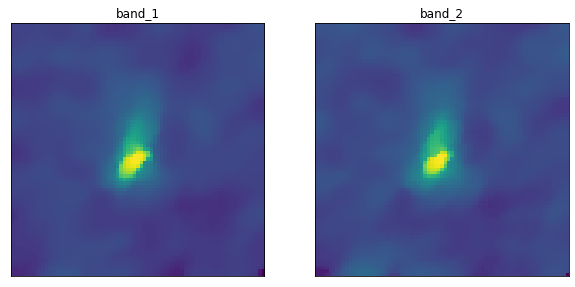

Index : 1266


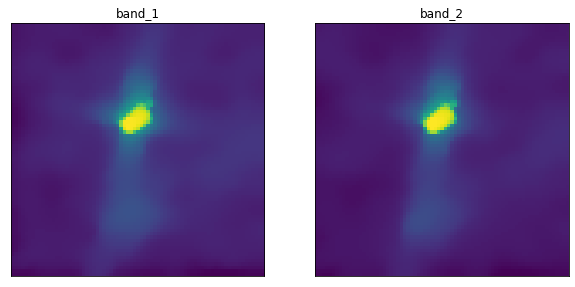

Index : 1155


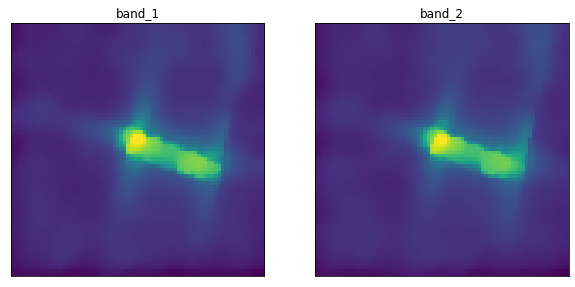

Index : 1026


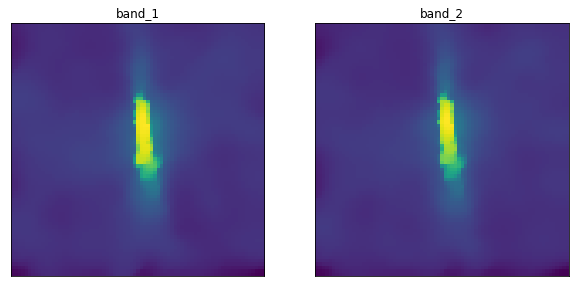

Index : 872


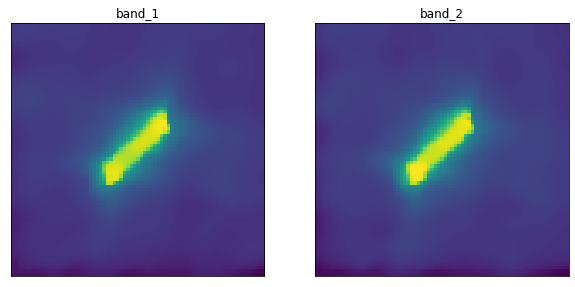

--- Cross Validation Report ---
Mean accuracy score 0.827 with std 0.029
Mean f1 score 0.834 with std 0.028
Mean precision score 0.831 with std 0.039
Mean recall score 0.839 with std 0.031
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.817
 f1 : 0.82
 precision : 0.799
 recall : 0.842
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 104


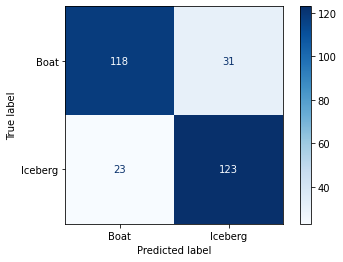

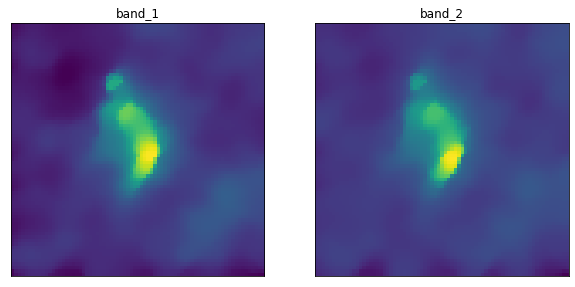

Index : 257


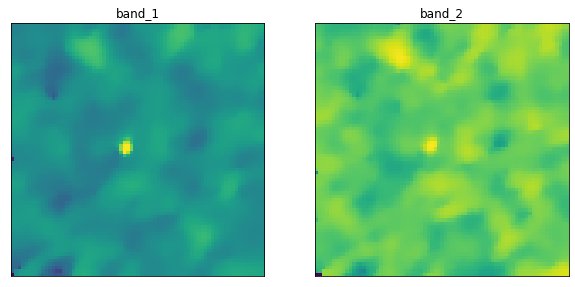

Index : 502


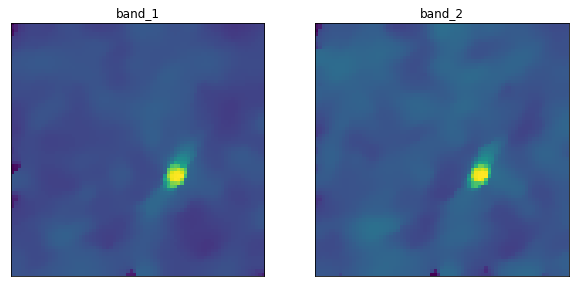

Index : 1033


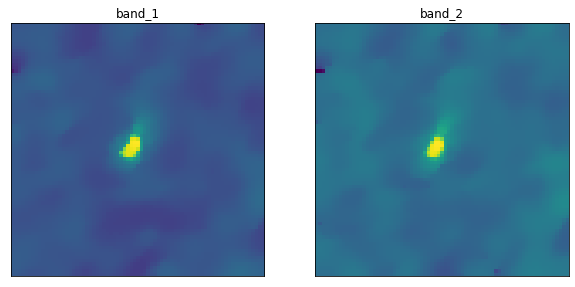

Index : 670


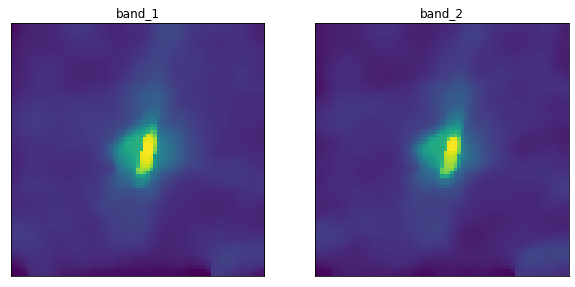

Index : 276


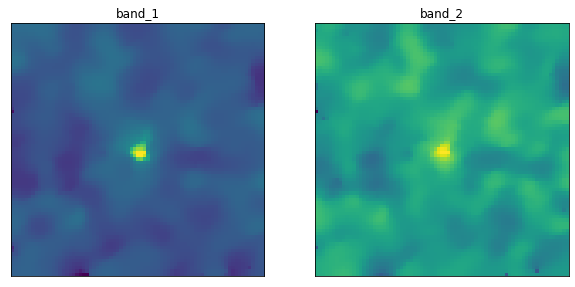

Index : 455


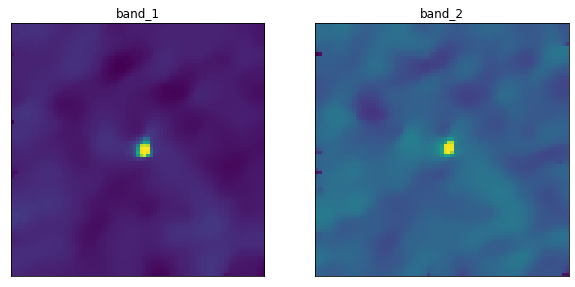

Index : 525


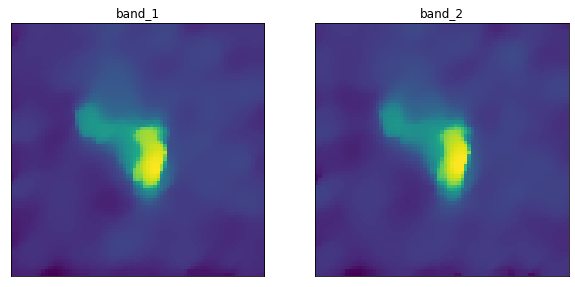

Index : 545


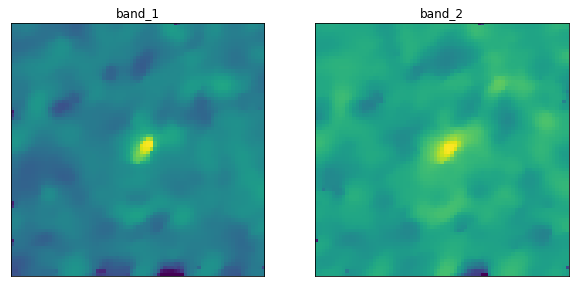

Index : 330


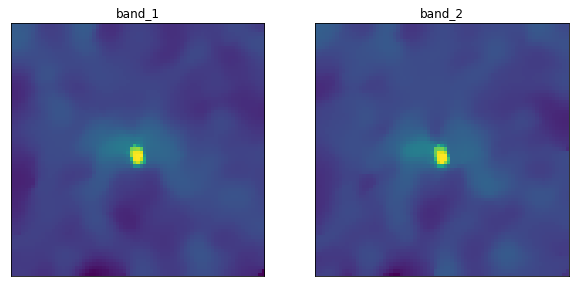

--- Boats predicted as Icebergs ---
Index : 262


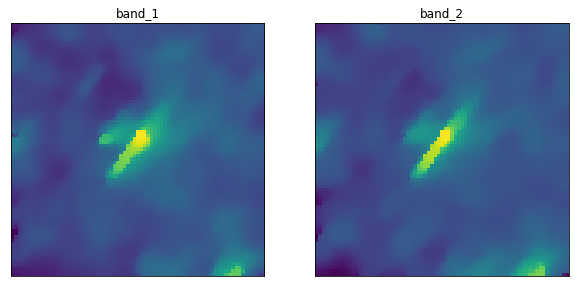

Index : 739


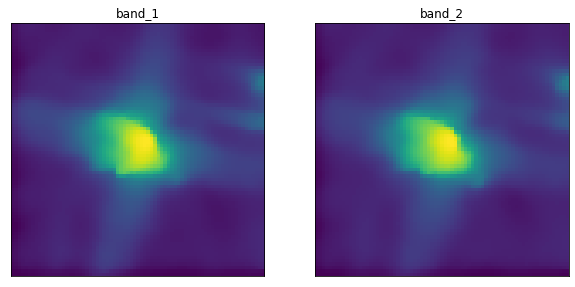

Index : 600


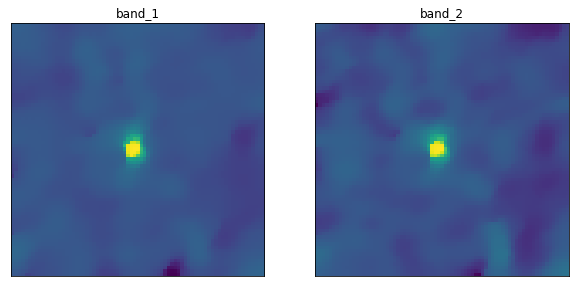

Index : 16


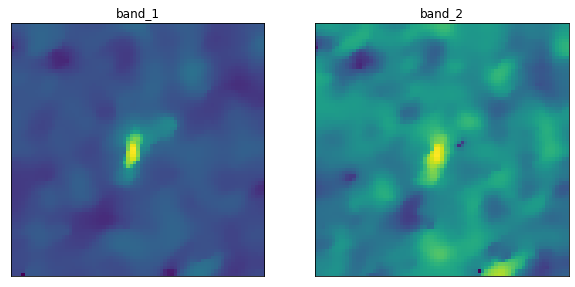

Index : 25


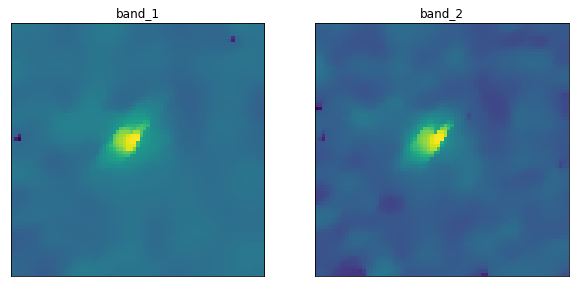

Index : 344


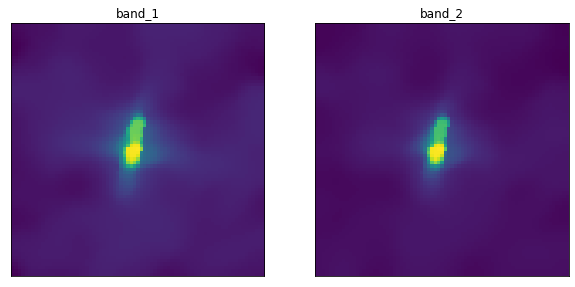

Index : 1013


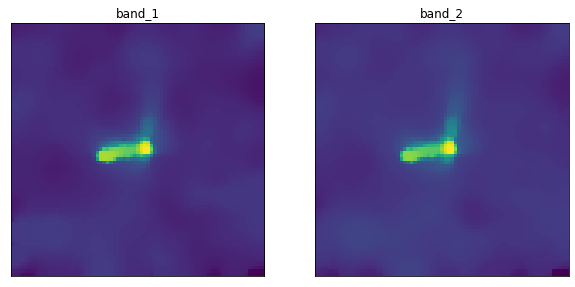

Index : 1374


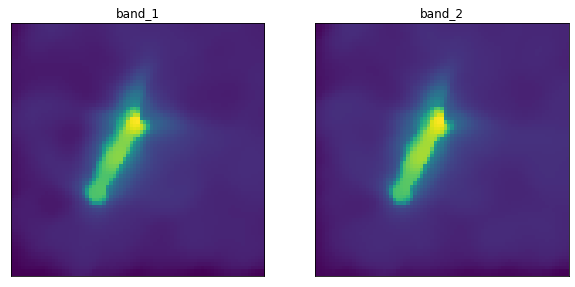

Index : 1371


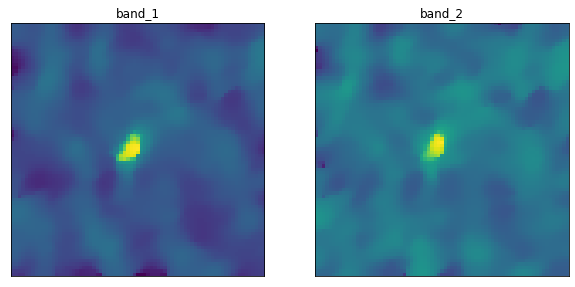

Index : 342


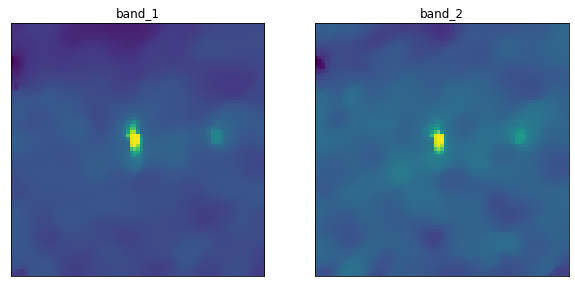

--- Cross Validation Report ---
Mean accuracy score 0.822 with std 0.034
Mean f1 score 0.83 with std 0.033
Mean precision score 0.826 with std 0.041
Mean recall score 0.837 with std 0.048
--- Test Sample Report ---
Scores for the test sample :
 accuracy : 0.81
 f1 : 0.816
 precision : 0.785
 recall : 0.849
Confusion matrix for the test sample :
--- Icebergs predicted as boats ---
Index : 1432


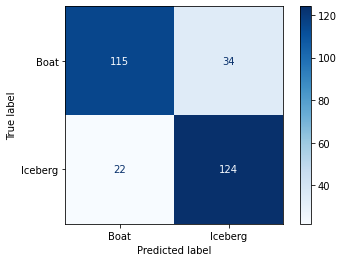

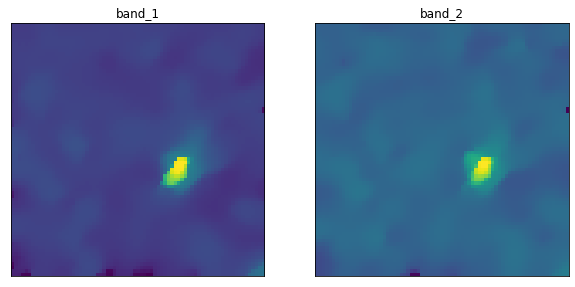

Index : 428


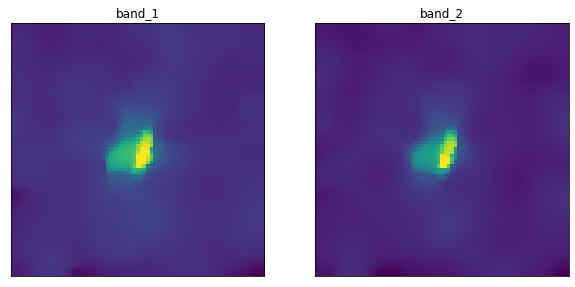

Index : 34


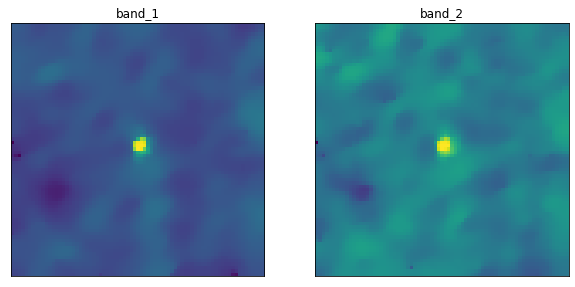

Index : 248


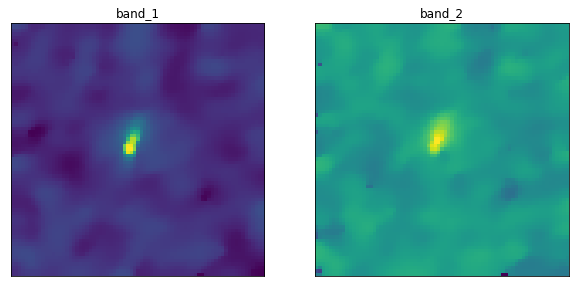

Index : 594


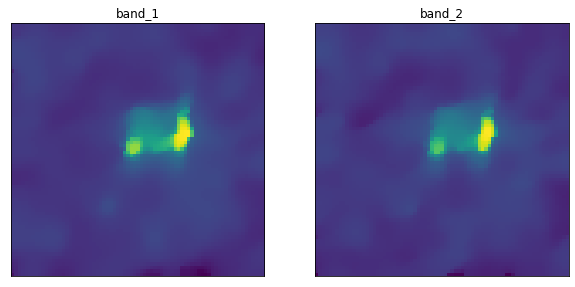

Index : 502


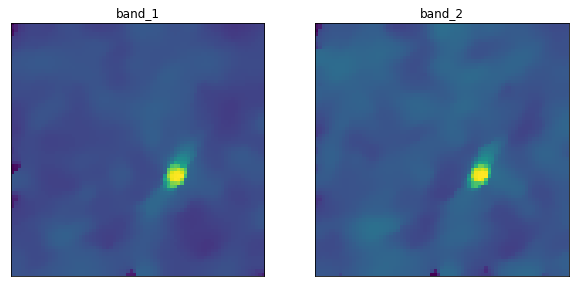

Index : 545


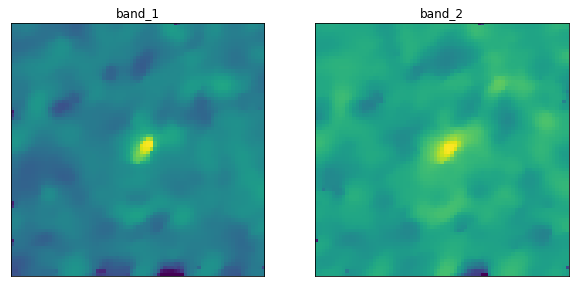

Index : 625


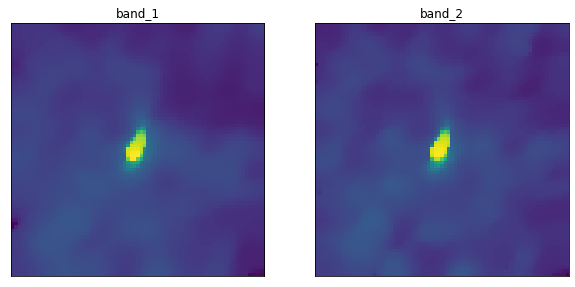

Index : 330


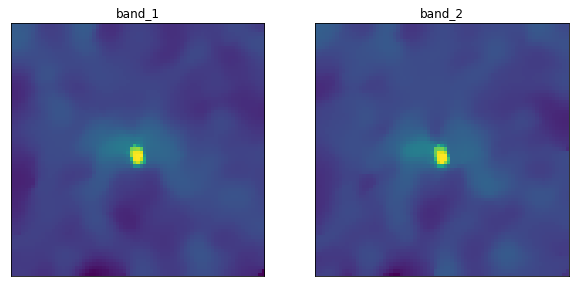

Index : 523


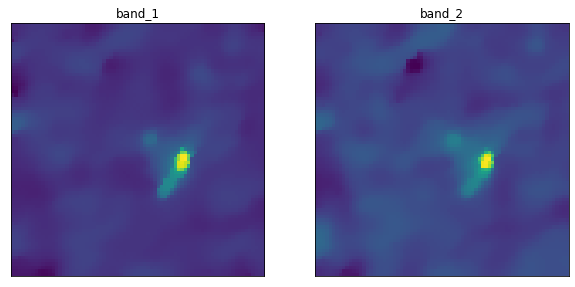

--- Boats predicted as Icebergs ---
Index : 173


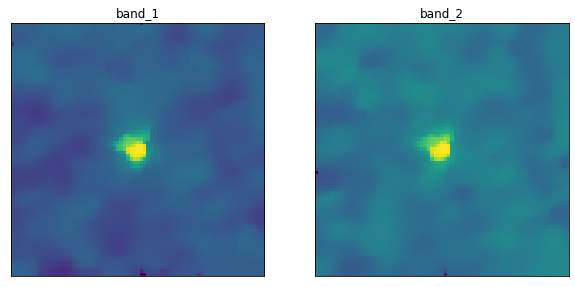

Index : 1378


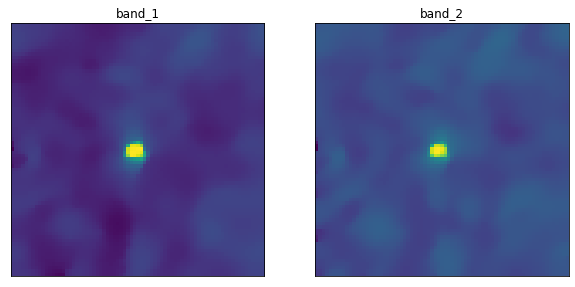

Index : 962


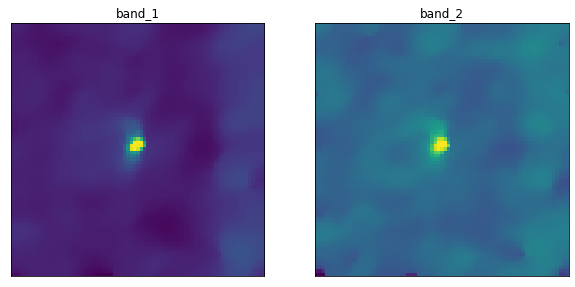

Index : 403


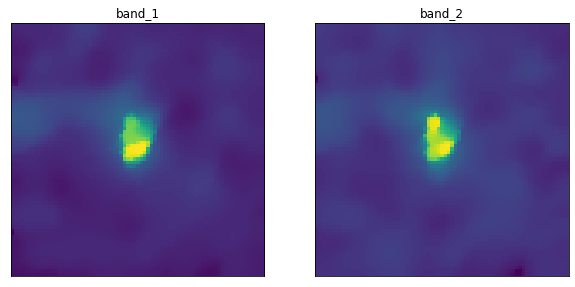

Index : 303


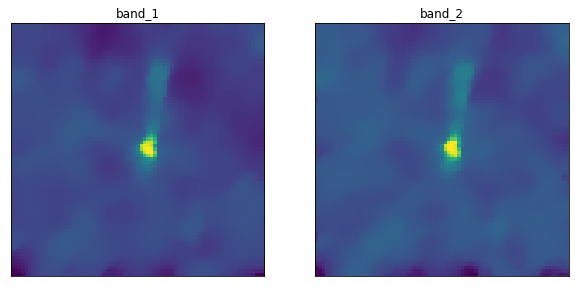

Index : 565


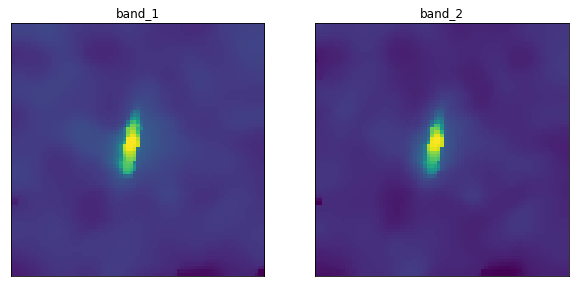

Index : 1461


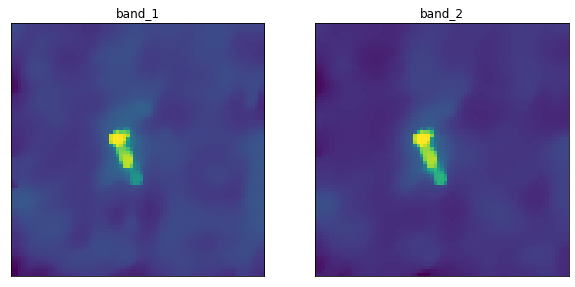

Index : 1588


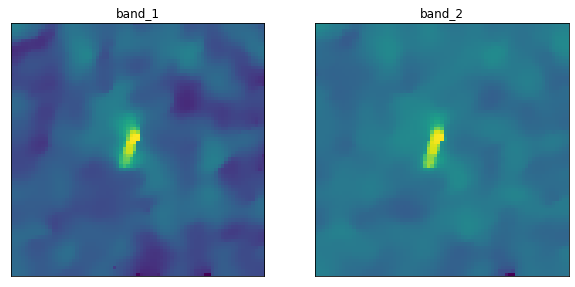

Index : 441


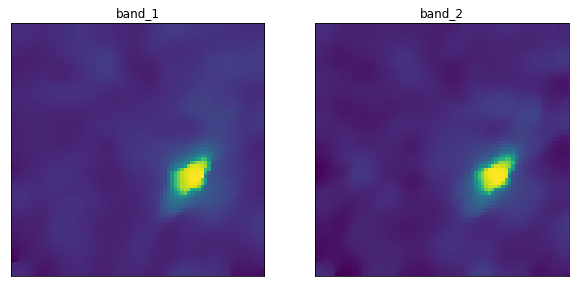

Index : 223


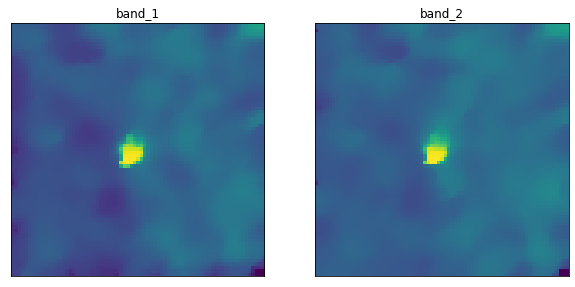

In [85]:


er.cv_cv = 3

train_scores_Adaboost = []

er.grid_cross_test_report

for dtset in [df_5, df_20, df_50, df_100] : 
  y = dtset["is_iceberg"]
  X_stats = dtset.drop('is_iceberg',axis=1)
  X_train, X_test, y_train, y_test = train_test_split(X_stats, y, random_state = 0)
  er = EvaluateAndReport(dtset, X_train, X_test, y_train, y_test)
  er.cross_test_report(AdaBoostClassifier())
  train_scores_Adaboost.append(er.best_scores_t)
  er.plot_mistakes(nb_samples = 10)

In [86]:
x_p = [5, 20, 50, 100]
y_p1 = [a.get('accuracy') for a in train_scores_Adaboost]
y_p2 = [a.get('f1') for a in train_scores_Adaboost]
y_p3 = [a.get('precision') for a in train_scores_Adaboost]
y_p4 = [a.get('recall') for a in train_scores_Adaboost]

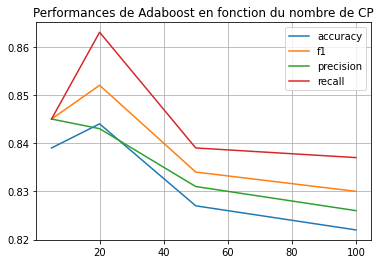

In [87]:
plt.plot(x_p, y_p1, label='accuracy')
plt.plot(x_p, y_p2, label='f1')
plt.plot(x_p, y_p3, label='precision')
plt.plot(x_p, y_p4, label='recall')
plt.legend()
plt.title('Performances de Adaboost en fonction du nombre de CP')
plt.grid(True)
plt.show()